# Machine Learning Accent Prediction

This file contains the development and final models of accent prediction machine learning models.

*Author: Justin Frandsen*

## Install & Load Packages

In [ ]:
!pip install pandas librosa

In [ ]:
!pip install pandas torchaudio transformers ffmpeg audiomentations

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 16.8 MB/s eta 0:00:00
   

In [ ]:
import os
import librosa
import torchaudio
import pandas as pd
import kagglehub
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

### Load Kaggle Dataset

https://www.kaggle.com/datasets/rtatman/speech-accent-archive?resource=download&select=speakers_all.csv

Load and extract the Kaggle dataset, containing **2140 speech samples**, each from a different talker reading the same reading passage. Talkers come from **177 countries** and have **214 different native languages**. Each talker is speaking in English.

This dataset contains the following files:
* reading-passage.txt: the text all speakers read
* **speakers_all.csv**: demographic information on every speaker
* **recording**: a zipped folder containing .mp3 files with speech

In [ ]:
!pip install kagglehub --quiet

import kagglehub
import os
from zipfile import ZipFile

dataset_path = kagglehub.dataset_download('rtatman/speech-accent-archive')
zip_file = os.path.join(dataset_path, 'speech-accent-archive.zip')

with ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/recordings')

In [ ]:
# import os
# from zipfile import ZipFile

# # Set up Kaggle API credentials
# os.environ['KAGGLE_USERNAME'] = 'frustin'
# os.environ['KAGGLE_KEY'] = ''

# # Download the dataset
# !kaggle datasets download -d rtatman/speech-accent-archive

# # Extract the dataset
# with ZipFile('speech-accent-archive.zip', 'r') as zip_ref:
#     zip_ref.extractall('recordings')

Dataset URL: https://www.kaggle.com/datasets/rtatman/speech-accent-archive
License(s): CC-BY-NC-SA-4.0


In [ ]:
import pandas as pd
import os

# Load metadata
metadata_path = "recordings/speakers_all.csv"
metadata = pd.read_csv(metadata_path, sep=',')

metadata = metadata.drop(columns=["Unnamed: 9", "Unnamed: 10", "Unnamed: 11"])

metadata = metadata[~metadata['file_missing?']]

print("Cleaned metadata:")
metadata.head()

Cleaned metadata:


age  age_onset                         birthplace    filename  \
32  27.0        9.0             virginia, south africa  afrikaans1   
33  40.0        5.0             pretoria, south africa  afrikaans2   
34  43.0        4.0  pretoria, transvaal, south africa  afrikaans3   
35  26.0        8.0             pretoria, south africa  afrikaans4   
36  19.0        6.0            cape town, south africa  afrikaans5   

   native_language     sex  speakerid       country  file_missing?  
32       afrikaans  female          1  south africa          False  
33       afrikaans    male          2  south africa          False  
34       afrikaans    male        418  south africa          False  
35       afrikaans    male       1159  south africa          False  
36       afrikaans    male       1432  south africa          False

**Columns**: age, age_onset, birthplace, filename, native_language, sex, speakerid, file_missing?

In [ ]:
# Path to audio files
audio_dir = "recordings/recordings/recordings"

# Check if audio files exist and filter out missing files
valid_files = []
valid_countries = []

for fname, country in zip(metadata['filename'], metadata['country']):
    audio_path = os.path.join(audio_dir, fname + ".mp3")
    if os.path.exists(audio_path):
        valid_files.append(audio_path)
        valid_countries.append(country)
    else:
        print(f"Warning: {audio_path} not found. Skipping this file.")

print(f"Found {len(valid_files)} valid audio files.")

Found 2138 valid audio files.


**File Paths**:

audio_dir = "recordings/recordings/recordings"

metadata_path = "recordings/speakers_all.csv"

### Convert .mp3 to .wav

In [ ]:
import os
import pandas as pd
import subprocess
from tqdm import tqdm

# Path to audio files - let's check the actual structure
audio_dir = "recordings/recordings/recordings"
wav_dir = "recordings/wav_files"
os.makedirs(wav_dir, exist_ok=True)

# Check directory for files
print("Checking directory contents...")
if os.path.exists(audio_dir):
    files_in_dir = os.listdir(audio_dir)
    print(f"Found {len(files_in_dir)} files in {audio_dir}")
    if files_in_dir:
        print(f"Sample files: {files_in_dir[:5]}")
else:
    print(f"Directory {audio_dir} doesn't exist!")
    for root, dirs, files in os.walk("recordings"):
        if files and any(f.endswith('.mp3') for f in files):
            print(f"Found MP3 files in: {root}")
            print(f"Sample files: {[f for f in files if f.endswith('.mp3')][:5]}")
            audio_dir = root
            break

# Function to convert MP3 to WAV using subprocess (more reliable than ffmpeg-python in some cases)
def convert_mp3_to_wav(mp3_path, wav_path):
    try:
        result = subprocess.run(
            ['ffmpeg', '-i', mp3_path, '-ar', '16000', '-ac', '1', wav_path, '-y'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            check=False
        )
        return result.returncode == 0 and os.path.exists(wav_path)
    except Exception as e:
        print(f"Exception during conversion: {e}")
        return False

# Load metadata
metadata_path = "recordings/speakers_all.csv"
metadata = pd.read_csv(metadata_path)

# Clean up metadata
if "Unnamed: 9" in metadata.columns:
    unnamed_cols = [col for col in metadata.columns if col.startswith("Unnamed")]
    metadata = metadata.drop(columns=unnamed_cols)

# Filter out rows with missing files
if "file_missing?" in metadata.columns:
    metadata = metadata[~metadata['file_missing?']]

# Track conversions
converted_files = []
failed_files = []

# Add a new column for WAV file paths
metadata['wav_path'] = None

# Start conversion process
for idx, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Converting files"):
    fname = row['filename']

    # Try with and without extension
    possible_paths = [
        os.path.join(audio_dir, fname + ".mp3"),  # With .mp3 extension
        os.path.join(audio_dir, fname),           # No extension
        os.path.join(audio_dir, fname.lower() + ".mp3"),  # Lowercase with extension
        os.path.join(audio_dir, fname.lower())    # Lowercase no extension
    ]

    mp3_path = None
    for path in possible_paths:
        if os.path.exists(path):
            mp3_path = path
            break

    if not mp3_path:
        failed_files.append(fname)
        print(f"Warning: Audio file for {fname} not found. Tried paths: {possible_paths}")
        continue

    wav_path = os.path.join(wav_dir, fname + ".wav")

    if convert_mp3_to_wav(mp3_path, wav_path):
        converted_files.append(fname)
        metadata.at[idx, 'wav_path'] = wav_path
    else:
        failed_files.append(fname)
        print(f"Warning: Conversion failed for {mp3_path}.")

print(f"Converted {len(converted_files)} MP3 files to WAV.")
print(f"Failed to convert {len(failed_files)} files.")

# Remove rows with missing WAV files
metadata_cleaned = metadata.dropna(subset=['wav_path'])
print(f"Final dataset contains {len(metadata_cleaned)} valid samples.")

# Save updated metadata
if len(metadata_cleaned) > 0:
    metadata_cleaned.to_csv("recordings/metadata_wav.csv", index=False)
    print("Saved updated metadata to recordings/metadata_wav.csv")

Checking directory contents...
Found 2138 files in recordings/recordings/recordings
Sample files: ['farsi15.mp3', 'english342.mp3', 'english428.mp3', 'english60.mp3', 'english23.mp3']


Converting files:  71%|███████   | 1512/2140 [05:00<01:56,  5.37it/s]

Converting files:  81%|████████▏ | 1741/2140 [05:43<01:00,  6.57it/s]

Converting files: 100%|██████████| 2140/2140 [07:05<00:00,  5.03it/s]

Converted 2138 MP3 files to WAV.
Failed to convert 2 files.
Final dataset contains 2138 valid samples.
Saved updated metadata to recordings/metadata_wav.csv


**Load & Play Test Audio in .wav Format**

In [ ]:
# import IPython.display as ipd

# # Load and play a sample
# sample_wav = metadata_cleaned.iloc[0]['wav_path']
# print(f"Playing sample: {sample_wav}")
# ipd.Audio(sample_wav)

## Save Progress

**Mount Google Drive**

In [ ]:
import shutil
from google.colab import drive

# MOUNT GOOGLE DRIVE
drive.mount('/content/drive')

Mounted at /content/drive


**Save Current Directory** (including .wav files!)

In [ ]:
import shutil
from google.colab import files

directory_to_zip = "recordings"
zip_filename = "full_speech_accent_dataset_with_wavs.zip"

print(f"Zipping the directory '{directory_to_zip}' into '{zip_filename}'...")

# Create the zip file.
# 'make_archive' takes the output filename (without .zip), format, root_dir, and base_dir.
# root_dir='.' means the current directory.
# base_dir=directory_to_zip means it will zip the 'recordings' folder.
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', root_dir='.', base_dir=directory_to_zip)

print(f"Zip file created: {zip_filename}")
print("Starting download...")

files.download(zip_filename)

In [ ]:
import IPython.display as ipd

# Load and play a sample
sample_wav = metadata_cleaned.iloc[0]['wav_path']
print(f"Playing sample: {sample_wav}")
ipd.Audio(sample_wav)

Playing sample: recordings/wav_files/afrikaans1.wav


## Binary Native Language Models

#### Ex Models

**10 Epochs**

Full dataset class distribution:
is_english
0    1559
1     579
Name: count, dtype: int64
Total samples in full dataset: 2138


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

Training set size: 1710, Test set size: 428
Training set class distribution (full data split): is_english
0    1247
1     463
Name: count, dtype: int64
Using WeightedRandomSampler for training.
Calculated class weights for CrossEntropyLoss: tensor([0.5415, 1.4585])
Using device: cuda


config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Unfroze the last 2 Wav2Vec2 transformer layers.


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Using weighted CrossEntropyLoss.

Starting training on FULL dataset for 10 epochs (fine-tuning)...


Epoch 1/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 1/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1/10: Train Loss: 0.4722, Test Loss: 0.3831, Test Bal. Acc: 85.02%
              precision    recall  f1-score   support

 Non-English       0.98      0.74      0.85       312
     English       0.58      0.96      0.72       116

    accuracy                           0.80       428
   macro avg       0.78      0.85      0.78       428
weighted avg       0.87      0.80      0.81       428

  New best model saved (Bal. Acc: 85.02%)


Epoch 2/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 2/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2/10: Train Loss: 0.2643, Test Loss: 0.4113, Test Bal. Acc: 84.06%
              precision    recall  f1-score   support

 Non-English       0.98      0.72      0.83       312
     English       0.56      0.96      0.71       116

    accuracy                           0.79       428
   macro avg       0.77      0.84      0.77       428
weighted avg       0.87      0.79      0.80       428



Epoch 3/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 3/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3/10: Train Loss: 0.2080, Test Loss: 0.3386, Test Bal. Acc: 88.60%
              precision    recall  f1-score   support

 Non-English       0.98      0.82      0.89       312
     English       0.67      0.95      0.78       116

    accuracy                           0.86       428
   macro avg       0.82      0.89      0.84       428
weighted avg       0.89      0.86      0.86       428

  New best model saved (Bal. Acc: 88.60%)


Epoch 4/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 4/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4/10: Train Loss: 0.1903, Test Loss: 0.2942, Test Bal. Acc: 87.36%
              precision    recall  f1-score   support

 Non-English       0.96      0.83      0.89       312
     English       0.67      0.91      0.77       116

    accuracy                           0.86       428
   macro avg       0.82      0.87      0.83       428
weighted avg       0.88      0.86      0.86       428



Epoch 5/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 5/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5/10: Train Loss: 0.1746, Test Loss: 0.4290, Test Bal. Acc: 85.99%
              precision    recall  f1-score   support

 Non-English       0.98      0.76      0.86       312
     English       0.60      0.96      0.74       116

    accuracy                           0.82       428
   macro avg       0.79      0.86      0.80       428
weighted avg       0.88      0.82      0.83       428



Epoch 6/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 6/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6/10: Train Loss: 0.1631, Test Loss: 0.3706, Test Bal. Acc: 86.57%
              precision    recall  f1-score   support

 Non-English       0.97      0.79      0.87       312
     English       0.63      0.94      0.75       116

    accuracy                           0.83       428
   macro avg       0.80      0.87      0.81       428
weighted avg       0.88      0.83      0.84       428



Epoch 7/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 7/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7/10: Train Loss: 0.1320, Test Loss: 0.3189, Test Bal. Acc: 88.81%
              precision    recall  f1-score   support

 Non-English       0.97      0.84      0.90       312
     English       0.68      0.94      0.79       116

    accuracy                           0.86       428
   macro avg       0.83      0.89      0.84       428
weighted avg       0.89      0.86      0.87       428

  New best model saved (Bal. Acc: 88.81%)


Epoch 8/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 8/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8/10: Train Loss: 0.1079, Test Loss: 0.3380, Test Bal. Acc: 89.00%
              precision    recall  f1-score   support

 Non-English       0.95      0.90      0.93       312
     English       0.77      0.88      0.82       116

    accuracy                           0.89       428
   macro avg       0.86      0.89      0.87       428
weighted avg       0.90      0.89      0.90       428

  New best model saved (Bal. Acc: 89.00%)


Epoch 9/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 9/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9/10: Train Loss: 0.0912, Test Loss: 0.2923, Test Bal. Acc: 91.51%
              precision    recall  f1-score   support

 Non-English       0.96      0.94      0.95       312
     English       0.85      0.89      0.87       116

    accuracy                           0.93       428
   macro avg       0.90      0.92      0.91       428
weighted avg       0.93      0.93      0.93       428

  New best model saved (Bal. Acc: 91.51%)


Epoch 10/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 10/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10/10: Train Loss: 0.0875, Test Loss: 0.3531, Test Bal. Acc: 90.11%
              precision    recall  f1-score   support

 Non-English       0.95      0.95      0.95       312
     English       0.86      0.85      0.86       116

    accuracy                           0.92       428
   macro avg       0.90      0.90      0.90       428
weighted avg       0.92      0.92      0.92       428


Training finished.

Loaded best model from best_english_classifier_full_data_finetuned.pt for final evaluation.


Final Evaluation:   0%|          | 0/54 [00:00<?, ?it/s]


Final Classification Report (Test Set from Full Data):
              precision    recall  f1-score   support

 Non-English       0.96      0.94      0.95       312
     English       0.85      0.89      0.87       116

    accuracy                           0.93       428
   macro avg       0.90      0.92      0.91       428
weighted avg       0.93      0.93      0.93       428

Final Balanced Accuracy: 91.51%


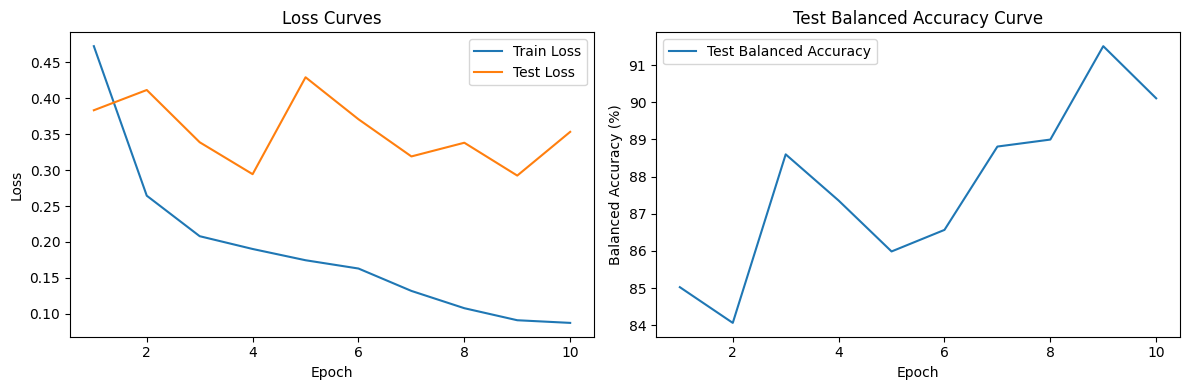

Script finished.


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio
from torchaudio import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

# Load and Prepare Metadata
try:
    metadata_full = pd.read_csv("recordings/metadata_wav.csv")
except FileNotFoundError:
    print("Error: 'recordings/metadata_wav.csv' not found. Please ensure the file exists.")
    raise

metadata_full.dropna(subset=['wav_path'], inplace=True)
metadata_full['is_english'] = metadata_full['native_language'].apply(
    lambda x: 1 if isinstance(x, str) and 'english' in x.lower() else 0
).astype(int)

print("Full dataset class distribution:")
print(metadata_full['is_english'].value_counts())
print(f"Total samples in full dataset: {len(metadata_full)}")

class SpeechAccentDataset(Dataset):
    def __init__(self, metadata_df, feature_extractor, target_sample_rate=16000, max_length_seconds=10):
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.target_sample_rate = target_sample_rate
        self.max_samples = target_sample_rate * max_length_seconds

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        file_path = row['wav_path']
        label = row['is_english']
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"Warning: Error loading file {file_path}: {e}. Returning dummy sample.")
            return {'input_values': torch.zeros(self.max_samples), 'label': torch.tensor(-1, dtype=torch.long)}
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sample_rate != self.target_sample_rate:
            waveform = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)
        waveform = waveform.squeeze(0)
        current_length = waveform.shape[0]
        if current_length > self.max_samples: waveform = waveform[:self.max_samples]
        elif current_length < self.max_samples:
            waveform = torch.nn.functional.pad(waveform, (0, self.max_samples - current_length))
        processed = self.feature_extractor(
            waveform.numpy(), sampling_rate=self.target_sample_rate, return_tensors="pt",
            padding="max_length", max_length=self.max_samples, truncation=True
        )
        return {'input_values': processed.input_values.squeeze(0), 'label': torch.tensor(label, dtype=torch.long)}

class Wav2VecClassifier(nn.Module):
    def __init__(self, num_classes=2, model_name="facebook/wav2vec2-base", num_layers_to_unfreeze=2):
        super(Wav2VecClassifier, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(model_name)

        for param in self.wav2vec.parameters():
            param.requires_grad = False

        if hasattr(self.wav2vec, 'feature_projector') and self.wav2vec.feature_projector is not None:
            for param in self.wav2vec.feature_projector.parameters():
                param.requires_grad = True
            print("Unfroze Wav2Vec2 feature_projector.")

        if hasattr(self.wav2vec, 'encoder') and hasattr(self.wav2vec.encoder, 'layers') and num_layers_to_unfreeze > 0:
            num_total_layers = len(self.wav2vec.encoder.layers)
            start_layer_idx = num_total_layers - num_layers_to_unfreeze
            actual_unfrozen_count = 0
            for i in range(max(0, start_layer_idx), num_total_layers):
                for param in self.wav2vec.encoder.layers[i].parameters():
                    param.requires_grad = True
                actual_unfrozen_count +=1
            print(f"Unfroze the last {actual_unfrozen_count} Wav2Vec2 transformer layers.")
        elif num_layers_to_unfreeze > 0:
            print("Could not unfreeze transformer layers: structure not as expected.")

        self.classifier = nn.Sequential(
            nn.Linear(self.wav2vec.config.hidden_size, 256),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_values):
        if input_values.ndim == 1: input_values = input_values.unsqueeze(0)
        outputs = self.wav2vec(input_values).last_hidden_state
        embeddings = torch.mean(outputs, dim=1)
        logits = self.classifier(embeddings)
        return logits

hf_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")

train_df, test_df = train_test_split(
    metadata_full,
    test_size=0.20,
    random_state=42,
    stratify=metadata_full['is_english'] if len(metadata_full['is_english'].unique()) > 1 else None
)

print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")

train_dataset = SpeechAccentDataset(train_df, hf_feature_extractor)
test_dataset = SpeechAccentDataset(test_df, hf_feature_extractor)

sampler = None
class_weights_tensor = None
if not train_df.empty and 'is_english' in train_df.columns:
    train_class_counts = train_df['is_english'].value_counts().sort_index()
    print(f"Training set class distribution (full data split): {train_class_counts}")
    if len(train_class_counts) == 2:
        # WeightedRandomSampler weights
        weight_per_class = 1. / train_class_counts.values
        sample_weights_val = train_df['is_english'].map(lambda x: weight_per_class[x]).to_numpy()
        sample_weights = torch.from_numpy(sample_weights_val).double()
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler for training.")

        # CrossEntropyLoss weights
        class_weights_list = [len(train_df) / count if count > 0 else 0 for count in train_class_counts]

        total_weight_sum = sum(class_weights_list)
        if total_weight_sum > 0:
             class_weights_list = [w / total_weight_sum * len(train_class_counts) for w in class_weights_list]
        class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float32)
        print(f"Calculated class weights for CrossEntropyLoss: {class_weights_tensor}")
    else: print("Warning: Not enough classes in training set for weighting/sampling.")
else: print("Warning: train_df is empty or 'is_english' column missing.")


BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False if sampler else True, num_workers=2, pin_memory=True if torch.cuda.is_available() else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True if torch.cuda.is_available() else False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = Wav2VecClassifier(num_layers_to_unfreeze=2).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device) if class_weights_tensor is not None and device.type == 'cuda' else class_weights_tensor)
print(f"Using {'weighted' if class_weights_tensor is not None else 'unweighted'} CrossEntropyLoss.")
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)

NUM_EPOCHS = 10
best_val_metric = 0.0
train_losses, test_losses, test_bal_accuracies = [], [], []

print(f"\nStarting training on FULL dataset for {NUM_EPOCHS} epochs (fine-tuning)...")
for epoch in range(NUM_EPOCHS):
    model.train()
    current_train_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for batch in train_iterator:
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item()})
    avg_train_loss = current_train_loss / len(train_loader) if len(train_loader) > 0 else 0
    train_losses.append(avg_train_loss)

    model.eval()
    current_test_loss = 0.0
    all_epoch_preds, all_epoch_labels = [], []
    test_iterator = tqdm(test_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Test]')
    with torch.no_grad():
        for batch in test_iterator:
            if batch['label'][0] == -1: continue
            input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
            outputs = model(input_values)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_epoch_preds.extend(predicted.cpu().numpy())
            all_epoch_labels.extend(labels.cpu().numpy())
    avg_test_loss = current_test_loss / len(test_loader) if len(test_loader) > 0 else 0
    current_bal_accuracy = balanced_accuracy_score(all_epoch_labels, all_epoch_preds) * 100 if all_epoch_labels and all_epoch_preds else 0
    test_losses.append(avg_test_loss)
    test_bal_accuracies.append(current_bal_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Bal. Acc: {current_bal_accuracy:.2f}%")
    if all_epoch_labels and all_epoch_preds:
        try: print(classification_report(all_epoch_labels, all_epoch_preds, target_names=['Non-English', 'English'], zero_division=0))
        except ValueError as e: print(f"Report error: {e}")

    if current_bal_accuracy > best_val_metric:
        best_val_metric = current_bal_accuracy
        torch.save(model.state_dict(), 'best_english_classifier_full_data_finetuned.pt')
        print(f"  New best model saved (Bal. Acc: {best_val_metric:.2f}%)")
print("\nTraining finished.")

model_save_path = 'best_english_classifier_full_data_finetuned.pt'
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f"\nLoaded best model from {model_save_path} for final evaluation.")
else:
    print(f"\nWarning: Saved model {model_save_path} not found. Evaluating current model state.")

model.eval()
final_all_preds, final_all_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Final Evaluation'):
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        outputs = model(input_values)
        _, predicted = torch.max(outputs.data, 1)
        final_all_preds.extend(predicted.cpu().numpy())
        final_all_labels.extend(labels.cpu().numpy())

if final_all_labels and final_all_preds:
    print("\nFinal Classification Report (Test Set from Full Data):")
    try:
        print(classification_report(final_all_labels, final_all_preds, target_names=['Non-English', 'English'], zero_division=0))
        print(f"Final Balanced Accuracy: {balanced_accuracy_score(final_all_labels, final_all_preds) * 100:.2f}%")
    except ValueError as e: print(f"Final report error: {e}")
else: print("No data/predictions for final report.")

# Plot Training Curves
if NUM_EPOCHS > 0 :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1); plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss'); plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')
    plt.subplot(1, 2, 2); plt.plot(range(1, NUM_EPOCHS + 1), test_bal_accuracies, label='Test Balanced Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Balanced Accuracy (%)'); plt.legend(); plt.title('Test Balanced Accuracy Curve')
    plt.tight_layout(); plt.savefig('training_curves_full_data_finetuned.png'); plt.show()
print("Script finished.")

Full dataset class distribution:
is_english
0    1559
1     579
Name: count, dtype: int64
Total samples in full dataset: 2138
Training set size: 1710, Test set size: 428
Training set class distribution: is_english
0    1247
1     463
Name: count, dtype: int64
Using WeightedRandomSampler for training.
Calculated class weights for CrossEntropyLoss: tensor([0.5415, 1.4585])
Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Unfroze the last 2 Wav2Vec2 transformer layers.
Using weighted CrossEntropyLoss.

Starting training for 10 epochs...


Epoch 1/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 1/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1/10: Train Loss: 0.4658, Test Loss: 0.4993, Test Bal. Acc: 83.11%
              precision    recall  f1-score   support

 Non-English       0.99      0.68      0.81       312
     English       0.53      0.98      0.69       116

    accuracy                           0.76       428
   macro avg       0.76      0.83      0.75       428
weighted avg       0.87      0.76      0.77       428

  New best model saved (Bal. Acc: 83.11%)


Epoch 2/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 2/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2/10: Train Loss: 0.2357, Test Loss: 0.3584, Test Bal. Acc: 86.09%
              precision    recall  f1-score   support

 Non-English       0.97      0.78      0.87       312
     English       0.62      0.94      0.74       116

    accuracy                           0.82       428
   macro avg       0.79      0.86      0.81       428
weighted avg       0.88      0.82      0.83       428

  New best model saved (Bal. Acc: 86.09%)


Epoch 3/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 3/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3/10: Train Loss: 0.2188, Test Loss: 0.2536, Test Bal. Acc: 90.12%
              precision    recall  f1-score   support

 Non-English       0.95      0.92      0.94       312
     English       0.81      0.88      0.84       116

    accuracy                           0.91       428
   macro avg       0.88      0.90      0.89       428
weighted avg       0.91      0.91      0.91       428

  New best model saved (Bal. Acc: 90.12%)


Epoch 4/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 4/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4/10: Train Loss: 0.1797, Test Loss: 0.4835, Test Bal. Acc: 85.07%
              precision    recall  f1-score   support

 Non-English       0.98      0.75      0.85       312
     English       0.59      0.95      0.73       116

    accuracy                           0.81       428
   macro avg       0.78      0.85      0.79       428
weighted avg       0.87      0.81      0.82       428



Epoch 5/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 5/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5/10: Train Loss: 0.1620, Test Loss: 0.2985, Test Bal. Acc: 89.92%
              precision    recall  f1-score   support

 Non-English       0.97      0.88      0.92       312
     English       0.75      0.91      0.82       116

    accuracy                           0.89       428
   macro avg       0.86      0.90      0.87       428
weighted avg       0.91      0.89      0.90       428



Epoch 6/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 6/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6/10: Train Loss: 0.1524, Test Loss: 0.4634, Test Bal. Acc: 86.36%
              precision    recall  f1-score   support

 Non-English       0.98      0.78      0.87       312
     English       0.61      0.95      0.75       116

    accuracy                           0.82       428
   macro avg       0.80      0.86      0.81       428
weighted avg       0.88      0.82      0.83       428



Epoch 7/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 7/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7/10: Train Loss: 0.1437, Test Loss: 0.3372, Test Bal. Acc: 87.57%
              precision    recall  f1-score   support

 Non-English       0.96      0.85      0.90       312
     English       0.69      0.91      0.78       116

    accuracy                           0.86       428
   macro avg       0.82      0.88      0.84       428
weighted avg       0.89      0.86      0.87       428



Epoch 8/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 8/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8/10: Train Loss: 0.1203, Test Loss: 0.4908, Test Bal. Acc: 86.20%
              precision    recall  f1-score   support

 Non-English       0.98      0.78      0.86       312
     English       0.61      0.95      0.74       116

    accuracy                           0.82       428
   macro avg       0.79      0.86      0.80       428
weighted avg       0.88      0.82      0.83       428



Epoch 9/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 9/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9/10: Train Loss: 0.1274, Test Loss: 0.3106, Test Bal. Acc: 89.66%
              precision    recall  f1-score   support

 Non-English       0.97      0.86      0.91       312
     English       0.72      0.93      0.81       116

    accuracy                           0.88       428
   macro avg       0.84      0.90      0.86       428
weighted avg       0.90      0.88      0.89       428



Epoch 10/10 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 10/10 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10/10: Train Loss: 0.1062, Test Loss: 0.3247, Test Bal. Acc: 88.86%
              precision    recall  f1-score   support

 Non-English       0.93      0.96      0.95       312
     English       0.88      0.82      0.85       116

    accuracy                           0.92       428
   macro avg       0.91      0.89      0.90       428
weighted avg       0.92      0.92      0.92       428


Training finished.

Loaded best model from best_english_classifier_concise.pt for final evaluation.


Final Evaluation:   0%|          | 0/54 [00:00<?, ?it/s]


Final Classification Report (Test Set from Full Data):
              precision    recall  f1-score   support

 Non-English       0.95      0.92      0.94       312
     English       0.81      0.88      0.84       116

    accuracy                           0.91       428
   macro avg       0.88      0.90      0.89       428
weighted avg       0.91      0.91      0.91       428

Final Balanced Accuracy: 90.12%


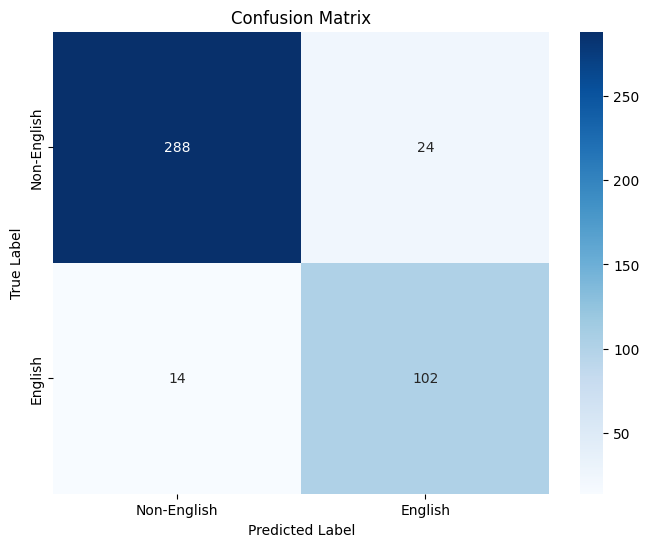

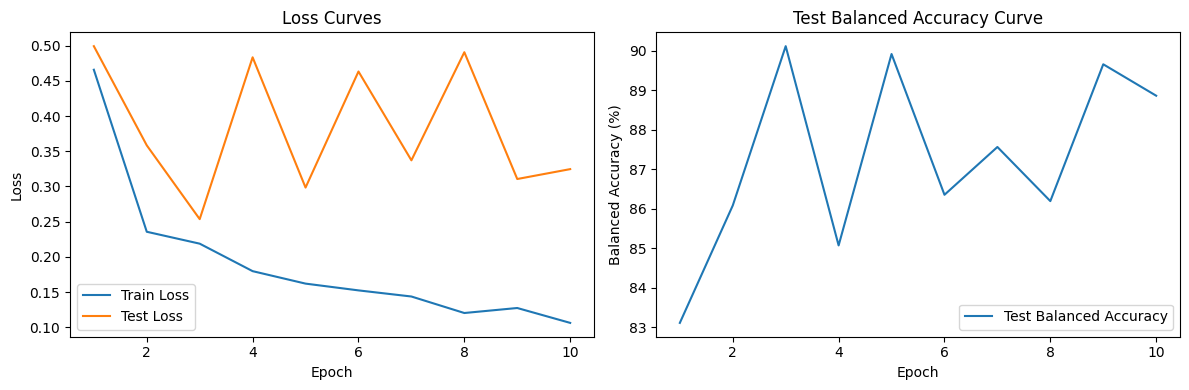

Script finished.


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio
from torchaudio import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

metadata_full = pd.read_csv("recordings/metadata_wav.csv")
metadata_full.dropna(subset=['wav_path'], inplace=True)
metadata_full['is_english'] = metadata_full['native_language'].apply(
    lambda x: 1 if isinstance(x, str) and 'english' in x.lower() else 0
).astype(int)
print(f"Full dataset class distribution:\n{metadata_full['is_english'].value_counts()}")
print(f"Total samples in full dataset: {len(metadata_full)}")

class SpeechAccentDataset(Dataset):
    def __init__(self, metadata_df, feature_extractor, target_sample_rate=16000, max_length_seconds=10):
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.target_sample_rate = target_sample_rate
        self.max_samples = target_sample_rate * max_length_seconds

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        file_path = row['wav_path']
        label = row['is_english']
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception:
            return {'input_values': torch.zeros(self.max_samples), 'label': torch.tensor(-1, dtype=torch.long)}
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sample_rate != self.target_sample_rate:
            waveform = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)
        waveform = waveform.squeeze(0)
        current_length = waveform.shape[0]
        if current_length > self.max_samples: waveform = waveform[:self.max_samples]
        elif current_length < self.max_samples:
            waveform = torch.nn.functional.pad(waveform, (0, self.max_samples - current_length))
        processed = self.feature_extractor(
            waveform.numpy(), sampling_rate=self.target_sample_rate, return_tensors="pt",
            padding="max_length", max_length=self.max_samples, truncation=True
        )
        return {'input_values': processed.input_values.squeeze(0), 'label': torch.tensor(label, dtype=torch.long)}

class Wav2VecClassifier(nn.Module):
    def __init__(self, num_classes=2, model_name="facebook/wav2vec2-base", num_layers_to_unfreeze=2):
        super(Wav2VecClassifier, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(model_name)
        for param in self.wav2vec.parameters(): param.requires_grad = False

        if hasattr(self.wav2vec, 'feature_projector') and self.wav2vec.feature_projector is not None:
            for param in self.wav2vec.feature_projector.parameters():
                param.requires_grad = True
            print("Unfroze Wav2Vec2 feature_projector.")
        if hasattr(self.wav2vec, 'encoder') and hasattr(self.wav2vec.encoder, 'layers') and num_layers_to_unfreeze > 0:
            num_total_layers = len(self.wav2vec.encoder.layers)
            start_layer_idx = num_total_layers - num_layers_to_unfreeze
            actual_unfrozen_count = 0
            for i in range(max(0, start_layer_idx), num_total_layers):
                for param in self.wav2vec.encoder.layers[i].parameters():
                    param.requires_grad = True
                actual_unfrozen_count +=1
            print(f"Unfroze the last {actual_unfrozen_count} Wav2Vec2 transformer layers.")

        self.classifier = nn.Sequential(
            nn.Linear(self.wav2vec.config.hidden_size, 256),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, input_values):
        if input_values.ndim == 1: input_values = input_values.unsqueeze(0)
        outputs = self.wav2vec(input_values).last_hidden_state
        embeddings = torch.mean(outputs, dim=1)
        return self.classifier(embeddings)

hf_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
train_df, test_df = train_test_split(
    metadata_full, test_size=0.20, random_state=42,
    stratify=metadata_full['is_english'] if len(metadata_full['is_english'].unique()) > 1 else None
)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")
train_dataset = SpeechAccentDataset(train_df, hf_feature_extractor)
test_dataset = SpeechAccentDataset(test_df, hf_feature_extractor)

sampler = None
class_weights_tensor = None
if not train_df.empty:
    train_class_counts = train_df['is_english'].value_counts().sort_index()
    print(f"Training set class distribution: {train_class_counts}")
    if len(train_class_counts) == 2:
        weight_per_class = 1. / train_class_counts.values
        sample_weights_val = train_df['is_english'].map(lambda x: weight_per_class[x]).to_numpy()
        sample_weights = torch.from_numpy(sample_weights_val).double()
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler for training.")
        class_weights_list = [len(train_df) / count if count > 0 else 0 for count in train_class_counts]
        total_weight_sum = sum(class_weights_list)
        if total_weight_sum > 0: class_weights_list = [w / total_weight_sum * len(train_class_counts) for w in class_weights_list]
        class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float32)
        print(f"Calculated class weights for CrossEntropyLoss: {class_weights_tensor}")

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False if sampler else True, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = Wav2VecClassifier(num_layers_to_unfreeze=2).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None)
print(f"Using {'weighted' if class_weights_tensor is not None else 'unweighted'} CrossEntropyLoss.")
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)

NUM_EPOCHS = 10
best_val_metric = 0.0
train_losses, test_losses, test_bal_accuracies = [], [], []
model_save_path = 'best_english_classifier_concise.pt'

print(f"\nStarting training for {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    model.train()
    current_train_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for batch in train_iterator:
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item()})
    avg_train_loss = current_train_loss / len(train_loader) if len(train_loader) > 0 else 0
    train_losses.append(avg_train_loss)

    model.eval()
    current_test_loss = 0.0
    all_epoch_preds, all_epoch_labels = [], []
    test_iterator = tqdm(test_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Test]')
    with torch.no_grad():
        for batch in test_iterator:
            if batch['label'][0] == -1: continue
            input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
            outputs = model(input_values)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_epoch_preds.extend(predicted.cpu().numpy())
            all_epoch_labels.extend(labels.cpu().numpy())
    avg_test_loss = current_test_loss / len(test_loader) if len(test_loader) > 0 else 0
    current_bal_accuracy = balanced_accuracy_score(all_epoch_labels, all_epoch_preds) * 100 if all_epoch_labels and all_epoch_preds else 0
    test_losses.append(avg_test_loss)
    test_bal_accuracies.append(current_bal_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Bal. Acc: {current_bal_accuracy:.2f}%")
    if all_epoch_labels and all_epoch_preds:
        print(classification_report(all_epoch_labels, all_epoch_preds, target_names=['Non-English', 'English'], zero_division=0))

    if current_bal_accuracy > best_val_metric:
        best_val_metric = current_bal_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"  New best model saved (Bal. Acc: {best_val_metric:.2f}%)")
print("\nTraining finished.")

if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f"\nLoaded best model from {model_save_path} for final evaluation.")
else:
    print(f"\nWarning: Saved model {model_save_path} not found. Evaluating current model state.")

model.eval()
final_all_preds, final_all_labels = [], []
actual_epochs_run = len(train_losses)

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Final Evaluation'):
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        outputs = model(input_values)
        _, predicted = torch.max(outputs.data, 1)
        final_all_preds.extend(predicted.cpu().numpy())
        final_all_labels.extend(labels.cpu().numpy())

if final_all_labels and final_all_preds:
    print("\nFinal Classification Report (Test Set from Full Data):")
    print(classification_report(final_all_labels, final_all_preds, target_names=['Non-English', 'English'], zero_division=0))
    final_bal_acc = balanced_accuracy_score(final_all_labels, final_all_preds) * 100
    print(f"Final Balanced Accuracy: {final_bal_acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(final_all_labels, final_all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-English', 'English'],
                yticklabels=['Non-English', 'English'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix_concise_best.png')
    plt.show()
else:
    print("No data/predictions for final report and confusion matrix.")

if actual_epochs_run > 0 :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, actual_epochs_run + 1), train_losses, label='Train Loss')
    plt.plot(range(1, actual_epochs_run + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, actual_epochs_run + 1), test_bal_accuracies, label='Test Balanced Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Balanced Accuracy (%)'); plt.legend(); plt.title('Test Balanced Accuracy Curve')

    plt.tight_layout()
    plt.savefig('training_curves_concise_best.png')
    plt.show()
print("Script finished.")

In [ ]:
# import os
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
# import torchaudio
# from torchaudio import transforms as T
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, balanced_accuracy_score
# import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm
# from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

# # --- 1. Load and Prepare Metadata ---
# try:
#     metadata_full = pd.read_csv("recordings/metadata_wav.csv")
# except FileNotFoundError:
#     print("Error: 'recordings/metadata_wav.csv' not found. Please ensure the file exists.")
#     raise

# metadata_full.dropna(subset=['wav_path'], inplace=True)
# metadata_full['is_english'] = metadata_full['native_language'].apply(
#     lambda x: 1 if isinstance(x, str) and 'english' in x.lower() else 0
# ).astype(int)

# print("Full dataset class distribution:")
# print(metadata_full['is_english'].value_counts())

# # --- 2. Create a Small Subset for Testing ---
# subset_size = 200 # Keeping this size for debugging fine-tuning
# if len(metadata_full) > subset_size:
#     if len(metadata_full['is_english'].unique()) > 1:
#         metadata_subset, _ = train_test_split(
#             metadata_full,
#             train_size=subset_size,
#             random_state=42,
#             stratify=metadata_full['is_english']
#         )
#     else:
#         metadata_subset = metadata_full.sample(n=subset_size, random_state=42)
#     print(f"\nUsing a subset of {len(metadata_subset)} samples for testing fine-tuning.")
# else:
#     metadata_subset = metadata_full
#     print(f"\nUsing the full dataset of {len(metadata_subset)} samples.")

# print("Subset class distribution:")
# print(metadata_subset['is_english'].value_counts())

# # --- 3. Custom Dataset ---
# class SpeechAccentDataset(Dataset):
#     def __init__(self, metadata_df, feature_extractor, target_sample_rate=16000, max_length_seconds=10):
#         self.metadata_df = metadata_df.reset_index(drop=True)
#         self.feature_extractor = feature_extractor
#         self.target_sample_rate = target_sample_rate
#         self.max_samples = target_sample_rate * max_length_seconds

#     def __len__(self):
#         return len(self.metadata_df)

#     def __getitem__(self, idx):
#         row = self.metadata_df.iloc[idx]
#         file_path = row['wav_path']
#         label = row['is_english']
#         try:
#             waveform, sample_rate = torchaudio.load(file_path)
#         except Exception as e:
#             print(f"Warning: Error loading file {file_path}: {e}. Returning dummy sample.")
#             return {'input_values': torch.zeros(self.max_samples), 'label': torch.tensor(-1, dtype=torch.long)}
#         if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
#         if sample_rate != self.target_sample_rate:
#             waveform = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)
#         waveform = waveform.squeeze(0)
#         current_length = waveform.shape[0]
#         if current_length > self.max_samples: waveform = waveform[:self.max_samples]
#         elif current_length < self.max_samples:
#             waveform = torch.nn.functional.pad(waveform, (0, self.max_samples - current_length))
#         processed = self.feature_extractor(
#             waveform.numpy(), sampling_rate=self.target_sample_rate, return_tensors="pt",
#             padding="max_length", max_length=self.max_samples, truncation=True
#         )
#         return {'input_values': processed.input_values.squeeze(0), 'label': torch.tensor(label, dtype=torch.long)}

# # --- 4. Classifier Model (Wav2Vec2 with Fine-Tuning) ---
# class Wav2VecClassifier(nn.Module):
#     def __init__(self, num_classes=2, model_name="facebook/wav2vec2-base", num_layers_to_unfreeze=2):
#         super(Wav2VecClassifier, self).__init__()
#         self.wav2vec = Wav2Vec2Model.from_pretrained(model_name)

#         # Freeze all parameters initially
#         for param in self.wav2vec.parameters():
#             param.requires_grad = False

#         # Unfreeze the feature_projector (adapts CNN output to Transformer input)
#         if hasattr(self.wav2vec, 'feature_projector') and self.wav2vec.feature_projector is not None:
#             for param in self.wav2vec.feature_projector.parameters():
#                 param.requires_grad = True
#             print("Unfroze Wav2Vec2 feature_projector.")

#         # Unfreeze the last N transformer layers
#         if hasattr(self.wav2vec, 'encoder') and hasattr(self.wav2vec.encoder, 'layers') and num_layers_to_unfreeze > 0:
#             num_total_layers = len(self.wav2vec.encoder.layers)
#             for i in range(num_total_layers - num_layers_to_unfreeze, num_total_layers):
#                 if i >= 0 : # Make sure index is valid
#                     for param in self.wav2vec.encoder.layers[i].parameters():
#                         param.requires_grad = True
#             print(f"Unfroze the last {min(num_layers_to_unfreeze, num_total_layers)} Wav2Vec2 transformer layers.")
#         elif num_layers_to_unfreeze > 0:
#             print("Could not unfreeze transformer layers: encoder or layers not found as expected.")


#         self.classifier = nn.Sequential(
#             nn.Linear(self.wav2vec.config.hidden_size, 256),
#             nn.ReLU(), nn.Dropout(0.2),
#             nn.Linear(256, num_classes)
#         )
#         # Classifier parameters are trainable by default

#     def forward(self, input_values):
#         if input_values.ndim == 1: input_values = input_values.unsqueeze(0)
#         outputs = self.wav2vec(input_values).last_hidden_state
#         embeddings = torch.mean(outputs, dim=1)
#         logits = self.classifier(embeddings)
#         return logits

# # --- 5. Setup DataLoaders, Model, Loss, Optimizer ---
# hf_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")

# train_df, test_df = train_test_split(
#     metadata_subset, test_size=0.25, random_state=42,
#     stratify=metadata_subset['is_english'] if len(metadata_subset['is_english'].unique()) > 1 else None
# )

# if len(train_df) == 0 or len(test_df) == 0: # Basic fallback
#     print("Warning: Train or test DataFrame is empty after split. Using 75/25 split of available data.")
#     train_df = metadata_subset.sample(frac=0.75, random_state=42) if not metadata_subset.empty else pd.DataFrame()
#     test_df = metadata_subset.drop(train_df.index) if not train_df.empty else pd.DataFrame()

# train_dataset = SpeechAccentDataset(train_df, hf_feature_extractor)
# test_dataset = SpeechAccentDataset(test_df, hf_feature_extractor)

# sampler = None
# class_weights_tensor = None
# if not train_df.empty and 'is_english' in train_df.columns:
#     train_class_counts = train_df['is_english'].value_counts().sort_index()
#     print(f"Training set class distribution: {train_class_counts}")
#     if len(train_class_counts) == 2:
#         weight = 1. / train_class_counts.values
#         sample_weights_val = train_df['is_english'].map(lambda x: weight[x]).to_numpy()
#         sample_weights = torch.from_numpy(sample_weights_val).double()
#         sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
#         print("Using WeightedRandomSampler for training.")
#         class_weights_list = [1.0 / count if count > 0 else 0.0 for count in train_class_counts]
#         total_inv_freq = sum(class_weights_list)
#         if total_inv_freq > 0: class_weights_list = [w / total_inv_freq * len(train_class_counts) for w in class_weights_list]
#         class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float32)
#         print(f"Calculated class weights for CrossEntropyLoss: {class_weights_tensor}")

# BATCH_SIZE = 8 # GPU can likely handle this, adjust if OOM
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False if sampler else True, num_workers=2) # num_workers=2 for GPU
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# model = Wav2VecClassifier(num_layers_to_unfreeze=2).to(device) # Unfreeze last 2 layers
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None)
# print(f"Using {'weighted' if class_weights_tensor is not None else 'unweighted'} CrossEntropyLoss.")
# # Learning rate suitable for fine-tuning
# optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)

# # --- 6. Training Loop ---
# NUM_EPOCHS = 5 # Keep low for initial fine-tuning test
# best_val_metric = 0.0
# train_losses, test_losses, test_bal_accuracies = [], [], []

# print(f"\nStarting training for {NUM_EPOCHS} epochs (fine-tuning)...")
# for epoch in range(NUM_EPOCHS):
#     model.train()
#     current_train_loss = 0.0
#     train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
#     for batch in train_iterator:
#         if batch['label'][0] == -1: continue
#         input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
#         optimizer.zero_grad()
#         outputs = model(input_values)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         current_train_loss += loss.item()
#         train_iterator.set_postfix({'loss': loss.item()})
#     avg_train_loss = current_train_loss / len(train_loader) if len(train_loader) > 0 else 0
#     train_losses.append(avg_train_loss)

#     model.eval()
#     current_test_loss = 0.0
#     all_epoch_preds, all_epoch_labels = [], []
#     test_iterator = tqdm(test_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Test]')
#     with torch.no_grad():
#         for batch in test_iterator:
#             if batch['label'][0] == -1: continue
#             input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
#             outputs = model(input_values)
#             loss = criterion(outputs, labels)
#             current_test_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             all_epoch_preds.extend(predicted.cpu().numpy())
#             all_epoch_labels.extend(labels.cpu().numpy())
#     avg_test_loss = current_test_loss / len(test_loader) if len(test_loader) > 0 else 0
#     current_bal_accuracy = balanced_accuracy_score(all_epoch_labels, all_epoch_preds) * 100 if all_epoch_labels and all_epoch_preds else 0
#     test_losses.append(avg_test_loss)
#     test_bal_accuracies.append(current_bal_accuracy)

#     print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Bal. Acc: {current_bal_accuracy:.2f}%")
#     if all_epoch_labels and all_epoch_preds:
#         try: print(classification_report(all_epoch_labels, all_epoch_preds, target_names=['Non-English', 'English'], zero_division=0))
#         except ValueError as e: print(f"Report error: {e}")

#     if current_bal_accuracy > best_val_metric:
#         best_val_metric = current_bal_accuracy
#         torch.save(model.state_dict(), 'best_english_classifier_finetuned.pt')
#         print(f"  New best model saved (Bal. Acc: {best_val_metric:.2f}%)")
# print("\nTraining finished.")

# # --- 7. Final Evaluation & Reporting ---
# if os.path.exists('best_english_classifier_finetuned.pt'):
#     model.load_state_dict(torch.load('best_english_classifier_finetuned.pt', map_location=device))
# print("\nLoaded best model for final evaluation.")
# model.eval()
# final_all_preds, final_all_labels = [], []
# with torch.no_grad():
#     for batch in tqdm(test_loader, desc='Final Evaluation'):
#         if batch['label'][0] == -1: continue
#         input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
#         outputs = model(input_values)
#         _, predicted = torch.max(outputs.data, 1)
#         final_all_preds.extend(predicted.cpu().numpy())
#         final_all_labels.extend(labels.cpu().numpy())

# if final_all_labels and final_all_preds:
#     print("\nFinal Classification Report (Test Subset):")
#     try:
#         print(classification_report(final_all_labels, final_all_preds, target_names=['Non-English', 'English'], zero_division=0))
#         print(f"Final Balanced Accuracy: {balanced_accuracy_score(final_all_labels, final_all_preds) * 100:.2f}%")
#     except ValueError as e: print(f"Final report error: {e}")
# else: print("No data/predictions for final report.")

# # --- 8. Plot Training Curves ---
# if NUM_EPOCHS > 0 :
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1); plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss'); plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')
#     plt.subplot(1, 2, 2); plt.plot(range(1, NUM_EPOCHS + 1), test_bal_accuracies, label='Test Balanced Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Balanced Accuracy (%)'); plt.legend(); plt.title('Test Balanced Accuracy Curve')
#     plt.tight_layout(); plt.savefig('training_curves_finetuned.png'); plt.show()
# print("Script finished.")

Full dataset class distribution:
is_english
0    1559
1     579
Name: count, dtype: int64
Total samples in full dataset: 2138
Training set size: 1710, Test set size: 428
Training set class distribution: is_english
0    1247
1     463
Name: count, dtype: int64
Using WeightedRandomSampler for training.
Calculated class weights for CrossEntropyLoss: tensor([0.5415, 1.4585])
Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Unfroze the last 2 Wav2Vec2 transformer layers.
Using weighted CrossEntropyLoss.

Starting training on FULL dataset for up to 15 epochs (fine-tuning)...


Epoch 1/15 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 1/15 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1/15: Train Loss: 0.4458, Test Loss: 0.3370, Test Bal. Acc: 86.73%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.97      0.79      0.87       312
     English       0.63      0.94      0.75       116

    accuracy                           0.83       428
   macro avg       0.80      0.87      0.81       428
weighted avg       0.88      0.83      0.84       428

  New best model saved (Bal. Acc: 86.73%)


Epoch 2/15 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 2/15 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2/15: Train Loss: 0.2369, Test Loss: 0.4923, Test Bal. Acc: 85.30%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.98      0.74      0.84       312
     English       0.58      0.97      0.72       116

    accuracy                           0.80       428
   macro avg       0.78      0.85      0.78       428
weighted avg       0.87      0.80      0.81       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 86.73%


Epoch 3/15 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 3/15 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3/15: Train Loss: 0.2076, Test Loss: 0.2633, Test Bal. Acc: 89.81%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.96      0.89      0.93       312
     English       0.76      0.91      0.82       116

    accuracy                           0.89       428
   macro avg       0.86      0.90      0.87       428
weighted avg       0.91      0.89      0.90       428

  New best model saved (Bal. Acc: 89.81%)


Epoch 4/15 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 4/15 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4/15: Train Loss: 0.1881, Test Loss: 0.2758, Test Bal. Acc: 88.85%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.96      0.87      0.91       312
     English       0.72      0.91      0.80       116

    accuracy                           0.88       428
   macro avg       0.84      0.89      0.86       428
weighted avg       0.90      0.88      0.88       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 89.81%


Epoch 5/15 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 5/15 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5/15: Train Loss: 0.1933, Test Loss: 0.3463, Test Bal. Acc: 87.15%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.97      0.82      0.89       312
     English       0.66      0.92      0.77       116

    accuracy                           0.85       428
   macro avg       0.81      0.87      0.83       428
weighted avg       0.88      0.85      0.85       428

  No improvement in val balanced accuracy for 2 epoch(s). Best: 89.81%


Epoch 6/15 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 6/15 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6/15: Train Loss: 0.1469, Test Loss: 0.2709, Test Bal. Acc: 89.58%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.95      0.93      0.94       312
     English       0.82      0.86      0.84       116

    accuracy                           0.91       428
   macro avg       0.88      0.90      0.89       428
weighted avg       0.91      0.91      0.91       428

  No improvement in val balanced accuracy for 3 epoch(s). Best: 89.81%


Epoch 7/15 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 7/15 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7/15: Train Loss: 0.1091, Test Loss: 0.3019, Test Bal. Acc: 89.55%, LR: 3.0e-06
              precision    recall  f1-score   support

 Non-English       0.97      0.87      0.92       312
     English       0.72      0.92      0.81       116

    accuracy                           0.88       428
   macro avg       0.85      0.90      0.86       428
weighted avg       0.90      0.88      0.89       428

  No improvement in val balanced accuracy for 4 epoch(s). Best: 89.81%
Early stopping triggered after 7 epochs due to no improvement for 4 epochs.

Training finished.

Loaded best model from best_english_classifier_full_data_finetuned_v2.pt for final evaluation.


Final Evaluation:   0%|          | 0/54 [00:00<?, ?it/s]


Final Classification Report (Test Set from Full Data):
              precision    recall  f1-score   support

 Non-English       0.96      0.89      0.93       312
     English       0.76      0.91      0.82       116

    accuracy                           0.89       428
   macro avg       0.86      0.90      0.87       428
weighted avg       0.91      0.89      0.90       428

Final Balanced Accuracy: 89.81%


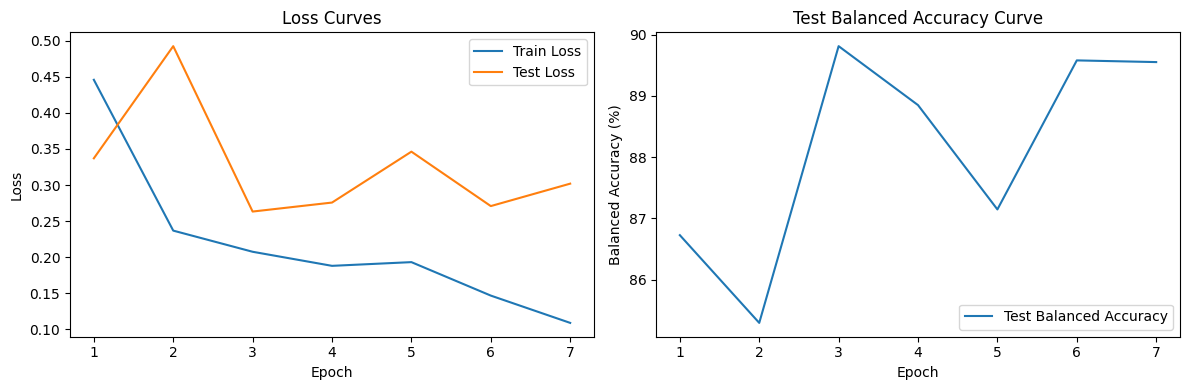

Script finished.


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchaudio
from torchaudio import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

try:
    metadata_full = pd.read_csv("recordings/metadata_wav.csv")
except FileNotFoundError:
    print("Error: 'recordings/metadata_wav.csv' not found. Please ensure the file exists.")
    raise

metadata_full.dropna(subset=['wav_path'], inplace=True)
metadata_full['is_english'] = metadata_full['native_language'].apply(
    lambda x: 1 if isinstance(x, str) and 'english' in x.lower() else 0
).astype(int)

print("Full dataset class distribution:")
print(metadata_full['is_english'].value_counts())
print(f"Total samples in full dataset: {len(metadata_full)}")

class SpeechAccentDataset(Dataset):
    def __init__(self, metadata_df, feature_extractor, target_sample_rate=16000, max_length_seconds=10):
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.target_sample_rate = target_sample_rate
        self.max_samples = target_sample_rate * max_length_seconds

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        file_path = row['wav_path']
        label = row['is_english']
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"Warning: Error loading file {file_path}: {e}. Returning dummy sample.")
            return {'input_values': torch.zeros(self.max_samples), 'label': torch.tensor(-1, dtype=torch.long)}
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sample_rate != self.target_sample_rate:
            waveform = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)
        waveform = waveform.squeeze(0)
        current_length = waveform.shape[0]
        if current_length > self.max_samples: waveform = waveform[:self.max_samples]
        elif current_length < self.max_samples:
            waveform = torch.nn.functional.pad(waveform, (0, self.max_samples - current_length))
        processed = self.feature_extractor(
            waveform.numpy(), sampling_rate=self.target_sample_rate, return_tensors="pt",
            padding="max_length", max_length=self.max_samples, truncation=True
        )
        return {'input_values': processed.input_values.squeeze(0), 'label': torch.tensor(label, dtype=torch.long)}

class Wav2VecClassifier(nn.Module):
    def __init__(self, num_classes=2, model_name="facebook/wav2vec2-base", num_layers_to_unfreeze=2):
        super(Wav2VecClassifier, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(model_name)
        for param in self.wav2vec.parameters(): param.requires_grad = False
        if hasattr(self.wav2vec, 'feature_projector') and self.wav2vec.feature_projector is not None:
            for param in self.wav2vec.feature_projector.parameters():
                param.requires_grad = True
            print("Unfroze Wav2Vec2 feature_projector.")
        if hasattr(self.wav2vec, 'encoder') and hasattr(self.wav2vec.encoder, 'layers') and num_layers_to_unfreeze > 0:
            num_total_layers = len(self.wav2vec.encoder.layers)
            start_layer_idx = num_total_layers - num_layers_to_unfreeze
            actual_unfrozen_count = 0
            for i in range(max(0, start_layer_idx), num_total_layers):
                for param in self.wav2vec.encoder.layers[i].parameters():
                    param.requires_grad = True
                actual_unfrozen_count +=1
            print(f"Unfroze the last {actual_unfrozen_count} Wav2Vec2 transformer layers.")
        elif num_layers_to_unfreeze > 0: print("Could not unfreeze transformer layers.")
        self.classifier = nn.Sequential(
            nn.Linear(self.wav2vec.config.hidden_size, 256),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, input_values):
        if input_values.ndim == 1: input_values = input_values.unsqueeze(0)
        outputs = self.wav2vec(input_values).last_hidden_state
        embeddings = torch.mean(outputs, dim=1)
        return self.classifier(embeddings)

hf_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
train_df, test_df = train_test_split(
    metadata_full, test_size=0.20, random_state=42,
    stratify=metadata_full['is_english'] if len(metadata_full['is_english'].unique()) > 1 else None
)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")
train_dataset = SpeechAccentDataset(train_df, hf_feature_extractor)
test_dataset = SpeechAccentDataset(test_df, hf_feature_extractor)

sampler = None
class_weights_tensor = None
if not train_df.empty and 'is_english' in train_df.columns:
    train_class_counts = train_df['is_english'].value_counts().sort_index()
    print(f"Training set class distribution: {train_class_counts}")
    if len(train_class_counts) == 2:
        weight_per_class = 1. / train_class_counts.values
        sample_weights_val = train_df['is_english'].map(lambda x: weight_per_class[x]).to_numpy()
        sample_weights = torch.from_numpy(sample_weights_val).double()
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler for training.")
        class_weights_list = [len(train_df) / count if count > 0 else 0 for count in train_class_counts]
        total_weight_sum = sum(class_weights_list)
        if total_weight_sum > 0: class_weights_list = [w / total_weight_sum * len(train_class_counts) for w in class_weights_list]
        class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float32)
        print(f"Calculated class weights for CrossEntropyLoss: {class_weights_tensor}")

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False if sampler else True, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = Wav2VecClassifier(num_layers_to_unfreeze=2).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None)
print(f"Using {'weighted' if class_weights_tensor is not None else 'unweighted'} CrossEntropyLoss.")
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)
# LR scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

NUM_EPOCHS = 15
best_val_metric = 0.0
epochs_no_improve = 0
PATIENCE_EARLY_STOP = 4

train_losses, test_losses, test_bal_accuracies = [], [], []
model_save_path = 'best_english_classifier_full_data_finetuned_v2.pt'

print(f"\nStarting training on FULL dataset for up to {NUM_EPOCHS} epochs (fine-tuning)...")
for epoch in range(NUM_EPOCHS):
    model.train()
    current_train_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for batch in train_iterator:
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item(), 'lr': optimizer.param_groups[0]['lr']})
    avg_train_loss = current_train_loss / len(train_loader) if len(train_loader) > 0 else 0
    train_losses.append(avg_train_loss)

    model.eval()
    current_test_loss = 0.0
    all_epoch_preds, all_epoch_labels = [], []
    test_iterator = tqdm(test_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Test]')
    with torch.no_grad():
        for batch in test_iterator:
            if batch['label'][0] == -1: continue
            input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
            outputs = model(input_values)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_epoch_preds.extend(predicted.cpu().numpy())
            all_epoch_labels.extend(labels.cpu().numpy())
    avg_test_loss = current_test_loss / len(test_loader) if len(test_loader) > 0 else 0
    current_bal_accuracy = balanced_accuracy_score(all_epoch_labels, all_epoch_preds) * 100 if all_epoch_labels and all_epoch_preds else 0
    test_losses.append(avg_test_loss)
    test_bal_accuracies.append(current_bal_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Bal. Acc: {current_bal_accuracy:.2f}%, LR: {optimizer.param_groups[0]['lr']:.1e}")
    if all_epoch_labels and all_epoch_preds:
        try: print(classification_report(all_epoch_labels, all_epoch_preds, target_names=['Non-English', 'English'], zero_division=0))
        except ValueError as e: print(f"Report error: {e}")

    scheduler.step(current_bal_accuracy)

    if current_bal_accuracy > best_val_metric:
        best_val_metric = current_bal_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"  New best model saved (Bal. Acc: {best_val_metric:.2f}%)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  No improvement in val balanced accuracy for {epochs_no_improve} epoch(s). Best: {best_val_metric:.2f}%")

    if epochs_no_improve >= PATIENCE_EARLY_STOP:
        print(f"Early stopping triggered after {epoch+1} epochs due to no improvement for {PATIENCE_EARLY_STOP} epochs.")
        break
print("\nTraining finished.")

if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f"\nLoaded best model from {model_save_path} for final evaluation.")
else: print(f"\nWarning: Saved model {model_save_path} not found. Evaluating current model state.")
model.eval()
final_all_preds, final_all_labels = [], []

actual_epochs_run = len(train_losses) # length of recorded losses

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Final Evaluation'):
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        outputs = model(input_values)
        _, predicted = torch.max(outputs.data, 1)
        final_all_preds.extend(predicted.cpu().numpy())
        final_all_labels.extend(labels.cpu().numpy())

if final_all_labels and final_all_preds:
    print("\nFinal Classification Report (Test Set from Full Data):")
    try:
        print(classification_report(final_all_labels, final_all_preds, target_names=['Non-English', 'English'], zero_division=0))
        print(f"Final Balanced Accuracy: {balanced_accuracy_score(final_all_labels, final_all_preds) * 100:.2f}%")
    except ValueError as e: print(f"Final report error: {e}")
else: print("No data/predictions for final report.")

# Plot Training Curves
if actual_epochs_run > 0 :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1); plt.plot(range(1, actual_epochs_run + 1), train_losses, label='Train Loss'); plt.plot(range(1, actual_epochs_run + 1), test_losses, label='Test Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')
    plt.subplot(1, 2, 2); plt.plot(range(1, actual_epochs_run + 1), test_bal_accuracies, label='Test Balanced Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Balanced Accuracy (%)'); plt.legend(); plt.title('Test Balanced Accuracy Curve')
    plt.tight_layout(); plt.savefig('training_curves_full_data_finetuned_v2.png'); plt.show()
print("Script finished.")

Full dataset class distribution:
is_english
0    1559
1     579
Name: count, dtype: int64
Total samples in full dataset: 2138
Training set size: 1710, Test set size: 428
Training set class distribution: is_english
0    1247
1     463
Name: count, dtype: int64
Using WeightedRandomSampler for training.
Calculated class weights for CrossEntropyLoss: tensor([0.5415, 1.4585])
Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Unfroze the last 2 Wav2Vec2 transformer layers.
Using weighted CrossEntropyLoss.

Starting training on FULL dataset for up to 20 epochs (fine-tuning)...


Epoch 1/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 1/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1/20: Train Loss: 0.4619, Test Loss: 0.2971, Test Bal. Acc: 88.48%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.96      0.86      0.91       312
     English       0.70      0.91      0.79       116

    accuracy                           0.87       428
   macro avg       0.83      0.88      0.85       428
weighted avg       0.89      0.87      0.88       428

  New best model saved (Bal. Acc: 88.48%)


Epoch 2/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 2/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2/20: Train Loss: 0.2365, Test Loss: 0.4287, Test Bal. Acc: 86.20%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.98      0.78      0.86       312
     English       0.61      0.95      0.74       116

    accuracy                           0.82       428
   macro avg       0.79      0.86      0.80       428
weighted avg       0.88      0.82      0.83       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 88.48%


Epoch 3/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 3/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3/20: Train Loss: 0.2463, Test Loss: 0.3296, Test Bal. Acc: 88.12%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.98      0.81      0.89       312
     English       0.65      0.95      0.77       116

    accuracy                           0.85       428
   macro avg       0.82      0.88      0.83       428
weighted avg       0.89      0.85      0.86       428

  No improvement in val balanced accuracy for 2 epoch(s). Best: 88.48%


Epoch 4/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 4/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4/20: Train Loss: 0.1895, Test Loss: 0.3026, Test Bal. Acc: 87.21%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.97      0.80      0.88       312
     English       0.64      0.94      0.76       116

    accuracy                           0.84       428
   macro avg       0.81      0.87      0.82       428
weighted avg       0.88      0.84      0.85       428

  No improvement in val balanced accuracy for 3 epoch(s). Best: 88.48%


Epoch 5/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 5/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5/20: Train Loss: 0.1645, Test Loss: 0.2553, Test Bal. Acc: 87.57%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.96      0.85      0.90       312
     English       0.69      0.91      0.78       116

    accuracy                           0.86       428
   macro avg       0.82      0.88      0.84       428
weighted avg       0.89      0.86      0.87       428

  No improvement in val balanced accuracy for 4 epoch(s). Best: 88.48%


Epoch 6/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 6/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6/20: Train Loss: 0.1473, Test Loss: 0.2894, Test Bal. Acc: 87.47%, LR: 3.0e-06
              precision    recall  f1-score   support

 Non-English       0.97      0.83      0.89       312
     English       0.66      0.92      0.77       116

    accuracy                           0.85       428
   macro avg       0.82      0.87      0.83       428
weighted avg       0.88      0.85      0.86       428

  No improvement in val balanced accuracy for 5 epoch(s). Best: 88.48%


Epoch 7/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 7/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7/20: Train Loss: 0.1233, Test Loss: 0.3270, Test Bal. Acc: 87.63%, LR: 3.0e-06
              precision    recall  f1-score   support

 Non-English       0.97      0.83      0.89       312
     English       0.67      0.92      0.78       116

    accuracy                           0.86       428
   macro avg       0.82      0.88      0.83       428
weighted avg       0.89      0.86      0.86       428

  No improvement in val balanced accuracy for 6 epoch(s). Best: 88.48%


Epoch 8/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 8/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8/20: Train Loss: 0.1219, Test Loss: 0.3127, Test Bal. Acc: 88.16%, LR: 3.0e-06
              precision    recall  f1-score   support

 Non-English       0.96      0.85      0.90       312
     English       0.69      0.91      0.79       116

    accuracy                           0.87       428
   macro avg       0.83      0.88      0.85       428
weighted avg       0.89      0.87      0.87       428

  No improvement in val balanced accuracy for 7 epoch(s). Best: 88.48%


Epoch 9/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 9/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9/20: Train Loss: 0.1054, Test Loss: 0.3418, Test Bal. Acc: 87.63%, LR: 3.0e-06
              precision    recall  f1-score   support

 Non-English       0.97      0.83      0.89       312
     English       0.67      0.92      0.78       116

    accuracy                           0.86       428
   macro avg       0.82      0.88      0.83       428
weighted avg       0.89      0.86      0.86       428

  No improvement in val balanced accuracy for 8 epoch(s). Best: 88.48%
Early stopping triggered after 9 epochs due to no improvement for 8 epochs.

Training finished.

Loaded best model from best_english_classifier_full_data_finetuned_v3.pt for final evaluation.


Final Evaluation:   0%|          | 0/54 [00:00<?, ?it/s]


Final Classification Report (Test Set from Full Data):
              precision    recall  f1-score   support

 Non-English       0.96      0.86      0.91       312
     English       0.70      0.91      0.79       116

    accuracy                           0.87       428
   macro avg       0.83      0.88      0.85       428
weighted avg       0.89      0.87      0.88       428

Final Balanced Accuracy: 88.48%


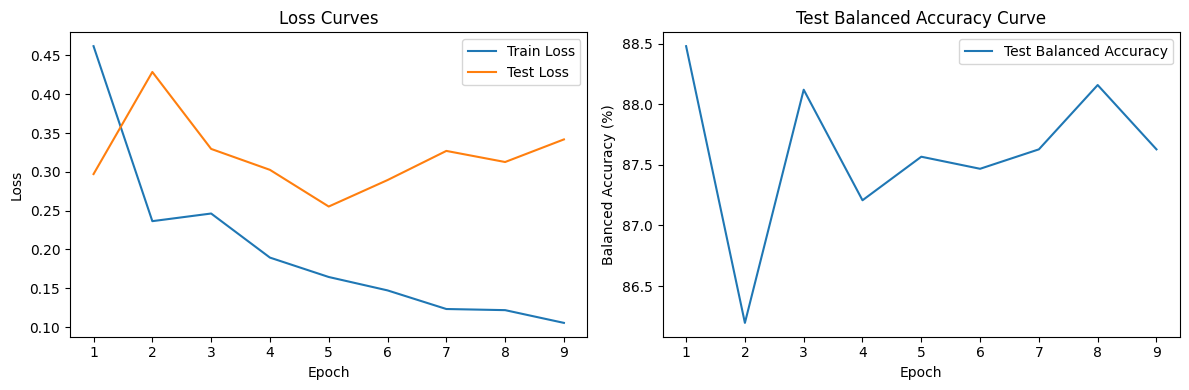

Script finished.


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchaudio
from torchaudio import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

try:
    metadata_full = pd.read_csv("recordings/metadata_wav.csv")
except FileNotFoundError:
    print("Error: 'recordings/metadata_wav.csv' not found. Please ensure the file exists.")
    raise

metadata_full.dropna(subset=['wav_path'], inplace=True)
metadata_full['is_english'] = metadata_full['native_language'].apply(
    lambda x: 1 if isinstance(x, str) and 'english' in x.lower() else 0
).astype(int)

print("Full dataset class distribution:")
print(metadata_full['is_english'].value_counts())
print(f"Total samples in full dataset: {len(metadata_full)}")

class SpeechAccentDataset(Dataset):
    def __init__(self, metadata_df, feature_extractor, target_sample_rate=16000, max_length_seconds=10):
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.target_sample_rate = target_sample_rate
        self.max_samples = target_sample_rate * max_length_seconds

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        file_path = row['wav_path']
        label = row['is_english']
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"Warning: Error loading file {file_path}: {e}. Returning dummy sample.")
            return {'input_values': torch.zeros(self.max_samples), 'label': torch.tensor(-1, dtype=torch.long)}
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sample_rate != self.target_sample_rate:
            waveform = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)
        waveform = waveform.squeeze(0)
        current_length = waveform.shape[0]
        if current_length > self.max_samples: waveform = waveform[:self.max_samples]
        elif current_length < self.max_samples:
            waveform = torch.nn.functional.pad(waveform, (0, self.max_samples - current_length))
        processed = self.feature_extractor(
            waveform.numpy(), sampling_rate=self.target_sample_rate, return_tensors="pt",
            padding="max_length", max_length=self.max_samples, truncation=True
        )
        return {'input_values': processed.input_values.squeeze(0), 'label': torch.tensor(label, dtype=torch.long)}

class Wav2VecClassifier(nn.Module):
    def __init__(self, num_classes=2, model_name="facebook/wav2vec2-base", num_layers_to_unfreeze=2):
        super(Wav2VecClassifier, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(model_name)
        for param in self.wav2vec.parameters(): param.requires_grad = False
        if hasattr(self.wav2vec, 'feature_projector') and self.wav2vec.feature_projector is not None:
            for param in self.wav2vec.feature_projector.parameters():
                param.requires_grad = True
            print("Unfroze Wav2Vec2 feature_projector.")
        if hasattr(self.wav2vec, 'encoder') and hasattr(self.wav2vec.encoder, 'layers') and num_layers_to_unfreeze > 0:
            num_total_layers = len(self.wav2vec.encoder.layers)
            start_layer_idx = num_total_layers - num_layers_to_unfreeze
            actual_unfrozen_count = 0
            for i in range(max(0, start_layer_idx), num_total_layers):
                for param in self.wav2vec.encoder.layers[i].parameters():
                    param.requires_grad = True
                actual_unfrozen_count +=1
            print(f"Unfroze the last {actual_unfrozen_count} Wav2Vec2 transformer layers.")
        elif num_layers_to_unfreeze > 0: print("Could not unfreeze transformer layers.")
        self.classifier = nn.Sequential(
            nn.Linear(self.wav2vec.config.hidden_size, 256),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, input_values):
        if input_values.ndim == 1: input_values = input_values.unsqueeze(0)
        outputs = self.wav2vec(input_values).last_hidden_state
        embeddings = torch.mean(outputs, dim=1)
        return self.classifier(embeddings)

hf_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
train_df, test_df = train_test_split(
    metadata_full, test_size=0.20, random_state=42,
    stratify=metadata_full['is_english'] if len(metadata_full['is_english'].unique()) > 1 else None
)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")
train_dataset = SpeechAccentDataset(train_df, hf_feature_extractor)
test_dataset = SpeechAccentDataset(test_df, hf_feature_extractor)

sampler = None
class_weights_tensor = None
if not train_df.empty and 'is_english' in train_df.columns:
    train_class_counts = train_df['is_english'].value_counts().sort_index()
    print(f"Training set class distribution: {train_class_counts}")
    if len(train_class_counts) == 2:
        weight_per_class = 1. / train_class_counts.values
        sample_weights_val = train_df['is_english'].map(lambda x: weight_per_class[x]).to_numpy()
        sample_weights = torch.from_numpy(sample_weights_val).double()
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler for training.")
        class_weights_list = [len(train_df) / count if count > 0 else 0 for count in train_class_counts]
        total_weight_sum = sum(class_weights_list)
        if total_weight_sum > 0: class_weights_list = [w / total_weight_sum * len(train_class_counts) for w in class_weights_list]
        class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float32)
        print(f"Calculated class weights for CrossEntropyLoss: {class_weights_tensor}")

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False if sampler else True, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = Wav2VecClassifier(num_layers_to_unfreeze=2).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None)
print(f"Using {'weighted' if class_weights_tensor is not None else 'unweighted'} CrossEntropyLoss.")
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

NUM_EPOCHS = 20
best_val_metric = 0.0
epochs_no_improve = 0
PATIENCE_EARLY_STOP = 8

train_losses, test_losses, test_bal_accuracies = [], [], []
model_save_path = 'best_english_classifier_full_data_finetuned_v3.pt' # new model name

print(f"\nStarting training on FULL dataset for up to {NUM_EPOCHS} epochs (fine-tuning)...")
for epoch in range(NUM_EPOCHS):
    model.train()
    current_train_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for batch in train_iterator:
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item(), 'lr': optimizer.param_groups[0]['lr']})
    avg_train_loss = current_train_loss / len(train_loader) if len(train_loader) > 0 else 0
    train_losses.append(avg_train_loss)

    model.eval()
    current_test_loss = 0.0
    all_epoch_preds, all_epoch_labels = [], []
    test_iterator = tqdm(test_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Test]')
    with torch.no_grad():
        for batch in test_iterator:
            if batch['label'][0] == -1: continue
            input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
            outputs = model(input_values)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_epoch_preds.extend(predicted.cpu().numpy())
            all_epoch_labels.extend(labels.cpu().numpy())
    avg_test_loss = current_test_loss / len(test_loader) if len(test_loader) > 0 else 0
    current_bal_accuracy = balanced_accuracy_score(all_epoch_labels, all_epoch_preds) * 100 if all_epoch_labels and all_epoch_preds else 0
    test_losses.append(avg_test_loss)
    test_bal_accuracies.append(current_bal_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Bal. Acc: {current_bal_accuracy:.2f}%, LR: {optimizer.param_groups[0]['lr']:.1e}")
    if all_epoch_labels and all_epoch_preds:
        try: print(classification_report(all_epoch_labels, all_epoch_preds, target_names=['Non-English', 'English'], zero_division=0))
        except ValueError as e: print(f"Report error: {e}")

    scheduler.step(current_bal_accuracy)

    if current_bal_accuracy > best_val_metric:
        best_val_metric = current_bal_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"  New best model saved (Bal. Acc: {best_val_metric:.2f}%)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  No improvement in val balanced accuracy for {epochs_no_improve} epoch(s). Best: {best_val_metric:.2f}%")

    if epochs_no_improve >= PATIENCE_EARLY_STOP:
        print(f"Early stopping triggered after {epoch+1} epochs due to no improvement for {PATIENCE_EARLY_STOP} epochs.")
        break
print("\nTraining finished.")

if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f"\nLoaded best model from {model_save_path} for final evaluation.")
else: print(f"\nWarning: Saved model {model_save_path} not found. Evaluating current model state.")
model.eval()
final_all_preds, final_all_labels = [], []
actual_epochs_run = len(train_losses)

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Final Evaluation'):
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        outputs = model(input_values)
        _, predicted = torch.max(outputs.data, 1)
        final_all_preds.extend(predicted.cpu().numpy())
        final_all_labels.extend(labels.cpu().numpy())

if final_all_labels and final_all_preds:
    print("\nFinal Classification Report (Test Set from Full Data):")
    try:
        print(classification_report(final_all_labels, final_all_preds, target_names=['Non-English', 'English'], zero_division=0))
        print(f"Final Balanced Accuracy: {balanced_accuracy_score(final_all_labels, final_all_preds) * 100:.2f}%")
    except ValueError as e: print(f"Final report error: {e}")
else: print("No data/predictions for final report.")

# Plot Training Curves
if actual_epochs_run > 0 :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1); plt.plot(range(1, actual_epochs_run + 1), train_losses, label='Train Loss'); plt.plot(range(1, actual_epochs_run + 1), test_losses, label='Test Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')
    plt.subplot(1, 2, 2); plt.plot(range(1, actual_epochs_run + 1), test_bal_accuracies, label='Test Balanced Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Balanced Accuracy (%)'); plt.legend(); plt.title('Test Balanced Accuracy Curve')
    plt.tight_layout(); plt.savefig('training_curves_full_data_finetuned_v3.png'); plt.show()
print("Script finished.")

**V4: 20 Epochs**

Full dataset class distribution:
is_english
0    1559
1     579
Name: count, dtype: int64
Total samples in full dataset: 2138
Training set size: 1710, Test set size: 428
Training set class distribution: is_english
0    1247
1     463
Name: count, dtype: int64
Using WeightedRandomSampler for training.
Calculated class weights for CrossEntropyLoss: tensor([0.5415, 1.4585])
Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Unfroze the last 2 Wav2Vec2 transformer layers.
Using weighted CrossEntropyLoss.

Starting training on FULL dataset for up to 20 epochs (fine-tuning)...


Epoch 1/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 1/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1/20: Train Loss: 0.4813, Test Loss: 0.3338, Test Bal. Acc: 87.80%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.98      0.81      0.88       312
     English       0.65      0.95      0.77       116

    accuracy                           0.85       428
   macro avg       0.81      0.88      0.83       428
weighted avg       0.89      0.85      0.85       428

  New best model saved (Bal. Acc: 87.80%)


Epoch 2/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 2/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2/20: Train Loss: 0.2597, Test Loss: 0.4808, Test Bal. Acc: 84.22%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.98      0.73      0.83       312
     English       0.57      0.96      0.71       116

    accuracy                           0.79       428
   macro avg       0.77      0.84      0.77       428
weighted avg       0.87      0.79      0.80       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 87.80%


Epoch 3/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 3/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3/20: Train Loss: 0.2291, Test Loss: 0.5995, Test Bal. Acc: 81.51%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.99      0.65      0.78       312
     English       0.51      0.98      0.67       116

    accuracy                           0.74       428
   macro avg       0.75      0.82      0.73       428
weighted avg       0.86      0.74      0.75       428

  No improvement in val balanced accuracy for 2 epoch(s). Best: 87.80%


Epoch 4/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 4/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4/20: Train Loss: 0.1980, Test Loss: 0.3323, Test Bal. Acc: 87.69%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.97      0.81      0.89       312
     English       0.65      0.94      0.77       116

    accuracy                           0.85       428
   macro avg       0.81      0.88      0.83       428
weighted avg       0.89      0.85      0.86       428

  No improvement in val balanced accuracy for 3 epoch(s). Best: 87.80%


Epoch 5/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 5/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5/20: Train Loss: 0.1556, Test Loss: 0.2983, Test Bal. Acc: 88.84%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.95      0.90      0.92       312
     English       0.76      0.88      0.82       116

    accuracy                           0.89       428
   macro avg       0.86      0.89      0.87       428
weighted avg       0.90      0.89      0.89       428

  New best model saved (Bal. Acc: 88.84%)


Epoch 6/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 6/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6/20: Train Loss: 0.1701, Test Loss: 0.3670, Test Bal. Acc: 87.42%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.97      0.82      0.89       312
     English       0.65      0.93      0.77       116

    accuracy                           0.85       428
   macro avg       0.81      0.87      0.83       428
weighted avg       0.88      0.85      0.85       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 88.84%


Epoch 7/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 7/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7/20: Train Loss: 0.1343, Test Loss: 0.3227, Test Bal. Acc: 88.59%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.97      0.85      0.90       312
     English       0.69      0.92      0.79       116

    accuracy                           0.87       428
   macro avg       0.83      0.89      0.85       428
weighted avg       0.89      0.87      0.87       428

  No improvement in val balanced accuracy for 2 epoch(s). Best: 88.84%


Epoch 8/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 8/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8/20: Train Loss: 0.1258, Test Loss: 0.3715, Test Bal. Acc: 87.67%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.95      0.87      0.91       312
     English       0.71      0.89      0.79       116

    accuracy                           0.87       428
   macro avg       0.83      0.88      0.85       428
weighted avg       0.89      0.87      0.88       428

  No improvement in val balanced accuracy for 3 epoch(s). Best: 88.84%


Epoch 9/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 9/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9/20: Train Loss: 0.1363, Test Loss: 0.3258, Test Bal. Acc: 88.16%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.96      0.85      0.90       312
     English       0.69      0.91      0.79       116

    accuracy                           0.87       428
   macro avg       0.83      0.88      0.85       428
weighted avg       0.89      0.87      0.87       428

  No improvement in val balanced accuracy for 4 epoch(s). Best: 88.84%


Epoch 10/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 10/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10/20: Train Loss: 0.0882, Test Loss: 0.4030, Test Bal. Acc: 87.68%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.96      0.84      0.90       312
     English       0.68      0.91      0.78       116

    accuracy                           0.86       428
   macro avg       0.82      0.88      0.84       428
weighted avg       0.89      0.86      0.87       428

  No improvement in val balanced accuracy for 5 epoch(s). Best: 88.84%


Epoch 11/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 11/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 11/20: Train Loss: 0.1228, Test Loss: 0.3596, Test Bal. Acc: 89.58%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.95      0.93      0.94       312
     English       0.82      0.86      0.84       116

    accuracy                           0.91       428
   macro avg       0.88      0.90      0.89       428
weighted avg       0.91      0.91      0.91       428

  New best model saved (Bal. Acc: 89.58%)


Epoch 12/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 12/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 12/20: Train Loss: 0.0883, Test Loss: 0.3899, Test Bal. Acc: 91.02%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.95      0.96      0.95       312
     English       0.88      0.86      0.87       116

    accuracy                           0.93       428
   macro avg       0.92      0.91      0.91       428
weighted avg       0.93      0.93      0.93       428

  New best model saved (Bal. Acc: 91.02%)


Epoch 13/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 13/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 13/20: Train Loss: 0.0819, Test Loss: 0.3673, Test Bal. Acc: 89.41%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.94      0.95      0.95       312
     English       0.87      0.84      0.85       116

    accuracy                           0.92       428
   macro avg       0.90      0.89      0.90       428
weighted avg       0.92      0.92      0.92       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 91.02%


Epoch 14/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 14/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 14/20: Train Loss: 0.0518, Test Loss: 0.3864, Test Bal. Acc: 91.03%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.96      0.93      0.94       312
     English       0.83      0.89      0.86       116

    accuracy                           0.92       428
   macro avg       0.89      0.91      0.90       428
weighted avg       0.92      0.92      0.92       428

  New best model saved (Bal. Acc: 91.03%)


Epoch 15/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 15/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 15/20: Train Loss: 0.0722, Test Loss: 0.3955, Test Bal. Acc: 91.24%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.95      0.95      0.95       312
     English       0.86      0.88      0.87       116

    accuracy                           0.93       428
   macro avg       0.91      0.91      0.91       428
weighted avg       0.93      0.93      0.93       428

  New best model saved (Bal. Acc: 91.24%)


Epoch 16/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 16/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 16/20: Train Loss: 0.0541, Test Loss: 0.4051, Test Bal. Acc: 89.98%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.97      0.87      0.92       312
     English       0.72      0.93      0.82       116

    accuracy                           0.89       428
   macro avg       0.85      0.90      0.87       428
weighted avg       0.90      0.89      0.89       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 91.24%


Epoch 17/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 17/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 17/20: Train Loss: 0.0671, Test Loss: 0.3896, Test Bal. Acc: 91.15%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.97      0.90      0.93       312
     English       0.78      0.92      0.84       116

    accuracy                           0.91       428
   macro avg       0.87      0.91      0.89       428
weighted avg       0.92      0.91      0.91       428

  No improvement in val balanced accuracy for 2 epoch(s). Best: 91.24%


Epoch 18/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 18/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 18/20: Train Loss: 0.0473, Test Loss: 0.4203, Test Bal. Acc: 90.23%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.96      0.92      0.94       312
     English       0.80      0.89      0.84       116

    accuracy                           0.91       428
   macro avg       0.88      0.90      0.89       428
weighted avg       0.91      0.91      0.91       428

  No improvement in val balanced accuracy for 3 epoch(s). Best: 91.24%


Epoch 19/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 19/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 19/20: Train Loss: 0.0371, Test Loss: 0.4245, Test Bal. Acc: 89.39%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.97      0.87      0.91       312
     English       0.72      0.92      0.81       116

    accuracy                           0.88       428
   macro avg       0.84      0.89      0.86       428
weighted avg       0.90      0.88      0.88       428

  No improvement in val balanced accuracy for 4 epoch(s). Best: 91.24%


Epoch 20/20 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 20/20 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 20/20: Train Loss: 0.0664, Test Loss: 0.3182, Test Bal. Acc: 91.47%, LR: 3.0e-05
              precision    recall  f1-score   support

 Non-English       0.97      0.91      0.94       312
     English       0.79      0.92      0.85       116

    accuracy                           0.91       428
   macro avg       0.88      0.91      0.89       428
weighted avg       0.92      0.91      0.91       428

  New best model saved (Bal. Acc: 91.47%)

Training finished.

Loaded best model from best_english_classifier_full_data_finetuned_v4.pt for final evaluation.


Final Evaluation:   0%|          | 0/54 [00:00<?, ?it/s]


Final Classification Report (Test Set from Full Data):
              precision    recall  f1-score   support

 Non-English       0.97      0.91      0.94       312
     English       0.79      0.92      0.85       116

    accuracy                           0.91       428
   macro avg       0.88      0.91      0.89       428
weighted avg       0.92      0.91      0.91       428

Final Balanced Accuracy: 91.47%


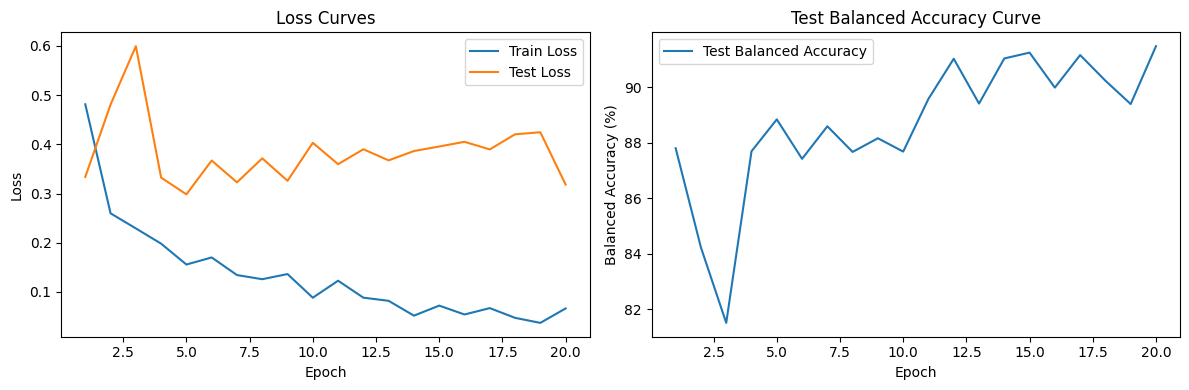

Script finished.


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
# from torch.optim.lr_scheduler import ReduceLROnPlateau # LR Scheduler removed
import torchaudio
from torchaudio import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

try:
    metadata_full = pd.read_csv("recordings/metadata_wav.csv")
except FileNotFoundError:
    print("Error: 'recordings/metadata_wav.csv' not found. Please ensure the file exists.")
    raise

metadata_full.dropna(subset=['wav_path'], inplace=True)
metadata_full['is_english'] = metadata_full['native_language'].apply(
    lambda x: 1 if isinstance(x, str) and 'english' in x.lower() else 0
).astype(int)

print("Full dataset class distribution:")
print(metadata_full['is_english'].value_counts())
print(f"Total samples in full dataset: {len(metadata_full)}")

class SpeechAccentDataset(Dataset):
    def __init__(self, metadata_df, feature_extractor, target_sample_rate=16000, max_length_seconds=10):
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.target_sample_rate = target_sample_rate
        self.max_samples = target_sample_rate * max_length_seconds

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        file_path = row['wav_path']
        label = row['is_english']
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"Warning: Error loading file {file_path}: {e}. Returning dummy sample.")
            return {'input_values': torch.zeros(self.max_samples), 'label': torch.tensor(-1, dtype=torch.long)}
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sample_rate != self.target_sample_rate:
            waveform = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)
        waveform = waveform.squeeze(0)
        current_length = waveform.shape[0]
        if current_length > self.max_samples: waveform = waveform[:self.max_samples]
        elif current_length < self.max_samples:
            waveform = torch.nn.functional.pad(waveform, (0, self.max_samples - current_length))
        processed = self.feature_extractor(
            waveform.numpy(), sampling_rate=self.target_sample_rate, return_tensors="pt",
            padding="max_length", max_length=self.max_samples, truncation=True
        )
        return {'input_values': processed.input_values.squeeze(0), 'label': torch.tensor(label, dtype=torch.long)}

class Wav2VecClassifier(nn.Module):
    def __init__(self, num_classes=2, model_name="facebook/wav2vec2-base", num_layers_to_unfreeze=2):
        super(Wav2VecClassifier, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(model_name)
        for param in self.wav2vec.parameters(): param.requires_grad = False
        if hasattr(self.wav2vec, 'feature_projector') and self.wav2vec.feature_projector is not None:
            for param in self.wav2vec.feature_projector.parameters():
                param.requires_grad = True
            print("Unfroze Wav2Vec2 feature_projector.")
        if hasattr(self.wav2vec, 'encoder') and hasattr(self.wav2vec.encoder, 'layers') and num_layers_to_unfreeze > 0:
            num_total_layers = len(self.wav2vec.encoder.layers)
            start_layer_idx = num_total_layers - num_layers_to_unfreeze
            actual_unfrozen_count = 0
            for i in range(max(0, start_layer_idx), num_total_layers):
                for param in self.wav2vec.encoder.layers[i].parameters():
                    param.requires_grad = True
                actual_unfrozen_count +=1
            print(f"Unfroze the last {actual_unfrozen_count} Wav2Vec2 transformer layers.")
        elif num_layers_to_unfreeze > 0: print("Could not unfreeze transformer layers.")
        self.classifier = nn.Sequential(
            nn.Linear(self.wav2vec.config.hidden_size, 256),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, input_values):
        if input_values.ndim == 1: input_values = input_values.unsqueeze(0)
        outputs = self.wav2vec(input_values).last_hidden_state
        embeddings = torch.mean(outputs, dim=1)
        return self.classifier(embeddings)

hf_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
train_df, test_df = train_test_split(
    metadata_full, test_size=0.20, random_state=42,
    stratify=metadata_full['is_english'] if len(metadata_full['is_english'].unique()) > 1 else None
)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")
train_dataset = SpeechAccentDataset(train_df, hf_feature_extractor)
test_dataset = SpeechAccentDataset(test_df, hf_feature_extractor)

sampler = None
class_weights_tensor = None
if not train_df.empty and 'is_english' in train_df.columns:
    train_class_counts = train_df['is_english'].value_counts().sort_index()
    print(f"Training set class distribution: {train_class_counts}")
    if len(train_class_counts) == 2:
        weight_per_class = 1. / train_class_counts.values
        sample_weights_val = train_df['is_english'].map(lambda x: weight_per_class[x]).to_numpy()
        sample_weights = torch.from_numpy(sample_weights_val).double()
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler for training.")
        class_weights_list = [len(train_df) / count if count > 0 else 0 for count in train_class_counts]
        total_weight_sum = sum(class_weights_list)
        if total_weight_sum > 0: class_weights_list = [w / total_weight_sum * len(train_class_counts) for w in class_weights_list]
        class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float32)
        print(f"Calculated class weights for CrossEntropyLoss: {class_weights_tensor}")

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False if sampler else True, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = Wav2VecClassifier(num_layers_to_unfreeze=2).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None)
print(f"Using {'weighted' if class_weights_tensor is not None else 'unweighted'} CrossEntropyLoss.")
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

NUM_EPOCHS = 20
best_val_metric = 0.0
epochs_no_improve = 0
PATIENCE_EARLY_STOP = 8

train_losses, test_losses, test_bal_accuracies = [], [], []
model_save_path = 'best_english_classifier_full_data_finetuned_v4.pt' # new model name

print(f"\nStarting training on FULL dataset for up to {NUM_EPOCHS} epochs (fine-tuning)...")
for epoch in range(NUM_EPOCHS):
    model.train()
    current_train_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for batch in train_iterator:
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item(), 'lr': optimizer.param_groups[0]['lr']})
    avg_train_loss = current_train_loss / len(train_loader) if len(train_loader) > 0 else 0
    train_losses.append(avg_train_loss)

    model.eval()
    current_test_loss = 0.0
    all_epoch_preds, all_epoch_labels = [], []
    test_iterator = tqdm(test_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Test]')
    with torch.no_grad():
        for batch in test_iterator:
            if batch['label'][0] == -1: continue
            input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
            outputs = model(input_values)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_epoch_preds.extend(predicted.cpu().numpy())
            all_epoch_labels.extend(labels.cpu().numpy())
    avg_test_loss = current_test_loss / len(test_loader) if len(test_loader) > 0 else 0
    current_bal_accuracy = balanced_accuracy_score(all_epoch_labels, all_epoch_preds) * 100 if all_epoch_labels and all_epoch_preds else 0
    test_losses.append(avg_test_loss)
    test_bal_accuracies.append(current_bal_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Bal. Acc: {current_bal_accuracy:.2f}%, LR: {optimizer.param_groups[0]['lr']:.1e}")
    if all_epoch_labels and all_epoch_preds:
        try: print(classification_report(all_epoch_labels, all_epoch_preds, target_names=['Non-English', 'English'], zero_division=0))
        except ValueError as e: print(f"Report error: {e}")

    # LR Scheduler step removed
    # scheduler.step(current_bal_accuracy)

    if current_bal_accuracy > best_val_metric:
        best_val_metric = current_bal_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"  New best model saved (Bal. Acc: {best_val_metric:.2f}%)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  No improvement in val balanced accuracy for {epochs_no_improve} epoch(s). Best: {best_val_metric:.2f}%")

    if epochs_no_improve >= PATIENCE_EARLY_STOP:
        print(f"Early stopping triggered after {epoch+1} epochs due to no improvement for {PATIENCE_EARLY_STOP} epochs.")
        break
print("\nTraining finished.")

if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f"\nLoaded best model from {model_save_path} for final evaluation.")
else: print(f"\nWarning: Saved model {model_save_path} not found. Evaluating current model state.")
model.eval()
final_all_preds, final_all_labels = [], []
actual_epochs_run = len(train_losses)

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Final Evaluation'):
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        outputs = model(input_values)
        _, predicted = torch.max(outputs.data, 1)
        final_all_preds.extend(predicted.cpu().numpy())
        final_all_labels.extend(labels.cpu().numpy())

if final_all_labels and final_all_preds:
    print("\nFinal Classification Report (Test Set from Full Data):")
    try:
        print(classification_report(final_all_labels, final_all_preds, target_names=['Non-English', 'English'], zero_division=0))
        print(f"Final Balanced Accuracy: {balanced_accuracy_score(final_all_labels, final_all_preds) * 100:.2f}%")
    except ValueError as e: print(f"Final report error: {e}")
else: print("No data/predictions for final report.")

# Plot Training Curves
if actual_epochs_run > 0 :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1); plt.plot(range(1, actual_epochs_run + 1), train_losses, label='Train Loss'); plt.plot(range(1, actual_epochs_run + 1), test_losses, label='Test Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')
    plt.subplot(1, 2, 2); plt.plot(range(1, actual_epochs_run + 1), test_bal_accuracies, label='Test Balanced Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Balanced Accuracy (%)'); plt.legend(); plt.title('Test Balanced Accuracy Curve')
    plt.tight_layout(); plt.savefig('training_curves_full_data_finetuned_v4.png'); plt.show()
print("Script finished.")

#### V5: BEST MODEL

Full dataset class distribution:
is_english
0    1559
1     579
Name: count, dtype: int64
Total samples in full dataset: 2138
Training set size: 1710, Test set size: 428
Training set class distribution: is_english
0    1247
1     463
Name: count, dtype: int64
Using WeightedRandomSampler for training.
Calculated class weights for CrossEntropyLoss: tensor([0.5415, 1.4585])
Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Unfroze the last 2 Wav2Vec2 transformer layers.
Using weighted CrossEntropyLoss.
Optimizer: AdamW with lr=3e-5 and weight_decay=0.01

Starting training for up to 25 epochs...


Epoch 1/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 1/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1/25: Train Loss: 0.4516, Test Loss: 0.3689, Test Bal. Acc: 85.34%
              precision    recall  f1-score   support

 Non-English       0.98      0.75      0.85       312
     English       0.59      0.96      0.73       116

    accuracy                           0.81       428
   macro avg       0.78      0.85      0.79       428
weighted avg       0.87      0.81      0.82       428

  New best model saved (Bal. Acc: 85.34%)


Epoch 2/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 2/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2/25: Train Loss: 0.2308, Test Loss: 0.3311, Test Bal. Acc: 88.38%
              precision    recall  f1-score   support

 Non-English       0.97      0.84      0.90       312
     English       0.68      0.93      0.79       116

    accuracy                           0.86       428
   macro avg       0.82      0.88      0.84       428
weighted avg       0.89      0.86      0.87       428

  New best model saved (Bal. Acc: 88.38%)


Epoch 3/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 3/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3/25: Train Loss: 0.2232, Test Loss: 0.2843, Test Bal. Acc: 88.43%
              precision    recall  f1-score   support

 Non-English       0.97      0.85      0.90       312
     English       0.69      0.92      0.79       116

    accuracy                           0.87       428
   macro avg       0.83      0.88      0.85       428
weighted avg       0.89      0.87      0.87       428

  New best model saved (Bal. Acc: 88.43%)


Epoch 4/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 4/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4/25: Train Loss: 0.1830, Test Loss: 0.4015, Test Bal. Acc: 87.38%
              precision    recall  f1-score   support

 Non-English       0.98      0.78      0.87       312
     English       0.62      0.97      0.76       116

    accuracy                           0.83       428
   macro avg       0.80      0.87      0.81       428
weighted avg       0.89      0.83      0.84       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 88.43%


Epoch 5/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 5/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5/25: Train Loss: 0.1619, Test Loss: 0.2735, Test Bal. Acc: 89.70%
              precision    recall  f1-score   support

 Non-English       0.96      0.90      0.93       312
     English       0.76      0.90      0.83       116

    accuracy                           0.90       428
   macro avg       0.86      0.90      0.88       428
weighted avg       0.91      0.90      0.90       428

  New best model saved (Bal. Acc: 89.70%)


Epoch 6/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 6/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6/25: Train Loss: 0.1701, Test Loss: 0.2566, Test Bal. Acc: 87.99%
              precision    recall  f1-score   support

 Non-English       0.95      0.87      0.91       312
     English       0.72      0.89      0.80       116

    accuracy                           0.88       428
   macro avg       0.84      0.88      0.85       428
weighted avg       0.89      0.88      0.88       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 89.70%


Epoch 7/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 7/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7/25: Train Loss: 0.1107, Test Loss: 0.2726, Test Bal. Acc: 88.79%
              precision    recall  f1-score   support

 Non-English       0.96      0.89      0.92       312
     English       0.75      0.89      0.81       116

    accuracy                           0.89       428
   macro avg       0.85      0.89      0.87       428
weighted avg       0.90      0.89      0.89       428

  No improvement in val balanced accuracy for 2 epoch(s). Best: 89.70%


Epoch 8/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 8/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8/25: Train Loss: 0.1164, Test Loss: 0.2887, Test Bal. Acc: 89.95%
              precision    recall  f1-score   support

 Non-English       0.95      0.95      0.95       312
     English       0.85      0.85      0.85       116

    accuracy                           0.92       428
   macro avg       0.90      0.90      0.90       428
weighted avg       0.92      0.92      0.92       428

  New best model saved (Bal. Acc: 89.95%)


Epoch 9/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 9/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9/25: Train Loss: 0.1012, Test Loss: 0.2898, Test Bal. Acc: 89.59%
              precision    recall  f1-score   support

 Non-English       0.96      0.90      0.93       312
     English       0.77      0.89      0.83       116

    accuracy                           0.90       428
   macro avg       0.87      0.90      0.88       428
weighted avg       0.91      0.90      0.90       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 89.95%


Epoch 10/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 10/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10/25: Train Loss: 0.0852, Test Loss: 0.3911, Test Bal. Acc: 88.53%
              precision    recall  f1-score   support

 Non-English       0.96      0.87      0.91       312
     English       0.71      0.91      0.80       116

    accuracy                           0.88       428
   macro avg       0.84      0.89      0.85       428
weighted avg       0.89      0.88      0.88       428

  No improvement in val balanced accuracy for 2 epoch(s). Best: 89.95%


Epoch 11/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 11/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 11/25: Train Loss: 0.0791, Test Loss: 0.5035, Test Bal. Acc: 84.49%
              precision    recall  f1-score   support

 Non-English       0.98      0.72      0.83       312
     English       0.57      0.97      0.71       116

    accuracy                           0.79       428
   macro avg       0.77      0.84      0.77       428
weighted avg       0.87      0.79      0.80       428

  No improvement in val balanced accuracy for 3 epoch(s). Best: 89.95%


Epoch 12/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 12/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 12/25: Train Loss: 0.0773, Test Loss: 0.3181, Test Bal. Acc: 91.78%
              precision    recall  f1-score   support

 Non-English       0.96      0.94      0.95       312
     English       0.85      0.90      0.87       116

    accuracy                           0.93       428
   macro avg       0.90      0.92      0.91       428
weighted avg       0.93      0.93      0.93       428

  New best model saved (Bal. Acc: 91.78%)


Epoch 13/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 13/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 13/25: Train Loss: 0.0551, Test Loss: 0.3376, Test Bal. Acc: 89.85%
              precision    recall  f1-score   support

 Non-English       0.95      0.93      0.94       312
     English       0.81      0.87      0.84       116

    accuracy                           0.91       428
   macro avg       0.88      0.90      0.89       428
weighted avg       0.91      0.91      0.91       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 91.78%


Epoch 14/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 14/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 14/25: Train Loss: 0.0458, Test Loss: 0.3433, Test Bal. Acc: 90.29%
              precision    recall  f1-score   support

 Non-English       0.96      0.90      0.93       312
     English       0.77      0.91      0.83       116

    accuracy                           0.90       428
   macro avg       0.87      0.90      0.88       428
weighted avg       0.91      0.90      0.90       428

  No improvement in val balanced accuracy for 2 epoch(s). Best: 91.78%


Epoch 15/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 15/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 15/25: Train Loss: 0.0749, Test Loss: 0.3155, Test Bal. Acc: 90.14%
              precision    recall  f1-score   support

 Non-English       0.97      0.87      0.92       312
     English       0.73      0.93      0.82       116

    accuracy                           0.89       428
   macro avg       0.85      0.90      0.87       428
weighted avg       0.91      0.89      0.89       428

  No improvement in val balanced accuracy for 3 epoch(s). Best: 91.78%


Epoch 16/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 16/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 16/25: Train Loss: 0.0512, Test Loss: 0.3445, Test Bal. Acc: 90.76%
              precision    recall  f1-score   support

 Non-English       0.95      0.94      0.94       312
     English       0.84      0.88      0.86       116

    accuracy                           0.92       428
   macro avg       0.90      0.91      0.90       428
weighted avg       0.92      0.92      0.92       428

  No improvement in val balanced accuracy for 4 epoch(s). Best: 91.78%


Epoch 17/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 17/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 17/25: Train Loss: 0.0429, Test Loss: 0.3623, Test Bal. Acc: 90.92%
              precision    recall  f1-score   support

 Non-English       0.95      0.94      0.95       312
     English       0.84      0.88      0.86       116

    accuracy                           0.92       428
   macro avg       0.90      0.91      0.90       428
weighted avg       0.92      0.92      0.92       428

  No improvement in val balanced accuracy for 5 epoch(s). Best: 91.78%


Epoch 18/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 18/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 18/25: Train Loss: 0.0500, Test Loss: 0.3306, Test Bal. Acc: 91.78%
              precision    recall  f1-score   support

 Non-English       0.96      0.94      0.95       312
     English       0.85      0.90      0.87       116

    accuracy                           0.93       428
   macro avg       0.90      0.92      0.91       428
weighted avg       0.93      0.93      0.93       428

  No improvement in val balanced accuracy for 6 epoch(s). Best: 91.78%


Epoch 19/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 19/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 19/25: Train Loss: 0.0299, Test Loss: 0.3913, Test Bal. Acc: 89.79%
              precision    recall  f1-score   support

 Non-English       0.95      0.94      0.94       312
     English       0.85      0.85      0.85       116

    accuracy                           0.92       428
   macro avg       0.90      0.90      0.90       428
weighted avg       0.92      0.92      0.92       428

  No improvement in val balanced accuracy for 7 epoch(s). Best: 91.78%


Epoch 20/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 20/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 20/25: Train Loss: 0.0407, Test Loss: 0.4040, Test Bal. Acc: 91.26%
              precision    recall  f1-score   support

 Non-English       0.97      0.89      0.93       312
     English       0.77      0.93      0.84       116

    accuracy                           0.90       428
   macro avg       0.87      0.91      0.89       428
weighted avg       0.92      0.90      0.91       428

  No improvement in val balanced accuracy for 8 epoch(s). Best: 91.78%
Early stopping triggered after 20 epochs.

Training finished.

Loaded best model from best_english_classifier_full_data_finetuned_v5.pt for final evaluation.


Final Evaluation:   0%|          | 0/54 [00:00<?, ?it/s]


Final Classification Report (Test Set from Full Data):
              precision    recall  f1-score   support

 Non-English       0.96      0.94      0.95       312
     English       0.85      0.90      0.87       116

    accuracy                           0.93       428
   macro avg       0.90      0.92      0.91       428
weighted avg       0.93      0.93      0.93       428

Final Balanced Accuracy: 91.78%


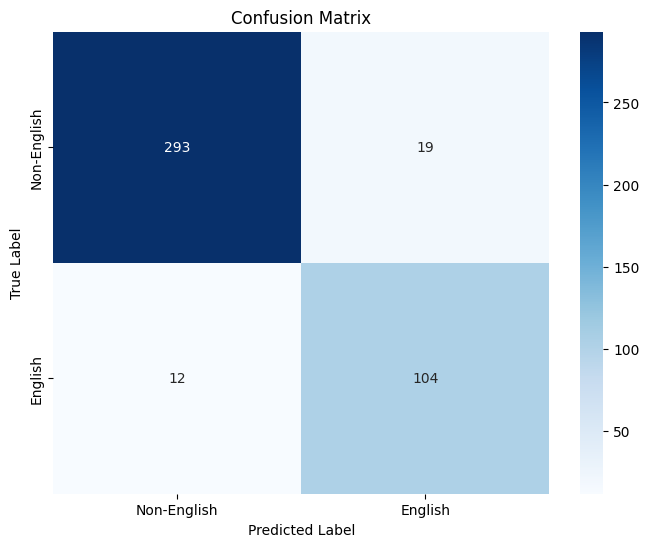

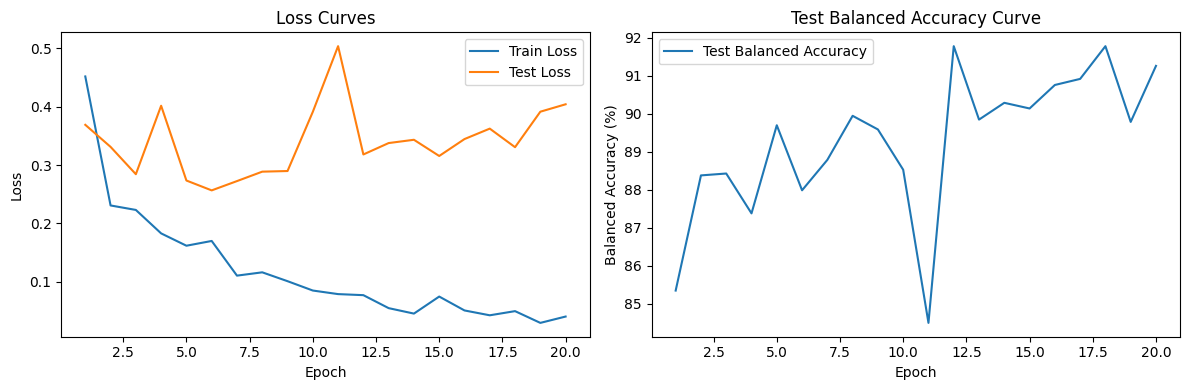

Script finished.


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio
from torchaudio import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

metadata_full = pd.read_csv("recordings/metadata_wav.csv")
metadata_full.dropna(subset=['wav_path'], inplace=True)
metadata_full['is_english'] = metadata_full['native_language'].apply(
    lambda x: 1 if isinstance(x, str) and 'english' in x.lower() else 0
).astype(int)
print(f"Full dataset class distribution:\n{metadata_full['is_english'].value_counts()}")
print(f"Total samples in full dataset: {len(metadata_full)}")

class SpeechAccentDataset(Dataset):
    def __init__(self, metadata_df, feature_extractor, target_sample_rate=16000, max_length_seconds=10):
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.target_sample_rate = target_sample_rate
        self.max_samples = target_sample_rate * max_length_seconds

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        file_path = row['wav_path']
        label = row['is_english']
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception:
            return {'input_values': torch.zeros(self.max_samples), 'label': torch.tensor(-1, dtype=torch.long)} # Dummy
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sample_rate != self.target_sample_rate:
            waveform = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)
        waveform = waveform.squeeze(0)
        current_length = waveform.shape[0]
        if current_length > self.max_samples: waveform = waveform[:self.max_samples]
        elif current_length < self.max_samples:
            waveform = torch.nn.functional.pad(waveform, (0, self.max_samples - current_length))
        processed = self.feature_extractor(
            waveform.numpy(), sampling_rate=self.target_sample_rate, return_tensors="pt",
            padding="max_length", max_length=self.max_samples, truncation=True
        )
        return {'input_values': processed.input_values.squeeze(0), 'label': torch.tensor(label, dtype=torch.long)}

class Wav2VecClassifier(nn.Module):
    def __init__(self, num_classes=2, model_name="facebook/wav2vec2-base", num_layers_to_unfreeze=2):
        super(Wav2VecClassifier, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(model_name)
        for param in self.wav2vec.parameters(): param.requires_grad = False # freeze all initially

        # Unfreeze feature projector
        if hasattr(self.wav2vec, 'feature_projector') and self.wav2vec.feature_projector is not None:
            for param in self.wav2vec.feature_projector.parameters():
                param.requires_grad = True
            print("Unfroze Wav2Vec2 feature_projector.")

        # Unfreeze top N transformer layers
        if hasattr(self.wav2vec, 'encoder') and hasattr(self.wav2vec.encoder, 'layers') and num_layers_to_unfreeze > 0:
            num_total_layers = len(self.wav2vec.encoder.layers)
            start_layer_idx = num_total_layers - num_layers_to_unfreeze
            actual_unfrozen_count = 0
            for i in range(max(0, start_layer_idx), num_total_layers):
                for param in self.wav2vec.encoder.layers[i].parameters():
                    param.requires_grad = True
                actual_unfrozen_count +=1
            print(f"Unfroze the last {actual_unfrozen_count} Wav2Vec2 transformer layers.")

        self.classifier = nn.Sequential(
            nn.Linear(self.wav2vec.config.hidden_size, 256),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, input_values):
        if input_values.ndim == 1: input_values = input_values.unsqueeze(0)
        outputs = self.wav2vec(input_values).last_hidden_state
        embeddings = torch.mean(outputs, dim=1)
        return self.classifier(embeddings)

hf_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
train_df, test_df = train_test_split(
    metadata_full, test_size=0.20, random_state=42,
    stratify=metadata_full['is_english'] if len(metadata_full['is_english'].unique()) > 1 else None
)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")
train_dataset = SpeechAccentDataset(train_df, hf_feature_extractor)
test_dataset = SpeechAccentDataset(test_df, hf_feature_extractor)

sampler = None
class_weights_tensor = None
if not train_df.empty:
    train_class_counts = train_df['is_english'].value_counts().sort_index()
    print(f"Training set class distribution: {train_class_counts}")
    if len(train_class_counts) == 2:
        weight_per_class = 1. / train_class_counts.values
        sample_weights_val = train_df['is_english'].map(lambda x: weight_per_class[x]).to_numpy()
        sample_weights = torch.from_numpy(sample_weights_val).double()
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler for training.")

        class_weights_list = [len(train_df) / count if count > 0 else 0 for count in train_class_counts]
        total_weight_sum = sum(class_weights_list)
        if total_weight_sum > 0: class_weights_list = [w / total_weight_sum * len(train_class_counts) for w in class_weights_list]
        class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float32)
        print(f"Calculated class weights for CrossEntropyLoss: {class_weights_tensor}")

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False if sampler else True, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = Wav2VecClassifier(num_layers_to_unfreeze=2).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None)
print(f"Using {'weighted' if class_weights_tensor is not None else 'unweighted'} CrossEntropyLoss.")
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5, weight_decay=0.01)
print(f"Optimizer: AdamW with lr=3e-5 and weight_decay=0.01")

NUM_EPOCHS = 25
best_val_metric = 0.0
epochs_no_improve = 0
PATIENCE_EARLY_STOP = 8
train_losses, test_losses, test_bal_accuracies = [], [], []
model_save_path = 'best_english_classifier_full_data_finetuned_v5.pt'

print(f"\nStarting training for up to {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    model.train()
    current_train_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for batch in train_iterator:
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item(), 'lr': optimizer.param_groups[0]['lr']})
    avg_train_loss = current_train_loss / len(train_loader) if len(train_loader) > 0 else 0
    train_losses.append(avg_train_loss)

    model.eval()
    current_test_loss = 0.0
    all_epoch_preds, all_epoch_labels = [], []
    test_iterator = tqdm(test_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Test]')
    with torch.no_grad():
        for batch in test_iterator:
            if batch['label'][0] == -1: continue
            input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
            outputs = model(input_values)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_epoch_preds.extend(predicted.cpu().numpy())
            all_epoch_labels.extend(labels.cpu().numpy())
    avg_test_loss = current_test_loss / len(test_loader) if len(test_loader) > 0 else 0
    current_bal_accuracy = balanced_accuracy_score(all_epoch_labels, all_epoch_preds) * 100 if all_epoch_labels and all_epoch_preds else 0
    test_losses.append(avg_test_loss)
    test_bal_accuracies.append(current_bal_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Bal. Acc: {current_bal_accuracy:.2f}%")
    if all_epoch_labels and all_epoch_preds:
        print(classification_report(all_epoch_labels, all_epoch_preds, target_names=['Non-English', 'English'], zero_division=0))

    if current_bal_accuracy > best_val_metric:
        best_val_metric = current_bal_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"  New best model saved (Bal. Acc: {best_val_metric:.2f}%)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  No improvement in val balanced accuracy for {epochs_no_improve} epoch(s). Best: {best_val_metric:.2f}%")

    if epochs_no_improve >= PATIENCE_EARLY_STOP:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break
print("\nTraining finished.")
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f"\nLoaded best model from {model_save_path} for final evaluation.")
else:
    print(f"\nWarning: Saved model {model_save_path} not found. Evaluating current model state.")

model.eval()
final_all_preds, final_all_labels = [], []
actual_epochs_run = len(train_losses)

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Final Evaluation'):
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        outputs = model(input_values)
        _, predicted = torch.max(outputs.data, 1)
        final_all_preds.extend(predicted.cpu().numpy())
        final_all_labels.extend(labels.cpu().numpy())

if final_all_labels and final_all_preds:
    print("\nFinal Classification Report (Test Set from Full Data):")
    print(classification_report(final_all_labels, final_all_preds, target_names=['Non-English', 'English'], zero_division=0))
    final_bal_acc = balanced_accuracy_score(final_all_labels, final_all_preds) * 100
    print(f"Final Balanced Accuracy: {final_bal_acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(final_all_labels, final_all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-English', 'English'],
                yticklabels=['Non-English', 'English'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix_full_data_finetuned_v5.png')
    plt.show()
else:
    print("No data/predictions for final report and confusion matrix.")

# Plot Training Curves
if actual_epochs_run > 0 :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, actual_epochs_run + 1), train_losses, label='Train Loss')
    plt.plot(range(1, actual_epochs_run + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, actual_epochs_run + 1), test_bal_accuracies, label='Test Balanced Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Balanced Accuracy (%)'); plt.legend(); plt.title('Test Balanced Accuracy Curve')

    plt.tight_layout()
    plt.savefig('training_curves_full_data_finetuned_v5.png')
    plt.show()
print("Script finished.")

##### Save Best Model V5

Mounted at /content/drive
Full dataset class distribution:
is_english
0    1559
1     579
Name: count, dtype: int64
Total samples in full dataset: 2138


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

Training set size: 1710, Test set size: 428
Training set class distribution: is_english
0    1247
1     463
Name: count, dtype: int64
Using WeightedRandomSampler for training.
Calculated class weights for CrossEntropyLoss: tensor([0.5415, 1.4585])
Using device: cuda


config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Unfroze the last 2 Wav2Vec2 transformer layers.


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Using weighted CrossEntropyLoss.
Optimizer: AdamW with lr=3e-5 and weight_decay=0.01

Starting training for up to 25 epochs...


Epoch 1/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 1/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1/25: Train Loss: 0.4608, Test Loss: 0.3873, Test Bal. Acc: 87.86%
              precision    recall  f1-score   support

 Non-English       0.94      0.90      0.92       312
     English       0.77      0.85      0.81       116

    accuracy                           0.89       428
   macro avg       0.86      0.88      0.87       428
weighted avg       0.90      0.89      0.89       428

  New best model saved to /content/drive/MyDrive/Colab_Models/SpeechAccent_v5/best_english_classifier_final.pt (Bal. Acc: 87.86%)


Epoch 2/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 2/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2/25: Train Loss: 0.2524, Test Loss: 0.4161, Test Bal. Acc: 84.54%
              precision    recall  f1-score   support

 Non-English       0.98      0.73      0.84       312
     English       0.57      0.96      0.72       116

    accuracy                           0.79       428
   macro avg       0.78      0.85      0.78       428
weighted avg       0.87      0.79      0.81       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 87.86%


Epoch 3/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 3/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3/25: Train Loss: 0.2142, Test Loss: 0.4231, Test Bal. Acc: 84.81%
              precision    recall  f1-score   support

 Non-English       0.98      0.73      0.84       312
     English       0.57      0.97      0.72       116

    accuracy                           0.79       428
   macro avg       0.78      0.85      0.78       428
weighted avg       0.87      0.79      0.81       428

  No improvement in val balanced accuracy for 2 epoch(s). Best: 87.86%


Epoch 4/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 4/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4/25: Train Loss: 0.1976, Test Loss: 0.3595, Test Bal. Acc: 87.16%
              precision    recall  f1-score   support

 Non-English       0.98      0.79      0.88       312
     English       0.63      0.95      0.76       116

    accuracy                           0.84       428
   macro avg       0.80      0.87      0.82       428
weighted avg       0.88      0.84      0.84       428

  No improvement in val balanced accuracy for 3 epoch(s). Best: 87.86%


Epoch 5/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 5/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5/25: Train Loss: 0.1627, Test Loss: 0.3170, Test Bal. Acc: 87.10%
              precision    recall  f1-score   support

 Non-English       0.97      0.81      0.88       312
     English       0.65      0.93      0.76       116

    accuracy                           0.84       428
   macro avg       0.81      0.87      0.82       428
weighted avg       0.88      0.84      0.85       428

  No improvement in val balanced accuracy for 4 epoch(s). Best: 87.86%


Epoch 6/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 6/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6/25: Train Loss: 0.1407, Test Loss: 0.2996, Test Bal. Acc: 88.53%
              precision    recall  f1-score   support

 Non-English       0.96      0.87      0.91       312
     English       0.71      0.91      0.80       116

    accuracy                           0.88       428
   macro avg       0.84      0.89      0.85       428
weighted avg       0.89      0.88      0.88       428

  New best model saved to /content/drive/MyDrive/Colab_Models/SpeechAccent_v5/best_english_classifier_final.pt (Bal. Acc: 88.53%)


Epoch 7/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 7/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7/25: Train Loss: 0.1148, Test Loss: 0.3564, Test Bal. Acc: 88.27%
              precision    recall  f1-score   support

 Non-English       0.97      0.84      0.90       312
     English       0.69      0.92      0.79       116

    accuracy                           0.86       428
   macro avg       0.83      0.88      0.84       428
weighted avg       0.89      0.86      0.87       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 88.53%


Epoch 8/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 8/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8/25: Train Loss: 0.1127, Test Loss: 0.4280, Test Bal. Acc: 86.79%
              precision    recall  f1-score   support

 Non-English       0.98      0.78      0.87       312
     English       0.62      0.96      0.75       116

    accuracy                           0.83       428
   macro avg       0.80      0.87      0.81       428
weighted avg       0.88      0.83      0.84       428

  No improvement in val balanced accuracy for 2 epoch(s). Best: 88.53%


Epoch 9/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 9/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9/25: Train Loss: 0.1167, Test Loss: 0.3502, Test Bal. Acc: 88.12%
              precision    recall  f1-score   support

 Non-English       0.98      0.81      0.89       312
     English       0.65      0.95      0.77       116

    accuracy                           0.85       428
   macro avg       0.82      0.88      0.83       428
weighted avg       0.89      0.85      0.86       428

  No improvement in val balanced accuracy for 3 epoch(s). Best: 88.53%


Epoch 10/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 10/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10/25: Train Loss: 0.0881, Test Loss: 0.3088, Test Bal. Acc: 91.04%
              precision    recall  f1-score   support

 Non-English       0.97      0.91      0.94       312
     English       0.79      0.91      0.84       116

    accuracy                           0.91       428
   macro avg       0.88      0.91      0.89       428
weighted avg       0.92      0.91      0.91       428

  New best model saved to /content/drive/MyDrive/Colab_Models/SpeechAccent_v5/best_english_classifier_final.pt (Bal. Acc: 91.04%)


Epoch 11/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 11/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 11/25: Train Loss: 0.1021, Test Loss: 0.3199, Test Bal. Acc: 91.09%
              precision    recall  f1-score   support

 Non-English       0.96      0.92      0.94       312
     English       0.80      0.91      0.85       116

    accuracy                           0.91       428
   macro avg       0.88      0.91      0.89       428
weighted avg       0.92      0.91      0.92       428

  New best model saved to /content/drive/MyDrive/Colab_Models/SpeechAccent_v5/best_english_classifier_final.pt (Bal. Acc: 91.09%)


Epoch 12/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 12/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 12/25: Train Loss: 0.0697, Test Loss: 0.3821, Test Bal. Acc: 88.76%
              precision    recall  f1-score   support

 Non-English       0.98      0.83      0.90       312
     English       0.67      0.95      0.79       116

    accuracy                           0.86       428
   macro avg       0.82      0.89      0.84       428
weighted avg       0.89      0.86      0.87       428

  No improvement in val balanced accuracy for 1 epoch(s). Best: 91.09%


Epoch 13/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 13/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 13/25: Train Loss: 0.0733, Test Loss: 0.4128, Test Bal. Acc: 88.98%
              precision    recall  f1-score   support

 Non-English       0.98      0.81      0.89       312
     English       0.66      0.97      0.78       116

    accuracy                           0.86       428
   macro avg       0.82      0.89      0.84       428
weighted avg       0.90      0.86      0.86       428

  No improvement in val balanced accuracy for 2 epoch(s). Best: 91.09%


Epoch 14/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 14/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 14/25: Train Loss: 0.0551, Test Loss: 0.4370, Test Bal. Acc: 88.22%
              precision    recall  f1-score   support

 Non-English       0.97      0.83      0.90       312
     English       0.68      0.93      0.78       116

    accuracy                           0.86       428
   macro avg       0.82      0.88      0.84       428
weighted avg       0.89      0.86      0.87       428

  No improvement in val balanced accuracy for 3 epoch(s). Best: 91.09%


Epoch 15/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 15/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 15/25: Train Loss: 0.0578, Test Loss: 0.4519, Test Bal. Acc: 88.77%
              precision    recall  f1-score   support

 Non-English       0.94      0.94      0.94       312
     English       0.84      0.84      0.84       116

    accuracy                           0.91       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.91      0.91      0.91       428

  No improvement in val balanced accuracy for 4 epoch(s). Best: 91.09%


Epoch 16/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 16/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 16/25: Train Loss: 0.0635, Test Loss: 0.3836, Test Bal. Acc: 90.07%
              precision    recall  f1-score   support

 Non-English       0.96      0.91      0.93       312
     English       0.79      0.89      0.84       116

    accuracy                           0.91       428
   macro avg       0.87      0.90      0.89       428
weighted avg       0.91      0.91      0.91       428

  No improvement in val balanced accuracy for 5 epoch(s). Best: 91.09%


Epoch 17/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 17/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 17/25: Train Loss: 0.0386, Test Loss: 0.3770, Test Bal. Acc: 90.30%
              precision    recall  f1-score   support

 Non-English       0.97      0.88      0.92       312
     English       0.73      0.93      0.82       116

    accuracy                           0.89       428
   macro avg       0.85      0.90      0.87       428
weighted avg       0.91      0.89      0.89       428

  No improvement in val balanced accuracy for 6 epoch(s). Best: 91.09%


Epoch 18/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 18/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 18/25: Train Loss: 0.0746, Test Loss: 0.3423, Test Bal. Acc: 90.45%
              precision    recall  f1-score   support

 Non-English       0.96      0.90      0.93       312
     English       0.78      0.91      0.84       116

    accuracy                           0.90       428
   macro avg       0.87      0.90      0.88       428
weighted avg       0.91      0.90      0.91       428

  No improvement in val balanced accuracy for 7 epoch(s). Best: 91.09%


Epoch 19/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 19/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 19/25: Train Loss: 0.0255, Test Loss: 0.4313, Test Bal. Acc: 90.56%
              precision    recall  f1-score   support

 Non-English       0.97      0.90      0.93       312
     English       0.77      0.91      0.83       116

    accuracy                           0.90       428
   macro avg       0.87      0.91      0.88       428
weighted avg       0.91      0.90      0.90       428

  No improvement in val balanced accuracy for 8 epoch(s). Best: 91.09%
Early stopping triggered after 19 epochs.

Training finished.

Loaded best model from /content/drive/MyDrive/Colab_Models/SpeechAccent_v5/best_english_classifier_final.pt for final evaluation.


Final Evaluation:   0%|          | 0/54 [00:00<?, ?it/s]


Final Classification Report (Test Set from Full Data):
              precision    recall  f1-score   support

 Non-English       0.96      0.92      0.94       312
     English       0.80      0.91      0.85       116

    accuracy                           0.91       428
   macro avg       0.88      0.91      0.89       428
weighted avg       0.92      0.91      0.92       428

Final Balanced Accuracy: 91.09%


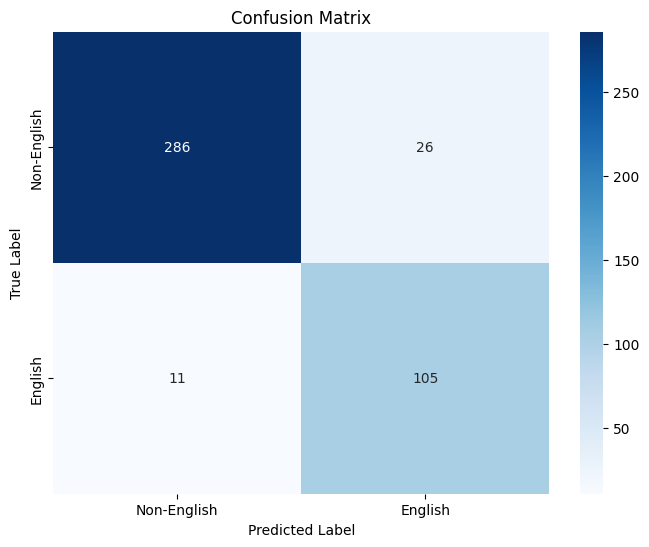

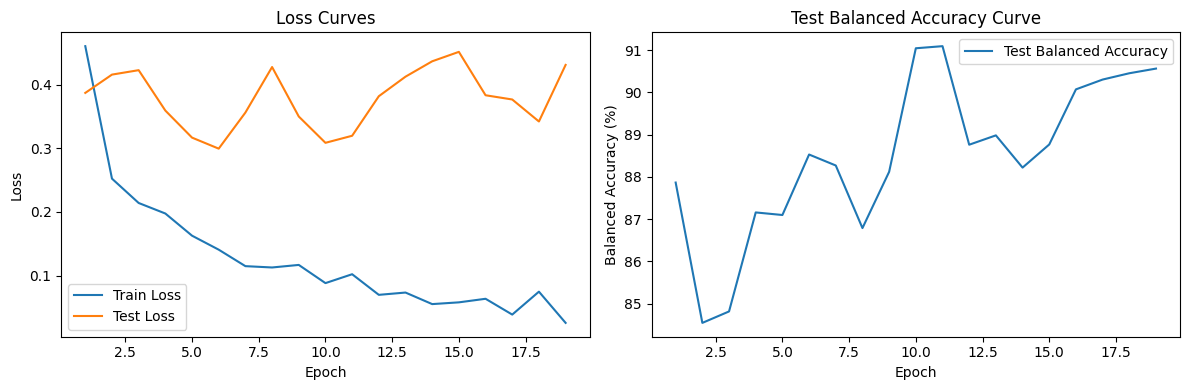

Script finished.


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio
from torchaudio import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from google.colab import drive

# Google Drive path for saving (make sure it's mounted earlier!)
DRIVE_SAVE_DIR = '/content/drive/MyDrive/Colab_Models/SpeechAccent_v5/'
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)

# Load and Prepare Metadata
metadata_full = pd.read_csv("recordings/metadata_wav.csv")
metadata_full.dropna(subset=['wav_path'], inplace=True)
metadata_full['is_english'] = metadata_full['native_language'].apply(
    lambda x: 1 if isinstance(x, str) and 'english' in x.lower() else 0
).astype(int)
print(f"Full dataset class distribution:\n{metadata_full['is_english'].value_counts()}")
print(f"Total samples in full dataset: {len(metadata_full)}")

# Custom Dataset
class SpeechAccentDataset(Dataset):
    def __init__(self, metadata_df, feature_extractor, target_sample_rate=16000, max_length_seconds=10):
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.target_sample_rate = target_sample_rate
        self.max_samples = target_sample_rate * max_length_seconds

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        file_path = row['wav_path']
        label = row['is_english']
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception:
            return {'input_values': torch.zeros(self.max_samples), 'label': torch.tensor(-1, dtype=torch.long)}
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sample_rate != self.target_sample_rate:
            waveform = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)
        waveform = waveform.squeeze(0)
        current_length = waveform.shape[0]
        if current_length > self.max_samples: waveform = waveform[:self.max_samples]
        elif current_length < self.max_samples:
            waveform = torch.nn.functional.pad(waveform, (0, self.max_samples - current_length))
        processed = self.feature_extractor(
            waveform.numpy(), sampling_rate=self.target_sample_rate, return_tensors="pt",
            padding="max_length", max_length=self.max_samples, truncation=True
        )
        return {'input_values': processed.input_values.squeeze(0), 'label': torch.tensor(label, dtype=torch.long)}

# Classifier Model
class Wav2VecClassifier(nn.Module):
    def __init__(self, num_classes=2, model_name="facebook/wav2vec2-base", num_layers_to_unfreeze=2):
        super(Wav2VecClassifier, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(model_name)
        for param in self.wav2vec.parameters(): param.requires_grad = False

        if hasattr(self.wav2vec, 'feature_projector') and self.wav2vec.feature_projector is not None:
            for param in self.wav2vec.feature_projector.parameters():
                param.requires_grad = True
            print("Unfroze Wav2Vec2 feature_projector.")
        if hasattr(self.wav2vec, 'encoder') and hasattr(self.wav2vec.encoder, 'layers') and num_layers_to_unfreeze > 0:
            num_total_layers = len(self.wav2vec.encoder.layers)
            start_layer_idx = num_total_layers - num_layers_to_unfreeze
            actual_unfrozen_count = 0
            for i in range(max(0, start_layer_idx), num_total_layers):
                for param in self.wav2vec.encoder.layers[i].parameters():
                    param.requires_grad = True
                actual_unfrozen_count +=1
            print(f"Unfroze the last {actual_unfrozen_count} Wav2Vec2 transformer layers.")

        self.classifier = nn.Sequential(
            nn.Linear(self.wav2vec.config.hidden_size, 256),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, input_values):
        if input_values.ndim == 1: input_values = input_values.unsqueeze(0)
        outputs = self.wav2vec(input_values).last_hidden_state
        embeddings = torch.mean(outputs, dim=1)
        return self.classifier(embeddings)

# Setup DataLoaders, Model, Loss, Optimizer
hf_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
train_df, test_df = train_test_split(
    metadata_full, test_size=0.20, random_state=42,
    stratify=metadata_full['is_english'] if len(metadata_full['is_english'].unique()) > 1 else None
)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")
train_dataset = SpeechAccentDataset(train_df, hf_feature_extractor)
test_dataset = SpeechAccentDataset(test_df, hf_feature_extractor)

sampler = None
class_weights_tensor = None
if not train_df.empty:
    train_class_counts = train_df['is_english'].value_counts().sort_index()
    print(f"Training set class distribution: {train_class_counts}")
    if len(train_class_counts) == 2:
        weight_per_class = 1. / train_class_counts.values
        sample_weights_val = train_df['is_english'].map(lambda x: weight_per_class[x]).to_numpy()
        sample_weights = torch.from_numpy(sample_weights_val).double()
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler for training.")
        class_weights_list = [len(train_df) / count if count > 0 else 0 for count in train_class_counts]
        total_weight_sum = sum(class_weights_list)
        if total_weight_sum > 0: class_weights_list = [w / total_weight_sum * len(train_class_counts) for w in class_weights_list]
        class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float32)
        print(f"Calculated class weights for CrossEntropyLoss: {class_weights_tensor}")

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False if sampler else True, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = Wav2VecClassifier(num_layers_to_unfreeze=2).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None)
print(f"Using {'weighted' if class_weights_tensor is not None else 'unweighted'} CrossEntropyLoss.")
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5, weight_decay=0.01)
print(f"Optimizer: AdamW with lr=3e-5 and weight_decay=0.01")

# Training Loop
NUM_EPOCHS = 25
best_val_metric = 0.0
epochs_no_improve = 0
PATIENCE_EARLY_STOP = 8
train_losses, test_losses, test_bal_accuracies = [], [], []
# Save path to use the Drive directory - GOOGLE
model_save_path = os.path.join(DRIVE_SAVE_DIR, 'best_english_classifier_final.pt')

print(f"\nStarting training for up to {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    model.train()
    current_train_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for batch in train_iterator:
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item(), 'lr': optimizer.param_groups[0]['lr']})
    avg_train_loss = current_train_loss / len(train_loader) if len(train_loader) > 0 else 0
    train_losses.append(avg_train_loss)

    model.eval()
    current_test_loss = 0.0
    all_epoch_preds, all_epoch_labels = [], []
    test_iterator = tqdm(test_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Test]')
    with torch.no_grad():
        for batch in test_iterator:
            if batch['label'][0] == -1: continue
            input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
            outputs = model(input_values)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_epoch_preds.extend(predicted.cpu().numpy())
            all_epoch_labels.extend(labels.cpu().numpy())
    avg_test_loss = current_test_loss / len(test_loader) if len(test_loader) > 0 else 0
    current_bal_accuracy = balanced_accuracy_score(all_epoch_labels, all_epoch_preds) * 100 if all_epoch_labels and all_epoch_preds else 0
    test_losses.append(avg_test_loss)
    test_bal_accuracies.append(current_bal_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Bal. Acc: {current_bal_accuracy:.2f}%")
    if all_epoch_labels and all_epoch_preds:
        print(classification_report(all_epoch_labels, all_epoch_preds, target_names=['Non-English', 'English'], zero_division=0))

    if current_bal_accuracy > best_val_metric:
        best_val_metric = current_bal_accuracy
        torch.save(model.state_dict(), model_save_path) # DRIVE PATH
        print(f"  New best model saved to {model_save_path} (Bal. Acc: {best_val_metric:.2f}%)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  No improvement in val balanced accuracy for {epochs_no_improve} epoch(s). Best: {best_val_metric:.2f}%")

    if epochs_no_improve >= PATIENCE_EARLY_STOP:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break
print("\nTraining finished.")

# Final Evaluation & Reporting Metrics
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f"\nLoaded best model from {model_save_path} for final evaluation.")
else:
    print(f"\nWarning: Saved model {model_save_path} not found. Evaluating current model state.")

model.eval()
final_all_preds, final_all_labels = [], []
actual_epochs_run = len(train_losses)

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Final Evaluation'):
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        outputs = model(input_values)
        _, predicted = torch.max(outputs.data, 1)
        final_all_preds.extend(predicted.cpu().numpy())
        final_all_labels.extend(labels.cpu().numpy())

if final_all_labels and final_all_preds:
    print("\nFinal Classification Report (Test Set from Full Data):")
    print(classification_report(final_all_labels, final_all_preds, target_names=['Non-English', 'English'], zero_division=0))
    final_bal_acc = balanced_accuracy_score(final_all_labels, final_all_preds) * 100
    print(f"Final Balanced Accuracy: {final_bal_acc:.2f}%")

    cm = confusion_matrix(final_all_labels, final_all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-English', 'English'],
                yticklabels=['Non-English', 'English'])
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix')
    plt.savefig(os.path.join(DRIVE_SAVE_DIR, 'confusion_matrix_final.png')) # SAVES
    plt.show()
else:
    print("No data/predictions for final report and confusion matrix.")

# Plot Training Curves
if actual_epochs_run > 0 :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, actual_epochs_run + 1), train_losses, label='Train Loss')
    plt.plot(range(1, actual_epochs_run + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, actual_epochs_run + 1), test_bal_accuracies, label='Test Balanced Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Balanced Accuracy (%)'); plt.legend(); plt.title('Test Balanced Accuracy Curve')
    plt.tight_layout()
    plt.savefig(os.path.join(DRIVE_SAVE_DIR, 'training_curves_final.png'))
    plt.show()
print("Script finished.")

## Multiclass Region Prediction

### Add Region Column

In [ ]:
metadata_full = pd.read_csv("recordings/metadata_wav.csv")
metadata_full.dropna(subset=['wav_path'], inplace=True)

In [ ]:
metadata_full['country_for_mapping'] = metadata_full['country'].astype(str).str.lower().str.strip()

In [ ]:
metadata_full.loc[(metadata_full['filename'] == 'lao2') & (metadata_full['country'].isna()), 'country'] = 'laos'

In [ ]:
metadata_full.dropna(subset=['country'], inplace=True)

In [ ]:
import pandas as pd
import numpy as np

# metadata_full = pd.read_csv("recordings/metadata_wav.csv")

metadata_full['country_normalized'] = metadata_full['country'].astype(str).str.lower().str.strip()

nan_country_rows = metadata_full[metadata_full['country_normalized'] == 'nan']
if not nan_country_rows.empty:
    print(f"\nWarning: Found {len(nan_country_rows)} samples where the normalized country is 'nan'.")
    print("These will be mapped to 'Other_Region_Unmapped' and likely consolidated.")

# Set country name variations
corrections = {
    'usa': 'united states', 'uk': 'united kingdom', 'republic of georgia': 'georgia',
    'israel (occupied territory)': 'israel', 'slovak republic': 'slovakia',
    'bosnia': 'bosnia and herzegovina', 'virginia': 'united states',
    'sicily': 'italy', 'the bahamas': 'bahamas', 'romanian': 'romania'
}
metadata_full['country_normalized'] = metadata_full['country_normalized'].replace(corrections)

# region_definitions = {  # region mappings 1
#     "UK_Ireland": ['united kingdom', 'ireland', 'isle of man', 'uk'],
#     "North_America_Eng": ['united states', 'canada', 'usa', 'virginia'],
#     "Australia_New_Zealand": ['australia', 'new zealand'],
#     "Western_Europe": [
#         'france', 'germany', 'netherlands', 'belgium', 'austria', 'switzerland', 'liechtenstein', 'luxembourg',
#         'spain', 'portugal', 'andorra'
#     ],
#     "Northern_Europe": ['denmark', 'finland', 'iceland', 'norway', 'sweden', 'estonia', 'latvia', 'lithuania', 'faroe islands'],
#     "Central_Europe": ['poland', 'czech republic', 'slovakia', 'hungary'],
#     "Southeastern_Europe": ['italy', 'greece', 'malta', 'cyprus', 'albania', 'kosovo', 'bosnia and herzegovina', 'bosnia', 'croatia', 'macedonia', 'montenegro', 'serbia', 'slovenia', 'romania', 'romanian', 'bulgaria', 'moldova', 'yugoslavia'],
#     "Eastern_Europe": ['russia', 'ukraine', 'belarus'],
#     "North_Africa": [
#         'morocco', 'egypt', 'tunisia', 'algeria', 'libya', 'sudan' # Sudan is often on the cusp, placing here for now
#     ],
#     "Sub_Saharan_Africa": [
#         'south africa', 'ivory coast', 'ghana', 'ethiopia', 'cameroon', 'guinea', 'mali', 'senegal', 'zambia',
#         'malawi', 'nigeria', 'equatorial guinea', 'togo', 'uganda', 'democratic republic of congo',
#         'gabon', 'burkina faso', 'angola', 'botswana', 'kenya', 'tanzania', 'sierra leone',
#         'madagascar', 'mauritius', 'namibia', 'niger', 'rwanda', 'chad', 'lesotho', 'zimbabwe',
#         'somalia', 'benin', 'eritrea', 'liberia', 'burundi'
#     ],
#     "Western_Asia_Middle_East": [
#         'saudi arabia', 'israel', 'lebanon', 'qatar', 'iraq', 'jordan', 'kuwait', 'syria',
#         'united arab emirates', 'iran', 'turkey', 'yemen', 'oman', 'bahrain',
#         'azerbaijan', 'armenia', 'georgia'
#     ],
#     "Central_Asia": ['afghanistan', 'kazakhstan', 'kyrgyzstan', 'uzbekistan', 'tajikistan', 'turkmenistan'],
#     "Southern_Asia": ['bangladesh', 'india', 'pakistan', 'nepal', 'sri lanka'],
#     "Eastern_Asia": ['china', 'japan', 'south korea', 'mongolia', 'taiwan', 'tibet'],
#     "SE_Asia_Oceania": [
#         'myanmar', 'philippines', 'malaysia', 'singapore', 'indonesia', 'thailand', 'vietnam', 'laos', 'cambodia', 'timor-leste',
#         'fiji', 'papua new guinea', 'solomon islands',
#         'federated states of micronesia', 'northern mariana islands'
#     ],
#     "Latin_America": [
#         'mexico', 'panama', 'puerto rico', 'honduras', 'nicaragua', 'el salvador', 'costa rica', 'dominican republic',
#         'cuba', 'guatemala', 'belize', 'jamaica', 'haiti', 'trinidad', 'barbados', 'antigua and barbuda', 'bahamas',
#         'us virgin islands', 'curacao', 'martinique',
#         'brazil', 'argentina', 'colombia', 'peru', 'venezuela', 'chile', 'ecuador', 'bolivia', 'uruguay', 'guyana'
#     ]
# }


# region_definitions = { # region mappings 3
#     "North_America": [
#         'united states', 'canada', 'usa', 'virginia'
#     ],

#     "British_Isles": [
#         'united kingdom', 'ireland', 'isle of man', 'uk'
#     ],

#     "Australia_NZ": [
#         'australia', 'new zealand'
#     ],

#     "Caribbean_Central_America": [
#         'jamaica', 'haiti', 'trinidad', 'barbados', 'antigua and barbuda', 'bahamas',
#         'cuba', 'dominican republic', 'puerto rico', 'guatemala', 'honduras',
#         'nicaragua', 'el salvador', 'costa rica', 'panama', 'belize',
#         'us virgin islands', 'curacao', 'martinique'
#     ],

#     "South_America": [
#         'mexico', 'brazil', 'argentina', 'colombia', 'peru', 'venezuela',
#         'chile', 'ecuador', 'bolivia', 'uruguay', 'guyana'
#     ],

#     "W_Central_Europe": [
#         'france', 'germany', 'netherlands', 'belgium', 'austria', 'switzerland',
#         'liechtenstein', 'luxembourg', 'andorra', 'monaco', 'italy', 'spain', 'portugal'
#     ],

#     "ESE_Europe": [
#         'poland', 'czech republic', 'slovakia', 'hungary', 'romania', 'bulgaria',
#         'slovenia', 'croatia', 'serbia', 'montenegro', 'bosnia and herzegovina', 'bosnia',
#         'macedonia', 'albania', 'kosovo', 'greece', 'cyprus', 'moldova', 'yugoslavia', 'malta'
#     ],

#     "Nordic_Baltic": [
#         'denmark', 'norway', 'sweden', 'finland', 'iceland', 'estonia', 'latvia',
#         'lithuania', 'faroe islands'
#     ],

#     "Former_Soviet_Union": [
#         'russia', 'ukraine', 'belarus', 'kazakhstan', 'armenia', 'azerbaijan', 'georgia',
#         'uzbekistan', 'turkmenistan', 'kyrgyzstan', 'tajikistan', 'republic of georgia'
#     ],

#     "Middle_East_N_Africa": [
#         'saudi arabia', 'israel', 'lebanon', 'qatar', 'iraq', 'jordan', 'kuwait', 'syria',
#         'united arab emirates', 'iran', 'turkey', 'yemen', 'oman', 'bahrain',
#         'morocco', 'egypt', 'tunisia', 'algeria', 'libya', 'sudan'
#     ],

#     "S_Asia": [
#         'india', 'pakistan', 'bangladesh', 'nepal', 'sri lanka', 'afghanistan'
#     ],

#     "Sub_Saharan_Africa": [
#         'south africa', 'nigeria', 'ghana', 'kenya', 'uganda', 'zambia', 'malawi',
#         'ethiopia', 'cameroon', 'ivory coast', 'tanzania', 'botswana', 'namibia',
#         'lesotho', 'zimbabwe', 'rwanda', 'burundi', 'somalia', 'sierra leone',
#         'liberia', 'gabon', 'chad', 'mali', 'senegal', 'benin', 'togo', 'guinea',
#         'equatorial guinea', 'democratic republic of congo', 'angola',
#         'burkina faso', 'madagascar', 'mauritius', 'niger', 'eritrea'
#     ],

#     "ESE_Asia_Pacific": [
#         'china', 'japan', 'south korea', 'taiwan', 'mongolia', 'tibet', 'myanmar',
#         'thailand', 'vietnam', 'cambodia', 'laos', 'malaysia', 'singapore',
#         'indonesia', 'philippines', 'timor-leste', 'fiji', 'solomon islands',
#         'papua new guinea', 'federated states of micronesia', 'northern mariana islands'
#     ]
# }

region_definitions = { # v2, tested in later models
    "North_America": [
        'united states', 'canada', 'usa', 'virginia'
    ],

    "British_Isles": [
        'united kingdom', 'ireland', 'isle of man', 'uk'
    ],

    "Australia_NZ": [
        'australia', 'new zealand'
    ],

    "Caribbean_Central_America": [
        'jamaica', 'haiti', 'trinidad', 'barbados', 'antigua and barbuda', 'bahamas',
        'cuba', 'dominican republic', 'puerto rico', 'guatemala', 'honduras',
        'nicaragua', 'el salvador', 'costa rica', 'panama', 'belize',
        'us virgin islands', 'curacao', 'martinique'
    ],

    "South_America": [
        'mexico', 'brazil', 'argentina', 'colombia', 'peru', 'venezuela',
        'chile', 'ecuador', 'bolivia', 'uruguay', 'guyana'
    ],

    "W_Central_Europe": [
        'france', 'germany', 'netherlands', 'belgium', 'austria', 'switzerland',
        'liechtenstein', 'luxembourg', 'andorra', 'monaco', 'italy', 'spain', 'portugal'
    ],

    "ESE_Europe": [
        'poland', 'czech republic', 'slovakia', 'hungary', 'romania', 'bulgaria',
        'slovenia', 'croatia', 'serbia', 'montenegro', 'bosnia and herzegovina', 'bosnia',
        'macedonia', 'albania', 'kosovo', 'greece', 'cyprus', 'moldova', 'yugoslavia', 'malta'
    ],

    "Nordic_Baltic": [
        'denmark', 'norway', 'sweden', 'finland', 'iceland', 'estonia', 'latvia',
        'lithuania', 'faroe islands'
    ],

    "Former_Soviet_Union": [
        'russia', 'ukraine', 'belarus', 'kazakhstan', 'armenia', 'azerbaijan', 'georgia',
        'uzbekistan', 'turkmenistan', 'kyrgyzstan', 'tajikistan', 'republic of georgia'
    ],

    "Middle_East_N_Africa": [
        'saudi arabia', 'israel', 'lebanon', 'qatar', 'iraq', 'jordan', 'kuwait', 'syria',
        'united arab emirates', 'iran', 'turkey', 'yemen', 'oman', 'bahrain',
        'morocco', 'egypt', 'tunisia', 'algeria', 'libya', 'sudan'
    ],

    "S_Asia": [
        'india', 'pakistan', 'bangladesh', 'nepal', 'sri lanka', 'afghanistan'
    ],

    "Sub_Saharan_Africa": [
        'south africa', 'nigeria', 'ghana', 'kenya', 'uganda', 'zambia', 'malawi',
        'ethiopia', 'cameroon', 'ivory coast', 'tanzania', 'botswana', 'namibia',
        'lesotho', 'zimbabwe', 'rwanda', 'burundi', 'somalia', 'sierra leone',
        'liberia', 'gabon', 'chad', 'mali', 'senegal', 'benin', 'togo', 'guinea',
        'equatorial guinea', 'democratic republic of congo', 'angola',
        'burkina faso', 'madagascar', 'mauritius', 'niger', 'eritrea'
    ],

    "SE_Asia_Pacific": [
        'thailand', 'vietnam', 'cambodia', 'laos', 'malaysia', 'singapore',
        'indonesia', 'philippines', 'timor-leste', 'fiji', 'solomon islands',
        'papua new guinea', 'federated states of micronesia', 'northern mariana islands'
    ],

    "E_Asia": [
        'china', 'japan', 'south korea', 'taiwan', 'mongolia', 'tibet', 'myanmar'
    ]
}


# Create a Reverse Map and Apply
country_to_region_direct_map = {country: region
                               for region, countries in region_definitions.items()
                               for country in countries}

def map_country_to_region(country_norm_val):
    return country_to_region_direct_map.get(country_norm_val, 'Other_Region_Unmapped')

metadata_full['speech_region'] = metadata_full['country_normalized'].apply(map_country_to_region)

print("\nFinal Speech Region distribution:")
print(metadata_full['speech_region'].value_counts().sort_values(ascending=False))


Final Speech Region distribution:
speech_region
North_America                446
E_Asia                       197
Middle_East_N_Africa         193
Sub_Saharan_Africa           192
W_Central_Europe             192
ESE_Europe                   184
South_America                141
S_Asia                       127
SE_Asia_Pacific              113
Former_Soviet_Union           85
British_Isles                 81
Caribbean_Central_America     81
Nordic_Baltic                 61
Australia_NZ                  41
Name: count, dtype: int64


In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
metadata_full['speech_region_encoded'] = label_encoder.fit_transform(metadata_full['speech_region'])
NUM_REGIONAL_CLASSES = len(label_encoder.classes_)
region_mapping_for_model = {i: label for i, label in enumerate(label_encoder.classes_)}
print(f"\nNumber of final speech regions for model: {NUM_REGIONAL_CLASSES}")
print(f"Region encoding mapping for model: {region_mapping_for_model}")


Number of final speech regions for model: 14
Region encoding mapping for model: {0: 'Australia_NZ', 1: 'British_Isles', 2: 'Caribbean_Central_America', 3: 'ESE_Europe', 4: 'E_Asia', 5: 'Former_Soviet_Union', 6: 'Middle_East_N_Africa', 7: 'Nordic_Baltic', 8: 'North_America', 9: 'SE_Asia_Pacific', 10: 'S_Asia', 11: 'South_America', 12: 'Sub_Saharan_Africa', 13: 'W_Central_Europe'}


### Region Mappings 1

Models and plots for regional model will be saved to: /content/drive/MyDrive/Colab_Models/SpeechAccent_Regional_v1/
Training set size: 1707, Test set size: 427
Training set regional distribution (encoded):
speech_region_encoded
0      33
1      65
2      65
3     248
4     147
5      68
6     154
7      49
8     357
9     102
10    113
11    153
12    153
Name: count, dtype: int64
Using WeightedRandomSampler for multi-class regional training.
Calculated multi-class weights for CrossEntropyLoss: tensor([2.6610, 1.3510, 1.3510, 0.3541, 0.5974, 1.2914, 0.5702, 1.7921, 0.2460,
        0.8609, 0.7771, 0.5739, 0.5739])
Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Unfroze the last 2 Wav2Vec2 transformer layers.
Using weighted CrossEntropyLoss for multi-class.
Optimizer: AdamW with lr=3e-5 and weight_decay=0.01

Starting regional model training for up to 25 epochs...


Epoch 1/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 1/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1/25: Train Loss: 2.4201, Test Loss: 2.6378, Test Macro F1: 1.90%
                           precision    recall  f1-score   support

             Australia_NZ       0.04      0.12      0.06         8
            British_Isles       0.00      0.00      0.00        16
Caribbean_Central_America       0.00      0.00      0.00        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.06      0.71      0.11        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.04      0.67      0.07        12
            North_America       0.00      0.00      0.00        89
                   S_Asia       0.00      0.00      0.00        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.00      0.00      0.00        39
         W_Central_Europe       0.00      0.00      0.00

Epoch 2/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 2/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2/25: Train Loss: 2.1516, Test Loss: 2.5370, Test Macro F1: 2.92%
                           precision    recall  f1-score   support

             Australia_NZ       0.08      1.00      0.15         8
            British_Isles       0.03      0.06      0.04        16
Caribbean_Central_America       0.07      0.50      0.12        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.00      0.00      0.00        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.04      0.58      0.08        12
            North_America       0.00      0.00      0.00        89
                   S_Asia       0.00      0.00      0.00        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.00      0.00      0.00        39
         W_Central_Europe       0.00      0.00      0.00

Epoch 3/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 3/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3/25: Train Loss: 1.8616, Test Loss: 2.3652, Test Macro F1: 8.86%
                           precision    recall  f1-score   support

             Australia_NZ       0.27      0.88      0.41         8
            British_Isles       0.08      0.50      0.14        16
Caribbean_Central_America       0.09      0.25      0.14        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.09      0.53      0.15        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.06      0.50      0.11        12
            North_America       0.00      0.00      0.00        89
                   S_Asia       0.14      0.36      0.20        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.00      0.00      0.00        39
         W_Central_Europe       0.00      0.00      0.00

Epoch 4/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 4/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4/25: Train Loss: 1.6184, Test Loss: 2.2821, Test Macro F1: 9.68%
                           precision    recall  f1-score   support

             Australia_NZ       0.29      1.00      0.44         8
            British_Isles       0.20      0.56      0.30        16
Caribbean_Central_America       0.06      0.62      0.11        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.15      0.41      0.22        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.07      0.58      0.12        12
            North_America       0.00      0.00      0.00        89
                   S_Asia       0.07      0.08      0.08        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.00      0.00      0.00        39
         W_Central_Europe       0.00      0.00      0.00

Epoch 5/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 5/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5/25: Train Loss: 1.4747, Test Loss: 2.2586, Test Macro F1: 9.86%
                           precision    recall  f1-score   support

             Australia_NZ       0.22      1.00      0.36         8
            British_Isles       0.15      0.44      0.22        16
Caribbean_Central_America       0.06      0.44      0.10        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.15      0.41      0.22        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.07      0.50      0.12        12
            North_America       0.00      0.00      0.00        89
                   S_Asia       0.10      0.32      0.16        25
            South_America       0.20      0.07      0.11        28
       Sub_Saharan_Africa       0.00      0.00      0.00        39
         W_Central_Europe       0.00      0.00      0.00

Epoch 6/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 6/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6/25: Train Loss: 1.3684, Test Loss: 2.2631, Test Macro F1: 11.96%
                           precision    recall  f1-score   support

             Australia_NZ       0.22      0.88      0.35         8
            British_Isles       0.24      0.50      0.32        16
Caribbean_Central_America       0.06      0.56      0.12        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.67      0.05      0.10        37
      Former_Soviet_Union       0.18      0.65      0.28        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.06      0.50      0.11        12
            North_America       0.00      0.00      0.00        89
                   S_Asia       0.12      0.24      0.16        25
            South_America       0.33      0.07      0.12        28
       Sub_Saharan_Africa       0.00      0.00      0.00        39
         W_Central_Europe       0.00      0.00      0.0

Epoch 7/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 7/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7/25: Train Loss: 1.2567, Test Loss: 2.2691, Test Macro F1: 17.60%
                           precision    recall  f1-score   support

             Australia_NZ       0.22      1.00      0.36         8
            British_Isles       0.27      0.56      0.37        16
Caribbean_Central_America       0.11      0.50      0.17        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.43      0.16      0.24        37
      Former_Soviet_Union       0.16      0.35      0.22        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.10      0.25      0.15        12
            North_America       0.88      0.08      0.14        89
                   S_Asia       0.11      0.60      0.19        25
            South_America       0.22      0.14      0.17        28
       Sub_Saharan_Africa       0.19      0.18      0.18        39
         W_Central_Europe       0.67      0.05      0.1

Epoch 8/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 8/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8/25: Train Loss: 1.1346, Test Loss: 2.2401, Test Macro F1: 17.99%
                           precision    recall  f1-score   support

             Australia_NZ       0.32      0.88      0.47         8
            British_Isles       0.26      0.56      0.36        16
Caribbean_Central_America       0.09      0.44      0.14        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.43      0.16      0.24        37
      Former_Soviet_Union       0.12      0.41      0.19        17
     Middle_East_N_Africa       0.12      0.03      0.04        39
            Nordic_Baltic       0.10      0.42      0.17        12
            North_America       0.88      0.08      0.14        89
                   S_Asia       0.12      0.56      0.20        25
            South_America       0.29      0.14      0.19        28
       Sub_Saharan_Africa       0.30      0.15      0.20        39
         W_Central_Europe       0.00      0.00      0.0

Epoch 9/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 9/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9/25: Train Loss: 0.9920, Test Loss: 2.1063, Test Macro F1: 23.31%
                           precision    recall  f1-score   support

             Australia_NZ       0.50      0.62      0.56         8
            British_Isles       0.26      0.69      0.38        16
Caribbean_Central_America       0.17      0.44      0.25        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.22      0.22      0.22        37
      Former_Soviet_Union       0.18      0.53      0.27        17
     Middle_East_N_Africa       0.14      0.03      0.04        39
            Nordic_Baltic       0.17      0.33      0.22        12
            North_America       0.70      0.35      0.47        89
                   S_Asia       0.21      0.40      0.27        25
            South_America       0.10      0.36      0.15        28
       Sub_Saharan_Africa       0.27      0.08      0.12        39
         W_Central_Europe       0.18      0.05      0.0

Epoch 10/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 10/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10/25: Train Loss: 0.8963, Test Loss: 2.1467, Test Macro F1: 22.54%
                           precision    recall  f1-score   support

             Australia_NZ       0.45      0.62      0.53         8
            British_Isles       0.20      0.62      0.31        16
Caribbean_Central_America       0.10      0.44      0.16        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.19      0.11      0.14        37
      Former_Soviet_Union       0.27      0.18      0.21        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.20      0.50      0.29        12
            North_America       0.69      0.30      0.42        89
                   S_Asia       0.17      0.52      0.25        25
            South_America       0.13      0.29      0.18        28
       Sub_Saharan_Africa       0.24      0.26      0.25        39
         W_Central_Europe       0.38      0.13      0.

Epoch 11/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 11/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 11/25: Train Loss: 0.8431, Test Loss: 2.3665, Test Macro F1: 22.77%
                           precision    recall  f1-score   support

             Australia_NZ       0.36      1.00      0.53         8
            British_Isles       0.38      0.38      0.38        16
Caribbean_Central_America       0.15      0.31      0.20        16
         ESE_Asia_Pacific       1.00      0.02      0.03        62
               ESE_Europe       0.14      0.08      0.10        37
      Former_Soviet_Union       0.23      0.41      0.30        17
     Middle_East_N_Africa       0.25      0.03      0.05        39
            Nordic_Baltic       0.06      0.58      0.10        12
            North_America       0.83      0.22      0.35        89
                   S_Asia       0.18      0.60      0.28        25
            South_America       0.20      0.18      0.19        28
       Sub_Saharan_Africa       0.41      0.33      0.37        39
         W_Central_Europe       0.29      0.05      0.

Epoch 12/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 12/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 12/25: Train Loss: 0.7250, Test Loss: 2.0296, Test Macro F1: 31.71%
                           precision    recall  f1-score   support

             Australia_NZ       0.40      0.75      0.52         8
            British_Isles       0.50      0.50      0.50        16
Caribbean_Central_America       0.18      0.31      0.23        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.25      0.16      0.20        37
      Former_Soviet_Union       0.25      0.35      0.29        17
     Middle_East_N_Africa       0.15      0.15      0.15        39
            Nordic_Baltic       0.21      0.50      0.29        12
            North_America       0.84      0.54      0.66        89
                   S_Asia       0.27      0.48      0.35        25
            South_America       0.19      0.39      0.26        28
       Sub_Saharan_Africa       0.33      0.54      0.41        39
         W_Central_Europe       0.33      0.23      0.

Epoch 13/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 13/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 13/25: Train Loss: 0.7014, Test Loss: 2.1441, Test Macro F1: 32.19%
                           precision    recall  f1-score   support

             Australia_NZ       0.42      1.00      0.59         8
            British_Isles       0.42      0.50      0.46        16
Caribbean_Central_America       0.23      0.31      0.26        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.31      0.38      0.34        37
      Former_Soviet_Union       0.33      0.18      0.23        17
     Middle_East_N_Africa       0.30      0.15      0.20        39
            Nordic_Baltic       0.20      0.50      0.29        12
            North_America       0.86      0.48      0.62        89
                   S_Asia       0.18      0.80      0.29        25
            South_America       0.23      0.29      0.25        28
       Sub_Saharan_Africa       0.32      0.31      0.31        39
         W_Central_Europe       0.42      0.28      0.

Epoch 14/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 14/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 14/25: Train Loss: 0.6031, Test Loss: 2.1590, Test Macro F1: 31.02%
                           precision    recall  f1-score   support

             Australia_NZ       0.54      0.88      0.67         8
            British_Isles       0.42      0.62      0.50        16
Caribbean_Central_America       0.16      0.31      0.21        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.32      0.32      0.32        37
      Former_Soviet_Union       0.33      0.18      0.23        17
     Middle_East_N_Africa       0.23      0.21      0.22        39
            Nordic_Baltic       0.22      0.50      0.31        12
            North_America       0.79      0.55      0.65        89
                   S_Asia       0.20      0.68      0.30        25
            South_America       0.12      0.32      0.18        28
       Sub_Saharan_Africa       0.56      0.13      0.21        39
         W_Central_Europe       0.33      0.18      0.

Epoch 15/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 15/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 15/25: Train Loss: 0.5439, Test Loss: 2.3197, Test Macro F1: 29.22%
                           precision    recall  f1-score   support

             Australia_NZ       0.38      1.00      0.55         8
            British_Isles       0.27      0.56      0.37        16
Caribbean_Central_America       0.12      0.56      0.20        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.47      0.24      0.32        37
      Former_Soviet_Union       0.36      0.24      0.29        17
     Middle_East_N_Africa       0.21      0.13      0.16        39
            Nordic_Baltic       0.22      0.50      0.31        12
            North_America       0.94      0.33      0.48        89
                   S_Asia       0.17      0.64      0.27        25
            South_America       0.19      0.25      0.22        28
       Sub_Saharan_Africa       0.35      0.36      0.35        39
         W_Central_Europe       0.42      0.21      0.

Epoch 16/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 16/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 16/25: Train Loss: 0.5146, Test Loss: 2.0883, Test Macro F1: 36.00%
                           precision    recall  f1-score   support

             Australia_NZ       0.47      1.00      0.64         8
            British_Isles       0.44      0.69      0.54        16
Caribbean_Central_America       0.17      0.38      0.24        16
         ESE_Asia_Pacific       0.50      0.03      0.06        62
               ESE_Europe       0.26      0.35      0.30        37
      Former_Soviet_Union       0.29      0.29      0.29        17
     Middle_East_N_Africa       0.23      0.18      0.20        39
            Nordic_Baltic       0.20      0.50      0.29        12
            North_America       0.79      0.60      0.68        89
                   S_Asia       0.38      0.68      0.49        25
            South_America       0.16      0.32      0.21        28
       Sub_Saharan_Africa       0.46      0.28      0.35        39
         W_Central_Europe       0.50      0.33      0.

Epoch 17/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 17/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 17/25: Train Loss: 0.4806, Test Loss: 2.1256, Test Macro F1: 33.83%
                           precision    recall  f1-score   support

             Australia_NZ       0.39      0.88      0.54         8
            British_Isles       0.55      0.38      0.44        16
Caribbean_Central_America       0.20      0.38      0.26        16
         ESE_Asia_Pacific       0.67      0.03      0.06        62
               ESE_Europe       0.27      0.27      0.27        37
      Former_Soviet_Union       0.29      0.24      0.26        17
     Middle_East_N_Africa       0.23      0.33      0.27        39
            Nordic_Baltic       0.24      0.50      0.32        12
            North_America       0.76      0.66      0.71        89
                   S_Asia       0.29      0.64      0.40        25
            South_America       0.23      0.29      0.25        28
       Sub_Saharan_Africa       0.35      0.44      0.39        39
         W_Central_Europe       0.35      0.15      0.

Epoch 18/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 18/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 18/25: Train Loss: 0.4434, Test Loss: 2.1649, Test Macro F1: 37.98%
                           precision    recall  f1-score   support

             Australia_NZ       0.56      0.62      0.59         8
            British_Isles       0.62      0.50      0.55        16
Caribbean_Central_America       0.27      0.38      0.32        16
         ESE_Asia_Pacific       0.58      0.11      0.19        62
               ESE_Europe       0.31      0.43      0.36        37
      Former_Soviet_Union       0.38      0.29      0.33        17
     Middle_East_N_Africa       0.20      0.21      0.20        39
            Nordic_Baltic       0.36      0.42      0.38        12
            North_America       0.82      0.70      0.75        89
                   S_Asia       0.35      0.72      0.47        25
            South_America       0.12      0.32      0.18        28
       Sub_Saharan_Africa       0.40      0.31      0.35        39
         W_Central_Europe       0.35      0.21      0.

Epoch 19/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 19/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 19/25: Train Loss: 0.3430, Test Loss: 2.2027, Test Macro F1: 37.82%
                           precision    recall  f1-score   support

             Australia_NZ       0.50      1.00      0.67         8
            British_Isles       0.56      0.56      0.56        16
Caribbean_Central_America       0.50      0.31      0.38        16
         ESE_Asia_Pacific       0.44      0.06      0.11        62
               ESE_Europe       0.36      0.32      0.34        37
      Former_Soviet_Union       0.33      0.12      0.17        17
     Middle_East_N_Africa       0.21      0.33      0.26        39
            Nordic_Baltic       0.25      0.42      0.31        12
            North_America       0.79      0.76      0.78        89
                   S_Asia       0.34      0.52      0.41        25
            South_America       0.18      0.21      0.19        28
       Sub_Saharan_Africa       0.36      0.51      0.42        39
         W_Central_Europe       0.29      0.31      0.

Epoch 20/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 20/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 20/25: Train Loss: 0.3505, Test Loss: 2.2878, Test Macro F1: 37.60%
                           precision    recall  f1-score   support

             Australia_NZ       0.60      0.75      0.67         8
            British_Isles       0.58      0.44      0.50        16
Caribbean_Central_America       0.23      0.38      0.29        16
         ESE_Asia_Pacific       0.80      0.06      0.12        62
               ESE_Europe       0.34      0.51      0.41        37
      Former_Soviet_Union       1.00      0.06      0.11        17
     Middle_East_N_Africa       0.22      0.38      0.28        39
            Nordic_Baltic       0.27      0.33      0.30        12
            North_America       0.79      0.75      0.77        89
                   S_Asia       0.30      0.64      0.41        25
            South_America       0.20      0.29      0.24        28
       Sub_Saharan_Africa       0.52      0.36      0.42        39
         W_Central_Europe       0.43      0.33      0.

Epoch 21/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 21/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 21/25: Train Loss: 0.3161, Test Loss: 2.2923, Test Macro F1: 38.48%
                           precision    recall  f1-score   support

             Australia_NZ       0.55      0.75      0.63         8
            British_Isles       0.56      0.62      0.59        16
Caribbean_Central_America       0.16      0.44      0.23        16
         ESE_Asia_Pacific       0.58      0.11      0.19        62
               ESE_Europe       0.33      0.43      0.38        37
      Former_Soviet_Union       0.20      0.06      0.09        17
     Middle_East_N_Africa       0.19      0.46      0.27        39
            Nordic_Baltic       0.60      0.25      0.35        12
            North_America       0.82      0.75      0.78        89
                   S_Asia       0.52      0.52      0.52        25
            South_America       0.27      0.25      0.26        28
       Sub_Saharan_Africa       0.43      0.26      0.32        39
         W_Central_Europe       0.41      0.36      0.

Epoch 22/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 22/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 22/25: Train Loss: 0.2798, Test Loss: 2.3081, Test Macro F1: 40.58%
                           precision    recall  f1-score   support

             Australia_NZ       0.50      0.75      0.60         8
            British_Isles       0.62      0.50      0.55        16
Caribbean_Central_America       0.32      0.38      0.34        16
         ESE_Asia_Pacific       0.58      0.18      0.27        62
               ESE_Europe       0.34      0.41      0.37        37
      Former_Soviet_Union       0.22      0.12      0.15        17
     Middle_East_N_Africa       0.21      0.49      0.30        39
            Nordic_Baltic       0.33      0.33      0.33        12
            North_America       0.80      0.76      0.78        89
                   S_Asia       0.40      0.56      0.47        25
            South_America       0.33      0.25      0.29        28
       Sub_Saharan_Africa       0.52      0.38      0.44        39
         W_Central_Europe       0.38      0.38      0.

Epoch 23/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 23/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 23/25: Train Loss: 0.2570, Test Loss: 2.2576, Test Macro F1: 40.49%
                           precision    recall  f1-score   support

             Australia_NZ       0.55      0.75      0.63         8
            British_Isles       0.59      0.62      0.61        16
Caribbean_Central_America       0.33      0.38      0.35        16
         ESE_Asia_Pacific       0.58      0.11      0.19        62
               ESE_Europe       0.28      0.46      0.35        37
      Former_Soviet_Union       0.33      0.18      0.23        17
     Middle_East_N_Africa       0.29      0.41      0.34        39
            Nordic_Baltic       0.24      0.50      0.32        12
            North_America       0.79      0.71      0.75        89
                   S_Asia       0.36      0.64      0.46        25
            South_America       0.17      0.29      0.22        28
       Sub_Saharan_Africa       0.52      0.33      0.41        39
         W_Central_Europe       0.52      0.33      0.

Epoch 24/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 24/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 24/25: Train Loss: 0.2091, Test Loss: 2.3155, Test Macro F1: 41.05%
                           precision    recall  f1-score   support

             Australia_NZ       0.50      0.88      0.64         8
            British_Isles       0.53      0.56      0.55        16
Caribbean_Central_America       0.27      0.38      0.32        16
         ESE_Asia_Pacific       0.42      0.29      0.34        62
               ESE_Europe       0.41      0.30      0.34        37
      Former_Soviet_Union       0.29      0.24      0.26        17
     Middle_East_N_Africa       0.22      0.41      0.29        39
            Nordic_Baltic       0.40      0.50      0.44        12
            North_America       0.81      0.75      0.78        89
                   S_Asia       0.35      0.68      0.47        25
            South_America       0.33      0.18      0.23        28
       Sub_Saharan_Africa       0.43      0.31      0.36        39
         W_Central_Europe       0.39      0.28      0.

Epoch 25/25 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 25/25 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 25/25: Train Loss: 0.1952, Test Loss: 2.3582, Test Macro F1: 40.69%
                           precision    recall  f1-score   support

             Australia_NZ       0.50      0.62      0.56         8
            British_Isles       0.56      0.56      0.56        16
Caribbean_Central_America       0.28      0.31      0.29        16
         ESE_Asia_Pacific       0.59      0.35      0.44        62
               ESE_Europe       0.37      0.41      0.38        37
      Former_Soviet_Union       0.33      0.06      0.10        17
     Middle_East_N_Africa       0.31      0.44      0.37        39
            Nordic_Baltic       0.25      0.33      0.29        12
            North_America       0.77      0.73      0.75        89
                   S_Asia       0.42      0.72      0.53        25
            South_America       0.20      0.32      0.25        28
       Sub_Saharan_Africa       0.71      0.31      0.43        39
         W_Central_Europe       0.33      0.36      0.

Final Evaluation:   0%|          | 0/54 [00:00<?, ?it/s]


Final Classification Report (Test Set - Regional Model):
                           precision    recall  f1-score   support

             Australia_NZ       0.50      0.88      0.64         8
            British_Isles       0.53      0.56      0.55        16
Caribbean_Central_America       0.27      0.38      0.32        16
         ESE_Asia_Pacific       0.42      0.29      0.34        62
               ESE_Europe       0.41      0.30      0.34        37
      Former_Soviet_Union       0.29      0.24      0.26        17
     Middle_East_N_Africa       0.22      0.41      0.29        39
            Nordic_Baltic       0.40      0.50      0.44        12
            North_America       0.81      0.75      0.78        89
                   S_Asia       0.35      0.68      0.47        25
            South_America       0.33      0.18      0.23        28
       Sub_Saharan_Africa       0.43      0.31      0.36        39
         W_Central_Europe       0.39      0.28      0.33        39

  

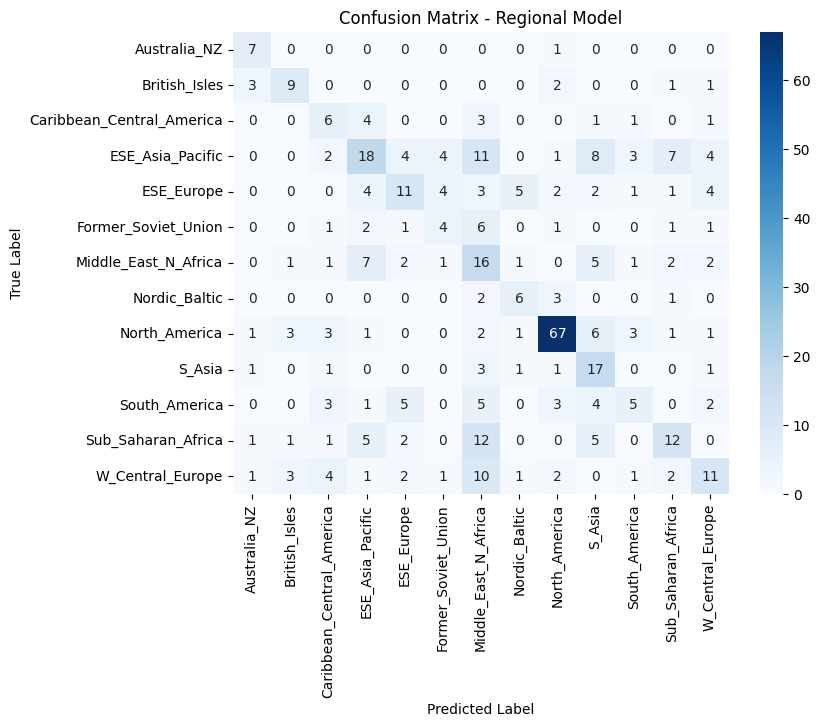

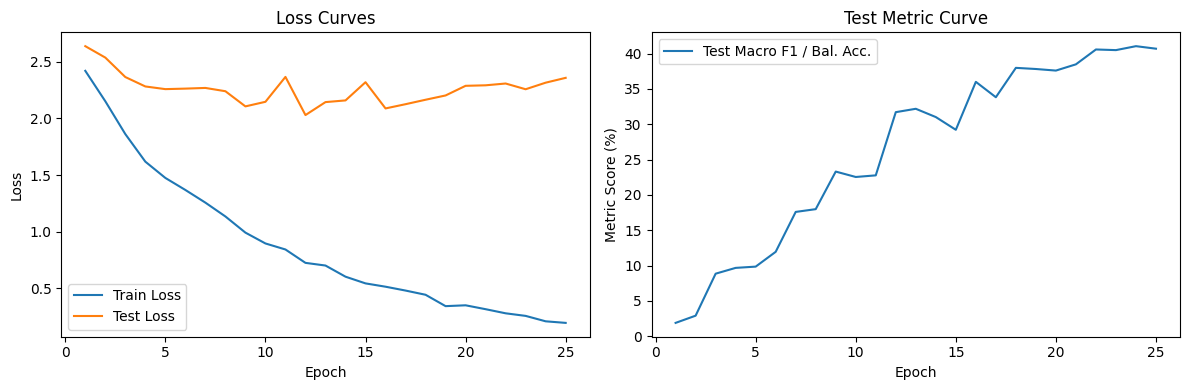

Script finished.


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio
from torchaudio import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from google.colab import drive

# drive.mount('/content/drive', force_remount=True)

DRIVE_MULTICLASS_SAVE_DIR = '/content/drive/MyDrive/Colab_Models/SpeechAccent_Regional_v1/'
os.makedirs(DRIVE_MULTICLASS_SAVE_DIR, exist_ok=True)
print(f"Models and plots for regional model will be saved to: {DRIVE_MULTICLASS_SAVE_DIR}")

# Custom Dataset for Regional Classification
class RegionalSpeechAccentDataset(Dataset):
    def __init__(self, metadata_df, feature_extractor, region_label_column='speech_region_encoded',
                 target_sample_rate=16000, max_length_seconds=10):
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.region_label_column = region_label_column
        self.target_sample_rate = target_sample_rate
        self.max_samples = target_sample_rate * max_length_seconds

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        file_path = row['wav_path']
        label = row[self.region_label_column]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception:
            return {'input_values': torch.zeros(self.max_samples), 'label': torch.tensor(-1, dtype=torch.long)} # Dummy
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sample_rate != self.target_sample_rate:
            waveform = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)
        waveform = waveform.squeeze(0)
        current_length = waveform.shape[0]
        if current_length > self.max_samples: waveform = waveform[:self.max_samples]
        elif current_length < self.max_samples:
            waveform = torch.nn.functional.pad(waveform, (0, self.max_samples - current_length))
        processed = self.feature_extractor(
            waveform.numpy(), sampling_rate=self.target_sample_rate, return_tensors="pt",
            padding="max_length", max_length=self.max_samples, truncation=True
        )
        return {'input_values': processed.input_values.squeeze(0), 'label': torch.tensor(label, dtype=torch.long)}

# Classifier Model
class Wav2VecRegionalClassifier(nn.Module):
    def __init__(self, num_classes, model_name="facebook/wav2vec2-base", num_layers_to_unfreeze=2):
        super(Wav2VecRegionalClassifier, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(model_name)
        for param in self.wav2vec.parameters(): param.requires_grad = False

        if hasattr(self.wav2vec, 'feature_projector') and self.wav2vec.feature_projector is not None:
            for param in self.wav2vec.feature_projector.parameters():
                param.requires_grad = True
            print("Unfroze Wav2Vec2 feature_projector.")
        if hasattr(self.wav2vec, 'encoder') and hasattr(self.wav2vec.encoder, 'layers') and num_layers_to_unfreeze > 0:
            num_total_layers = len(self.wav2vec.encoder.layers)
            start_layer_idx = num_total_layers - num_layers_to_unfreeze
            actual_unfrozen_count = 0
            for i in range(max(0, start_layer_idx), num_total_layers):
                for param in self.wav2vec.encoder.layers[i].parameters():
                    param.requires_grad = True
                actual_unfrozen_count +=1
            print(f"Unfroze the last {actual_unfrozen_count} Wav2Vec2 transformer layers.")

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(self.wav2vec.config.hidden_size, 256),
            nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, input_values):
        if input_values.ndim == 1: input_values = input_values.unsqueeze(0)
        outputs = self.wav2vec(input_values).last_hidden_state
        embeddings = torch.mean(outputs, dim=1)
        return self.classifier(embeddings)


if 'speech_region_encoded' not in metadata_full.columns or 'NUM_REGIONAL_CLASSES' not in globals():
    raise ValueError("Ensure 'metadata_full' has 'speech_region_encoded' and NUM_REGIONAL_CLASSES is globally defined from data prep.")

hf_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")

# Stratify
train_df, test_df = train_test_split(
    metadata_full, test_size=0.20, random_state=42,
    stratify=metadata_full['speech_region_encoded'] if len(metadata_full['speech_region_encoded'].unique()) > 1 else None
)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")

train_dataset = RegionalSpeechAccentDataset(train_df, hf_feature_extractor, region_label_column='speech_region_encoded')
test_dataset = RegionalSpeechAccentDataset(test_df, hf_feature_extractor, region_label_column='speech_region_encoded')

sampler = None
class_weights_tensor = None
if not train_df.empty:
    train_class_counts = train_df['speech_region_encoded'].value_counts().sort_index()
    print(f"Training set regional distribution (encoded):\n{train_class_counts}")

    if len(train_class_counts) == NUM_REGIONAL_CLASSES and NUM_REGIONAL_CLASSES > 1:
        # WeightedRandomSampler weights
        counts_for_sampler = np.zeros(NUM_REGIONAL_CLASSES)
        for i in range(NUM_REGIONAL_CLASSES):
            counts_for_sampler[i] = train_class_counts.get(i, 1e-6)

        weight_per_class_sampler = 1. / counts_for_sampler
        sample_weights_val = train_df['speech_region_encoded'].apply(lambda x: weight_per_class_sampler[x]).to_numpy()
        sample_weights = torch.from_numpy(sample_weights_val).double()
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler for multi-class regional training.")

        # CrossEntropyLoss weights
        class_weights_list_mc = np.zeros(NUM_REGIONAL_CLASSES)
        for i in range(NUM_REGIONAL_CLASSES):
            count = train_class_counts.get(i, 0)
            class_weights_list_mc[i] = len(train_df) / count if count > 0 else 0

        # normalize weights
        total_weight_sum_mc = sum(class_weights_list_mc)
        if total_weight_sum_mc > 0:
            class_weights_list_mc = [w / total_weight_sum_mc * NUM_REGIONAL_CLASSES for w in class_weights_list_mc]
        class_weights_tensor = torch.tensor(class_weights_list_mc, dtype=torch.float32)
        print(f"Calculated multi-class weights for CrossEntropyLoss: {class_weights_tensor}")
    else:
        print("Warning: Not all regional classes present in training split or only one class. Sampler/weighting might be ineffective.")


BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False if sampler else True, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Pass NUM_REGIONAL_CLASSES to the model
model = Wav2VecRegionalClassifier(num_classes=NUM_REGIONAL_CLASSES, num_layers_to_unfreeze=2).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None)
print(f"Using {'weighted' if class_weights_tensor is not None else 'unweighted'} CrossEntropyLoss for multi-class.")
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5, weight_decay=0.01)
print(f"Optimizer: AdamW with lr=3e-5 and weight_decay=0.01")

# Training Loop
NUM_EPOCHS = 25
best_val_metric = 0.0
epochs_no_improve = 0
PATIENCE_EARLY_STOP = 8
train_losses, test_losses, test_metric_scores = [], [], []
model_save_path = os.path.join(DRIVE_MULTICLASS_SAVE_DIR, 'best_regional_accent_model.pt')
target_names_regional = [region_mapping_for_model[i] for i in sorted(region_mapping_for_model.keys())]

print(f"\nStarting regional model training for up to {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    model.train()
    current_train_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for batch in train_iterator:
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item(), 'lr': optimizer.param_groups[0]['lr']})
    avg_train_loss = current_train_loss / len(train_loader) if len(train_loader) > 0 else 0
    train_losses.append(avg_train_loss)

    model.eval()
    current_test_loss = 0.0
    all_epoch_preds, all_epoch_labels = [], []
    test_iterator = tqdm(test_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Test]')
    with torch.no_grad():
        for batch in test_iterator:
            if batch['label'][0] == -1: continue
            input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
            outputs = model(input_values)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_epoch_preds.extend(predicted.cpu().numpy())
            all_epoch_labels.extend(labels.cpu().numpy())
    avg_test_loss = current_test_loss / len(test_loader) if len(test_loader) > 0 else 0
    current_metric_val = 0
    if all_epoch_labels and all_epoch_preds:
        report_dict = classification_report(all_epoch_labels, all_epoch_preds, target_names=target_names_regional, zero_division=0, output_dict=True)
        current_metric_val = report_dict['macro avg']['f1-score'] * 100
        # current_metric_val = balanced_accuracy_score(all_epoch_labels, all_epoch_preds) * 100
    test_losses.append(avg_test_loss)
    test_metric_scores.append(current_metric_val)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Macro F1: {current_metric_val:.2f}%")
    if all_epoch_labels and all_epoch_preds:
        print(classification_report(all_epoch_labels, all_epoch_preds, target_names=target_names_regional, zero_division=0))

    if current_metric_val > best_val_metric:
        best_val_metric = current_metric_val
        torch.save(model.state_dict(), model_save_path)
        print(f"  New best model saved to {model_save_path} (Macro F1: {best_val_metric:.2f}%)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  No improvement in val Macro F1 for {epochs_no_improve} epoch(s). Best: {best_val_metric:.2f}%")

    if epochs_no_improve >= PATIENCE_EARLY_STOP:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break
print("\nTraining finished.")

# Final Evaluation & Reporting
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f"\nLoaded best model from {model_save_path} for final evaluation.")
else:
    print(f"\nWarning: Saved model {model_save_path} not found. Evaluating current model state.")

model.eval()
final_all_preds, final_all_labels = [], []
actual_epochs_run = len(train_losses)
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Final Evaluation'):
        if batch['label'][0] == -1: continue
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        outputs = model(input_values)
        _, predicted = torch.max(outputs.data, 1)
        final_all_preds.extend(predicted.cpu().numpy())
        final_all_labels.extend(labels.cpu().numpy())

if final_all_labels and final_all_preds:
    print("\nFinal Classification Report (Test Set - Regional Model):")
    unique_eval_labels = np.unique(np.concatenate((final_all_labels, final_all_preds)))
    current_target_names = [label_encoder.classes_[i] for i in unique_eval_labels if i < len(label_encoder.classes_)]
    if not current_target_names:
        current_target_names = target_names_regional


    print(classification_report(final_all_labels, final_all_preds, labels = np.unique(final_all_labels), target_names=current_target_names, zero_division=0))
    final_bal_acc_multi = balanced_accuracy_score(final_all_labels, final_all_preds) * 100
    final_macro_f1_multi = classification_report(final_all_labels, final_all_preds, labels = np.unique(final_all_labels), target_names=current_target_names, zero_division=0, output_dict=True)['macro avg']['f1-score'] * 100
    print(f"Final Balanced Accuracy: {final_bal_acc_multi:.2f}%")
    print(f"Final Macro F1-Score: {final_macro_f1_multi:.2f}%")

    cm = confusion_matrix(final_all_labels, final_all_preds)
    plt.figure(figsize=(max(8, NUM_REGIONAL_CLASSES // 1.5), max(6, NUM_REGIONAL_CLASSES // 2)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=current_target_names, yticklabels=current_target_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix - Regional Model')
    plt.savefig(os.path.join(DRIVE_MULTICLASS_SAVE_DIR, 'confusion_matrix_regional_final.png'))
    plt.show()
else:
    print("No data/predictions for final report and confusion matrix.")

# Plot Training Curves
if actual_epochs_run > 0 :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1); plt.plot(range(1, actual_epochs_run + 1), train_losses, label='Train Loss'); plt.plot(range(1, actual_epochs_run + 1), test_losses, label='Test Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')
    plt.subplot(1, 2, 2); plt.plot(range(1, actual_epochs_run + 1), test_metric_scores, label='Test Macro F1 / Bal. Acc.'); plt.xlabel('Epoch'); plt.ylabel('Metric Score (%)'); plt.legend(); plt.title('Test Metric Curve')
    plt.tight_layout(); plt.savefig(os.path.join(DRIVE_MULTICLASS_SAVE_DIR, 'training_curves_regional_final.png')); plt.show()
print("Script finished.")

In [ ]:
!pip install audiomentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0


### Region Mappings 2

Models/plots will be saved to: /content/drive/MyDrive/Colab_Models/SpeechAccent_Regional_v2_augmented/
Training set size: 1707, Test set size: 427
Training set regional distribution (encoded):
speech_region_encoded
0      33
1      65
2      65
3     248
4     147
5      68
6     154
7      49
8     357
9     102
10    113
11    153
12    153
Name: count, dtype: int64
Using WeightedRandomSampler.
Calculated multi-class weights for CrossEntropyLoss: tensor([2.6610, 1.3510, 1.3510, 0.3541, 0.5974, 1.2914, 0.5702, 1.7921, 0.2460,
        0.8609, 0.7771, 0.5739, 0.5739])
Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Unfroze the last 4 Wav2Vec2 transformer layers.
Using weighted CrossEntropyLoss.
Optimizer: AdamW with lr=2e-5 and weight_decay=0.02

Starting regional model training for up to 30 epochs...


Epoch 1/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 1/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1/30: Train Loss: 2.4301, Test Loss: 2.5398, Test Macro F1: 3.03%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.08      1.00      0.15         8
            British_Isles       0.00      0.00      0.00        16
Caribbean_Central_America       0.06      0.81      0.11        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.00      0.00      0.00        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.08      0.67      0.14        12
            North_America       0.00      0.00      0.00        89
                   S_Asia       0.00      0.00      0.00        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.00      0.00      0.00        39
         W_Central_Europe       0.00      0

Epoch 2/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 2/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2/30: Train Loss: 2.1010, Test Loss: 2.3849, Test Macro F1: 4.04%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.11      1.00      0.20         8
            British_Isles       0.00      0.00      0.00        16
Caribbean_Central_America       0.05      0.69      0.10        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.06      0.12      0.08        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.08      0.75      0.15        12
            North_America       0.00      0.00      0.00        89
                   S_Asia       0.00      0.00      0.00        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.00      0.00      0.00        39
         W_Central_Europe       0.00      0

Epoch 3/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 3/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3/30: Train Loss: 1.9257, Test Loss: 2.2937, Test Macro F1: 9.95%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.30      1.00      0.46         8
            British_Isles       0.19      0.81      0.31        16
Caribbean_Central_America       0.06      0.44      0.10        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.20      0.06      0.09        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.10      0.75      0.17        12
            North_America       0.00      0.00      0.00        89
                   S_Asia       0.10      0.44      0.16        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.00      0.00      0.00        39
         W_Central_Europe       0.00      0

Epoch 4/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 4/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4/30: Train Loss: 1.7995, Test Loss: 2.2786, Test Macro F1: 7.92%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.15      1.00      0.26         8
            British_Isles       0.24      0.69      0.36        16
Caribbean_Central_America       0.06      0.62      0.10        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.06      0.29      0.10        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.12      0.67      0.21        12
            North_America       0.00      0.00      0.00        89
                   S_Asia       0.00      0.00      0.00        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.00      0.00      0.00        39
         W_Central_Europe       0.00      0

Epoch 5/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 5/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5/30: Train Loss: 1.6480, Test Loss: 2.1536, Test Macro F1: 15.47%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.44      1.00      0.62         8
            British_Isles       0.45      0.81      0.58        16
Caribbean_Central_America       0.12      0.31      0.17        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.11      0.76      0.20        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.06      0.75      0.12        12
            North_America       0.00      0.00      0.00        89
                   S_Asia       0.15      0.48      0.23        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       1.00      0.05      0.10        39
         W_Central_Europe       0.00      

Epoch 6/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 6/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6/30: Train Loss: 1.5290, Test Loss: 2.1358, Test Macro F1: 13.52%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.47      1.00      0.64         8
            British_Isles       0.14      0.94      0.24        16
Caribbean_Central_America       0.09      0.56      0.16        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.12      0.12      0.12        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.12      0.67      0.21        12
            North_America       0.00      0.00      0.00        89
                   S_Asia       0.12      0.52      0.19        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.42      0.13      0.20        39
         W_Central_Europe       0.00      

Epoch 7/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 7/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7/30: Train Loss: 1.4470, Test Loss: 2.0486, Test Macro F1: 23.33%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.80      1.00      0.89         8
            British_Isles       0.43      0.75      0.55        16
Caribbean_Central_America       0.07      0.62      0.13        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.12      0.53      0.20        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.10      0.75      0.18        12
            North_America       0.92      0.26      0.40        89
                   S_Asia       0.27      0.48      0.35        25
            South_America       0.15      0.07      0.10        28
       Sub_Saharan_Africa       0.50      0.15      0.24        39
         W_Central_Europe       0.00      

Epoch 8/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 8/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8/30: Train Loss: 1.2928, Test Loss: 1.9739, Test Macro F1: 20.92%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.73      1.00      0.84         8
            British_Isles       0.16      0.88      0.28        16
Caribbean_Central_America       0.13      0.56      0.21        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.21      0.71      0.32        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.13      0.67      0.22        12
            North_America       0.86      0.07      0.12        89
                   S_Asia       0.18      0.64      0.28        25
            South_America       0.13      0.11      0.12        28
       Sub_Saharan_Africa       0.48      0.26      0.33        39
         W_Central_Europe       0.00      

Epoch 9/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 9/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9/30: Train Loss: 1.1498, Test Loss: 1.9045, Test Macro F1: 32.06%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.80      1.00      0.89         8
            British_Isles       0.47      0.88      0.61        16
Caribbean_Central_America       0.13      0.56      0.21        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.00      0.00      0.00        37
      Former_Soviet_Union       0.16      0.82      0.27        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.17      0.67      0.28        12
            North_America       0.92      0.61      0.73        89
                   S_Asia       0.37      0.56      0.44        25
            South_America       0.18      0.25      0.21        28
       Sub_Saharan_Africa       0.47      0.59      0.52        39
         W_Central_Europe       0.00      

Epoch 10/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 10/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10/30: Train Loss: 1.0852, Test Loss: 1.8237, Test Macro F1: 32.22%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.73      1.00      0.84         8
            British_Isles       0.52      0.81      0.63        16
Caribbean_Central_America       0.23      0.56      0.32        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.19      0.14      0.16        37
      Former_Soviet_Union       0.25      0.53      0.34        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.23      0.58      0.33        12
            North_America       0.94      0.54      0.69        89
                   S_Asia       0.18      0.76      0.30        25
            South_America       0.17      0.32      0.22        28
       Sub_Saharan_Africa       0.32      0.41      0.36        39
         W_Central_Europe       0.00     

Epoch 11/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 11/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 11/30: Train Loss: 0.9912, Test Loss: 1.8312, Test Macro F1: 34.42%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       1.00      1.00      1.00         8
            British_Isles       0.61      0.88      0.72        16
Caribbean_Central_America       0.15      0.56      0.23        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.17      0.08      0.11        37
      Former_Soviet_Union       0.26      0.29      0.28        17
     Middle_East_N_Africa       0.17      0.03      0.04        39
            Nordic_Baltic       0.16      0.58      0.25        12
            North_America       0.93      0.57      0.71        89
                   S_Asia       0.31      0.68      0.42        25
            South_America       0.11      0.29      0.16        28
       Sub_Saharan_Africa       0.37      0.59      0.46        39
         W_Central_Europe       0.33     

Epoch 12/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 12/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 12/30: Train Loss: 0.9411, Test Loss: 1.6761, Test Macro F1: 39.48%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.73      1.00      0.84         8
            British_Isles       0.52      0.88      0.65        16
Caribbean_Central_America       0.37      0.44      0.40        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.18      0.24      0.21        37
      Former_Soviet_Union       0.23      0.82      0.36        17
     Middle_East_N_Africa       0.07      0.03      0.04        39
            Nordic_Baltic       0.24      0.58      0.34        12
            North_America       0.87      0.70      0.78        89
                   S_Asia       0.50      0.60      0.55        25
            South_America       0.25      0.36      0.29        28
       Sub_Saharan_Africa       0.45      0.74      0.56        39
         W_Central_Europe       0.27     

Epoch 13/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 13/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 13/30: Train Loss: 0.8211, Test Loss: 1.8272, Test Macro F1: 34.98%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.80      1.00      0.89         8
            British_Isles       0.27      0.94      0.42        16
Caribbean_Central_America       0.67      0.25      0.36        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.22      0.27      0.24        37
      Former_Soviet_Union       0.27      0.71      0.39        17
     Middle_East_N_Africa       0.11      0.05      0.07        39
            Nordic_Baltic       0.18      0.58      0.27        12
            North_America       0.88      0.43      0.58        89
                   S_Asia       0.26      0.72      0.38        25
            South_America       0.33      0.18      0.23        28
       Sub_Saharan_Africa       0.45      0.69      0.55        39
         W_Central_Europe       0.25     

Epoch 14/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 14/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 14/30: Train Loss: 0.7607, Test Loss: 1.6390, Test Macro F1: 44.49%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.54      0.88      0.67        16
Caribbean_Central_America       0.41      0.44      0.42        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.19      0.14      0.16        37
      Former_Soviet_Union       0.29      0.76      0.42        17
     Middle_East_N_Africa       0.21      0.23      0.22        39
            Nordic_Baltic       0.31      0.42      0.36        12
            North_America       0.94      0.66      0.78        89
                   S_Asia       0.56      0.60      0.58        25
            South_America       0.26      0.57      0.36        28
       Sub_Saharan_Africa       0.47      0.74      0.57        39
         W_Central_Europe       0.34     

Epoch 15/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 15/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 15/30: Train Loss: 0.6919, Test Loss: 1.7077, Test Macro F1: 44.38%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.64      0.88      0.74        16
Caribbean_Central_America       0.23      0.44      0.30        16
         ESE_Asia_Pacific       0.75      0.05      0.09        62
               ESE_Europe       0.19      0.14      0.16        37
      Former_Soviet_Union       0.27      0.94      0.42        17
     Middle_East_N_Africa       0.24      0.31      0.27        39
            Nordic_Baltic       0.38      0.50      0.43        12
            North_America       0.90      0.62      0.73        89
                   S_Asia       0.37      0.72      0.49        25
            South_America       0.30      0.50      0.38        28
       Sub_Saharan_Africa       0.56      0.56      0.56        39
         W_Central_Europe       0.47     

Epoch 16/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 16/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 16/30: Train Loss: 0.7350, Test Loss: 1.8097, Test Macro F1: 39.51%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.62      1.00      0.76         8
            British_Isles       0.41      0.88      0.56        16
Caribbean_Central_America       0.41      0.44      0.42        16
         ESE_Asia_Pacific       1.00      0.02      0.03        62
               ESE_Europe       0.20      0.19      0.19        37
      Former_Soviet_Union       0.47      0.47      0.47        17
     Middle_East_N_Africa       0.20      0.10      0.14        39
            Nordic_Baltic       0.26      0.42      0.32        12
            North_America       0.93      0.56      0.70        89
                   S_Asia       0.23      0.84      0.36        25
            South_America       0.41      0.32      0.36        28
       Sub_Saharan_Africa       0.39      0.54      0.45        39
         W_Central_Europe       0.33     

Epoch 17/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 17/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 17/30: Train Loss: 0.6238, Test Loss: 1.8017, Test Macro F1: 41.60%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.52      0.88      0.65        16
Caribbean_Central_America       0.56      0.31      0.40        16
         ESE_Asia_Pacific       0.00      0.00      0.00        62
               ESE_Europe       0.23      0.16      0.19        37
      Former_Soviet_Union       0.23      0.71      0.35        17
     Middle_East_N_Africa       0.21      0.38      0.27        39
            Nordic_Baltic       0.40      0.33      0.36        12
            North_America       0.94      0.57      0.71        89
                   S_Asia       0.23      0.76      0.36        25
            South_America       0.35      0.57      0.43        28
       Sub_Saharan_Africa       0.67      0.51      0.58        39
         W_Central_Europe       0.33     

Epoch 18/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 18/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 18/30: Train Loss: 0.5791, Test Loss: 1.8525, Test Macro F1: 41.42%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.31      0.94      0.47        16
Caribbean_Central_America       0.37      0.44      0.40        16
         ESE_Asia_Pacific       1.00      0.05      0.09        62
               ESE_Europe       0.27      0.32      0.30        37
      Former_Soviet_Union       0.40      0.47      0.43        17
     Middle_East_N_Africa       0.28      0.33      0.30        39
            Nordic_Baltic       0.16      0.58      0.25        12
            North_America       0.92      0.52      0.66        89
                   S_Asia       0.36      0.64      0.46        25
            South_America       0.24      0.46      0.31        28
       Sub_Saharan_Africa       0.74      0.36      0.48        39
         W_Central_Europe       0.39     

Epoch 19/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 19/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 19/30: Train Loss: 0.5089, Test Loss: 1.6597, Test Macro F1: 45.96%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.40      0.88      0.55        16
Caribbean_Central_America       0.39      0.44      0.41        16
         ESE_Asia_Pacific       0.50      0.03      0.06        62
               ESE_Europe       0.28      0.38      0.32        37
      Former_Soviet_Union       0.35      0.53      0.42        17
     Middle_East_N_Africa       0.28      0.33      0.31        39
            Nordic_Baltic       0.50      0.42      0.45        12
            North_America       0.89      0.64      0.75        89
                   S_Asia       0.38      0.64      0.48        25
            South_America       0.28      0.39      0.33        28
       Sub_Saharan_Africa       0.57      0.72      0.64        39
         W_Central_Europe       0.34     

Epoch 20/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 20/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 20/30: Train Loss: 0.4769, Test Loss: 1.6309, Test Macro F1: 47.37%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.47      0.88      0.61        16
Caribbean_Central_America       0.46      0.38      0.41        16
         ESE_Asia_Pacific       0.67      0.06      0.12        62
               ESE_Europe       0.25      0.27      0.26        37
      Former_Soviet_Union       0.35      0.65      0.46        17
     Middle_East_N_Africa       0.29      0.38      0.33        39
            Nordic_Baltic       0.38      0.42      0.40        12
            North_America       0.90      0.67      0.77        89
                   S_Asia       0.44      0.64      0.52        25
            South_America       0.30      0.50      0.37        28
       Sub_Saharan_Africa       0.57      0.64      0.60        39
         W_Central_Europe       0.36     

Epoch 21/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 21/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 21/30: Train Loss: 0.4862, Test Loss: 1.6213, Test Macro F1: 47.09%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.44      0.88      0.58        16
Caribbean_Central_America       0.38      0.50      0.43        16
         ESE_Asia_Pacific       0.83      0.08      0.15        62
               ESE_Europe       0.27      0.30      0.28        37
      Former_Soviet_Union       0.38      0.53      0.44        17
     Middle_East_N_Africa       0.29      0.33      0.31        39
            Nordic_Baltic       0.45      0.42      0.43        12
            North_America       0.89      0.66      0.76        89
                   S_Asia       0.40      0.76      0.52        25
            South_America       0.24      0.43      0.30        28
       Sub_Saharan_Africa       0.59      0.62      0.60        39
         W_Central_Europe       0.41     

Epoch 22/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 22/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 22/30: Train Loss: 0.4612, Test Loss: 1.6215, Test Macro F1: 48.03%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.47      0.88      0.61        16
Caribbean_Central_America       0.41      0.44      0.42        16
         ESE_Asia_Pacific       0.71      0.08      0.14        62
               ESE_Europe       0.28      0.30      0.29        37
      Former_Soviet_Union       0.35      0.53      0.42        17
     Middle_East_N_Africa       0.26      0.38      0.31        39
            Nordic_Baltic       0.50      0.42      0.45        12
            North_America       0.89      0.66      0.76        89
                   S_Asia       0.42      0.68      0.52        25
            South_America       0.34      0.46      0.39        28
       Sub_Saharan_Africa       0.54      0.69      0.61        39
         W_Central_Europe       0.38     

Epoch 23/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 23/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 23/30: Train Loss: 0.4560, Test Loss: 1.5978, Test Macro F1: 48.76%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.50      0.88      0.64        16
Caribbean_Central_America       0.46      0.38      0.41        16
         ESE_Asia_Pacific       0.60      0.05      0.09        62
               ESE_Europe       0.30      0.38      0.33        37
      Former_Soviet_Union       0.43      0.53      0.47        17
     Middle_East_N_Africa       0.27      0.41      0.33        39
            Nordic_Baltic       0.50      0.42      0.45        12
            North_America       0.91      0.67      0.77        89
                   S_Asia       0.40      0.76      0.52        25
            South_America       0.32      0.43      0.36        28
       Sub_Saharan_Africa       0.59      0.67      0.63        39
         W_Central_Europe       0.38     

Epoch 24/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 24/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 24/30: Train Loss: 0.4422, Test Loss: 1.6110, Test Macro F1: 49.14%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.54      0.88      0.67        16
Caribbean_Central_America       0.36      0.50      0.42        16
         ESE_Asia_Pacific       0.89      0.13      0.23        62
               ESE_Europe       0.26      0.27      0.27        37
      Former_Soviet_Union       0.31      0.53      0.39        17
     Middle_East_N_Africa       0.39      0.44      0.41        39
            Nordic_Baltic       0.38      0.42      0.40        12
            North_America       0.91      0.67      0.77        89
                   S_Asia       0.45      0.76      0.57        25
            South_America       0.27      0.50      0.35        28
       Sub_Saharan_Africa       0.62      0.64      0.63        39
         W_Central_Europe       0.35     

Epoch 25/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 25/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 25/30: Train Loss: 0.4184, Test Loss: 1.5711, Test Macro F1: 51.49%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.56      0.88      0.68        16
Caribbean_Central_America       0.41      0.44      0.42        16
         ESE_Asia_Pacific       0.91      0.16      0.27        62
               ESE_Europe       0.30      0.38      0.34        37
      Former_Soviet_Union       0.39      0.53      0.45        17
     Middle_East_N_Africa       0.35      0.46      0.40        39
            Nordic_Baltic       0.42      0.42      0.42        12
            North_America       0.91      0.71      0.80        89
                   S_Asia       0.50      0.68      0.58        25
            South_America       0.29      0.54      0.38        28
       Sub_Saharan_Africa       0.63      0.67      0.65        39
         W_Central_Europe       0.38     

Epoch 26/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 26/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 26/30: Train Loss: 0.4192, Test Loss: 1.5970, Test Macro F1: 50.23%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.48      0.88      0.62        16
Caribbean_Central_America       0.35      0.50      0.41        16
         ESE_Asia_Pacific       0.67      0.16      0.26        62
               ESE_Europe       0.28      0.35      0.31        37
      Former_Soviet_Union       0.34      0.59      0.43        17
     Middle_East_N_Africa       0.42      0.44      0.43        39
            Nordic_Baltic       0.44      0.33      0.38        12
            North_America       0.90      0.71      0.79        89
                   S_Asia       0.46      0.72      0.56        25
            South_America       0.32      0.50      0.39        28
       Sub_Saharan_Africa       0.59      0.69      0.64        39
         W_Central_Europe       0.43     

Epoch 27/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 27/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 27/30: Train Loss: 0.4046, Test Loss: 1.6210, Test Macro F1: 49.32%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.61      0.88      0.72        16
Caribbean_Central_America       0.37      0.44      0.40        16
         ESE_Asia_Pacific       0.82      0.15      0.25        62
               ESE_Europe       0.33      0.38      0.35        37
      Former_Soviet_Union       0.44      0.47      0.46        17
     Middle_East_N_Africa       0.33      0.44      0.38        39
            Nordic_Baltic       0.36      0.33      0.35        12
            North_America       0.92      0.69      0.79        89
                   S_Asia       0.40      0.76      0.52        25
            South_America       0.27      0.50      0.35        28
       Sub_Saharan_Africa       0.58      0.64      0.61        39
         W_Central_Europe       0.32     

Epoch 28/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 28/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 28/30: Train Loss: 0.3989, Test Loss: 1.5761, Test Macro F1: 49.76%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.58      0.88      0.70        16
Caribbean_Central_America       0.38      0.38      0.38        16
         ESE_Asia_Pacific       0.90      0.15      0.25        62
               ESE_Europe       0.33      0.41      0.37        37
      Former_Soviet_Union       0.34      0.59      0.43        17
     Middle_East_N_Africa       0.30      0.41      0.34        39
            Nordic_Baltic       0.36      0.42      0.38        12
            North_America       0.90      0.73      0.81        89
                   S_Asia       0.47      0.72      0.57        25
            South_America       0.27      0.54      0.36        28
       Sub_Saharan_Africa       0.68      0.59      0.63        39
         W_Central_Europe       0.38     

Epoch 29/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 29/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 29/30: Train Loss: 0.3670, Test Loss: 1.5858, Test Macro F1: 51.40%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.56      0.88      0.68        16
Caribbean_Central_America       0.41      0.44      0.42        16
         ESE_Asia_Pacific       0.82      0.15      0.25        62
               ESE_Europe       0.33      0.43      0.37        37
      Former_Soviet_Union       0.47      0.47      0.47        17
     Middle_East_N_Africa       0.33      0.51      0.40        39
            Nordic_Baltic       0.40      0.33      0.36        12
            North_America       0.90      0.72      0.80        89
                   S_Asia       0.49      0.72      0.58        25
            South_America       0.42      0.46      0.44        28
       Sub_Saharan_Africa       0.51      0.69      0.59        39
         W_Central_Europe       0.38     

Epoch 30/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 30/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 30/30: Train Loss: 0.3613, Test Loss: 1.5700, Test Macro F1: 51.50%, LR: 8.0e-07
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.56      0.88      0.68        16
Caribbean_Central_America       0.38      0.50      0.43        16
         ESE_Asia_Pacific       0.77      0.16      0.27        62
               ESE_Europe       0.33      0.43      0.38        37
      Former_Soviet_Union       0.43      0.53      0.47        17
     Middle_East_N_Africa       0.35      0.44      0.39        39
            Nordic_Baltic       0.42      0.42      0.42        12
            North_America       0.90      0.73      0.81        89
                   S_Asia       0.51      0.72      0.60        25
            South_America       0.30      0.46      0.37        28
       Sub_Saharan_Africa       0.57      0.67      0.61        39
         W_Central_Europe       0.35     

Final Evaluation:   0%|          | 0/54 [00:00<?, ?it/s]


Final Classification Report (Test Set - Regional Model):
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.56      0.88      0.68        16
Caribbean_Central_America       0.38      0.50      0.43        16
         ESE_Asia_Pacific       0.77      0.16      0.27        62
               ESE_Europe       0.33      0.43      0.38        37
      Former_Soviet_Union       0.43      0.53      0.47        17
     Middle_East_N_Africa       0.35      0.44      0.39        39
            Nordic_Baltic       0.42      0.42      0.42        12
            North_America       0.90      0.73      0.81        89
                   S_Asia       0.51      0.72      0.60        25
            South_America       0.30      0.46      0.37        28
       Sub_Saharan_Africa       0.57      0.67      0.61        39
         W_Central_Europe       0.35      0.31      0.33        39

  

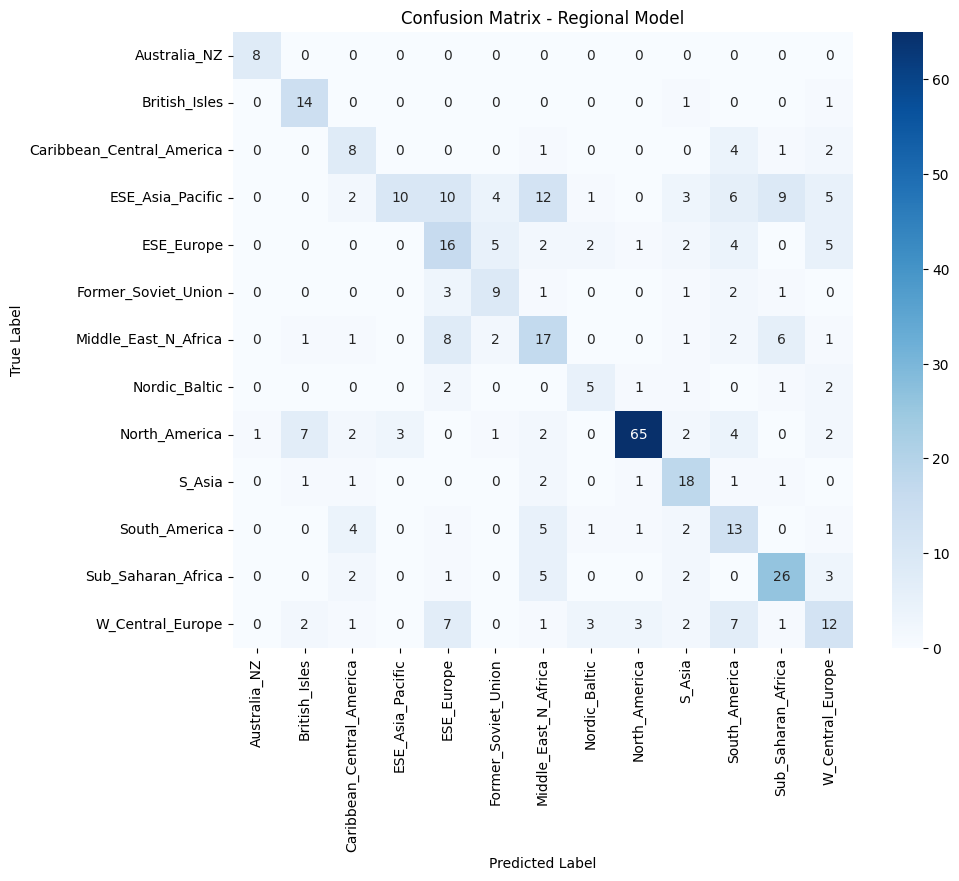

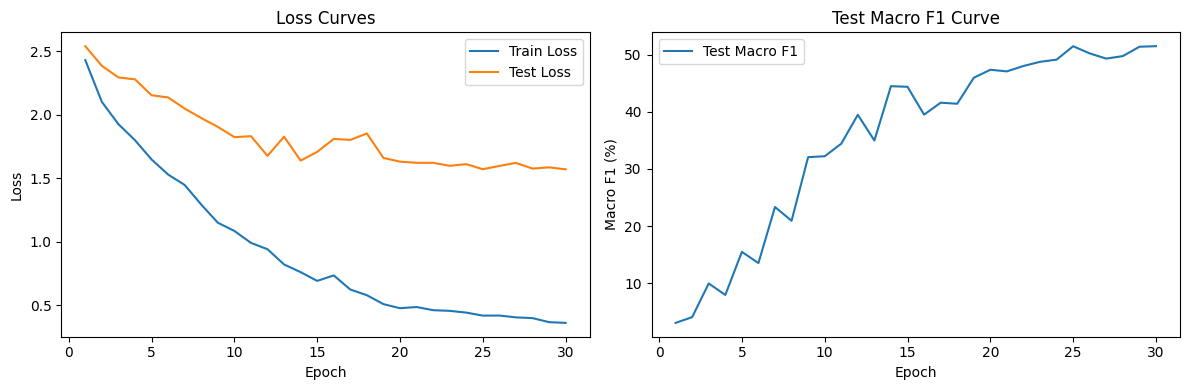

Script finished.


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchaudio
from torchaudio import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from google.colab import drive
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

# drive.mount('/content/drive', force_remount=True)
DRIVE_MULTICLASS_SAVE_DIR = '/content/drive/MyDrive/Colab_Models/SpeechAccent_Regional_v2_augmented/'
os.makedirs(DRIVE_MULTICLASS_SAVE_DIR, exist_ok=True)
print(f"Models/plots will be saved to: {DRIVE_MULTICLASS_SAVE_DIR}")

# Custom Dataset with Audio Augmentation
class RegionalSpeechAccentDataset(Dataset):
    def __init__(self, metadata_df, feature_extractor, region_label_column='speech_region_encoded',
                 target_sample_rate=16000, max_length_seconds=10, augment=False):
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.region_label_column = region_label_column
        self.target_sample_rate = target_sample_rate
        self.max_samples = target_sample_rate * max_length_seconds
        self.augment = augment
        if self.augment:
            self.augmenter = Compose([
                AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.3),
                TimeStretch(min_rate=0.9, max_rate=1.1, p=0.3, leave_length_unchanged=False),
                PitchShift(min_semitones=-2, max_semitones=2, p=0.3)
            ])

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        file_path = row['wav_path']
        label = row[self.region_label_column]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception:
            return {'input_values': torch.zeros(self.max_samples), 'label': torch.tensor(-1, dtype=torch.long)}

        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sample_rate != self.target_sample_rate:
            waveform = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)

        waveform_np = waveform.squeeze(0).numpy()

        if self.augment:
            waveform_np = self.augmenter(samples=waveform_np, sample_rate=self.target_sample_rate)

        current_length = waveform_np.shape[0]
        if current_length > self.max_samples: waveform_np = waveform_np[:self.max_samples]
        elif current_length < self.max_samples:
            waveform_np = np.pad(waveform_np, (0, self.max_samples - current_length), mode='constant')

        processed = self.feature_extractor(
            waveform_np, sampling_rate=self.target_sample_rate, return_tensors="pt",
            padding="max_length", max_length=self.max_samples, truncation=True
        )
        return {'input_values': processed.input_values.squeeze(0), 'label': torch.tensor(label, dtype=torch.long)}

# Classifier Model
class Wav2VecRegionalClassifier(nn.Module):
    def __init__(self, num_classes, model_name="facebook/wav2vec2-base", num_layers_to_unfreeze=4): # Unfreezing 4 layers
        super(Wav2VecRegionalClassifier, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(model_name)
        for param in self.wav2vec.parameters(): param.requires_grad = False
        if hasattr(self.wav2vec, 'feature_projector') and self.wav2vec.feature_projector is not None:
            for param in self.wav2vec.feature_projector.parameters(): param.requires_grad = True
            print("Unfroze Wav2Vec2 feature_projector.")
        if hasattr(self.wav2vec, 'encoder') and hasattr(self.wav2vec.encoder, 'layers') and num_layers_to_unfreeze > 0:
            num_total_layers = len(self.wav2vec.encoder.layers)
            start_layer_idx = num_total_layers - num_layers_to_unfreeze
            actual_unfrozen_count = 0
            for i in range(max(0, start_layer_idx), num_total_layers):
                for param in self.wav2vec.encoder.layers[i].parameters(): param.requires_grad = True
                actual_unfrozen_count +=1
            print(f"Unfroze the last {actual_unfrozen_count} Wav2Vec2 transformer layers.")
        self.classifier = nn.Sequential(
            nn.Linear(self.wav2vec.config.hidden_size, 256),
            nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, input_values):
        if input_values.ndim == 1: input_values = input_values.unsqueeze(0)
        outputs = self.wav2vec(input_values).last_hidden_state
        embeddings = torch.mean(outputs, dim=1)
        return self.classifier(embeddings)

# Setup DataLoaders, Model, Loss, Optimizer
if 'speech_region_encoded' not in metadata_full.columns or 'NUM_REGIONAL_CLASSES' not in globals():
    raise ValueError("Ensure 'metadata_full' has 'speech_region_encoded' and NUM_REGIONAL_CLASSES")

hf_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
train_df, test_df = train_test_split(
    metadata_full, test_size=0.20, random_state=42,
    stratify=metadata_full['speech_region_encoded'] if len(metadata_full['speech_region_encoded'].unique()) > 1 else None
)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")

# Apply augmentation only to the training dataset
train_dataset = RegionalSpeechAccentDataset(train_df, hf_feature_extractor, region_label_column='speech_region_encoded', augment=True)
test_dataset = RegionalSpeechAccentDataset(test_df, hf_feature_extractor, region_label_column='speech_region_encoded', augment=False)

sampler = None
class_weights_tensor = None
if not train_df.empty:
    train_class_counts = train_df['speech_region_encoded'].value_counts().sort_index()
    print(f"Training set regional distribution (encoded):\n{train_class_counts}")
    if len(train_class_counts) == NUM_REGIONAL_CLASSES and NUM_REGIONAL_CLASSES > 1:
        counts_for_sampler = np.zeros(NUM_REGIONAL_CLASSES)
        for i in range(NUM_REGIONAL_CLASSES): counts_for_sampler[i] = train_class_counts.get(i, 1e-6)
        weight_per_class_sampler = 1. / counts_for_sampler
        sample_weights_val = train_df['speech_region_encoded'].apply(lambda x: weight_per_class_sampler[x]).to_numpy()
        sample_weights = torch.from_numpy(sample_weights_val).double()
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler.")
        class_weights_list_mc = np.zeros(NUM_REGIONAL_CLASSES)
        for i in range(NUM_REGIONAL_CLASSES):
            count = train_class_counts.get(i, 0)
            class_weights_list_mc[i] = len(train_df) / count if count > 0 else 0
        total_weight_sum_mc = sum(class_weights_list_mc)
        if total_weight_sum_mc > 0: class_weights_list_mc = [w / total_weight_sum_mc * NUM_REGIONAL_CLASSES for w in class_weights_list_mc]
        class_weights_tensor = torch.tensor(class_weights_list_mc, dtype=torch.float32)
        print(f"Calculated multi-class weights for CrossEntropyLoss: {class_weights_tensor}")

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False if sampler else True, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = Wav2VecRegionalClassifier(num_classes=NUM_REGIONAL_CLASSES, num_layers_to_unfreeze=4).to(device) # Unfreezing 4 layers
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None)
print(f"Using {'weighted' if class_weights_tensor is not None else 'unweighted'} CrossEntropyLoss.")
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, weight_decay=0.02) # Lower LR, higher WD
print(f"Optimizer: AdamW with lr=2e-5 and weight_decay=0.02")
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3, verbose=True) # factor=0.2

NUM_EPOCHS = 30
best_val_metric = 0.0
epochs_no_improve = 0
PATIENCE_EARLY_STOP = 10
train_losses, test_losses, test_metric_scores = [], [], []
model_save_path = os.path.join(DRIVE_MULTICLASS_SAVE_DIR, 'best_regional_model_aug_ft4.pt')
target_names_regional = [region_mapping_for_model.get(i, f"Unknown_Class_{i}") for i in range(NUM_REGIONAL_CLASSES)]


print(f"\nStarting regional model training for up to {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    model.train()
    current_train_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for batch in train_iterator:
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_values)
        loss = criterion(outputs, labels)

        if not torch.isnan(loss):
            loss.backward()
            optimizer.step()
            current_train_loss += loss.item()

        train_iterator.set_postfix({'loss': loss.item() if not torch.isnan(loss) else float('nan'),
                                    'lr': optimizer.param_groups[0]['lr']})

    avg_train_loss = current_train_loss / len(train_loader) if len(train_loader) > 0 else 0
    train_losses.append(avg_train_loss)

    model.eval()
    current_test_loss = 0.0
    all_epoch_preds, all_epoch_labels = [], []
    test_iterator = tqdm(test_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Test]')
    with torch.no_grad():
        for batch in test_iterator:
            input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
            outputs = model(input_values)
            loss = criterion(outputs, labels)

            if not torch.isnan(loss):
                current_test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            all_epoch_preds.extend(predicted.cpu().numpy()) # predictions
            all_epoch_labels.extend(labels.cpu().numpy())   # labels

    avg_test_loss = current_test_loss / len(test_loader) if len(test_loader) > 0 else 0
    valid_epoch_preds = [p for i, p in enumerate(all_epoch_preds) if all_epoch_labels[i] != -1]
    valid_epoch_labels = [l for l in all_epoch_labels if l != -1]

    current_metric_val = 0
    if valid_epoch_labels and valid_epoch_preds:
        unique_labels_in_epoch = np.unique(np.concatenate((valid_epoch_labels, valid_epoch_preds)))
        filtered_target_names = [target_names_regional[i] for i in unique_labels_in_epoch if i >= 0 and i < len(target_names_regional)]
        unique_labels_for_report = [l for l in unique_labels_in_epoch if l >= 0 and l < len(target_names_regional)]


        if filtered_target_names and unique_labels_for_report:
            try:
                report_dict = classification_report(valid_epoch_labels, valid_epoch_preds, labels=unique_labels_for_report, target_names=filtered_target_names, zero_division=0, output_dict=True)
                current_metric_val = report_dict['macro avg']['f1-score'] * 100
            except ValueError as e:
                print(f"ValueError in classification_report for epoch {epoch+1}: {e}. Labels: {unique_labels_for_report}, Target Names: {filtered_target_names}")
                current_metric_val = 0

    test_losses.append(avg_test_loss)
    test_metric_scores.append(current_metric_val)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Macro F1: {current_metric_val:.2f}%, LR: {optimizer.param_groups[0]['lr']:.1e}")
    if valid_epoch_labels and valid_epoch_preds and filtered_target_names and unique_labels_for_report:
        try:
            print(classification_report(valid_epoch_labels, valid_epoch_preds, labels=unique_labels_for_report, target_names=filtered_target_names, zero_division=0))
        except ValueError as e:
            print(f"Could not print classification_report for epoch {epoch+1}: {e}")


    scheduler.step(current_metric_val)

    if current_metric_val > best_val_metric:
        best_val_metric = current_metric_val
        torch.save(model.state_dict(), model_save_path)
        print(f"  New best model saved to {model_save_path} (Macro F1: {best_val_metric:.2f}%)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  No improvement in val Macro F1 for {epochs_no_improve} epoch(s). Best: {best_val_metric:.2f}%")

    if epochs_no_improve >= PATIENCE_EARLY_STOP:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break
print("\nTraining finished.")

# Final Evaluation & Reporting
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f"\nLoaded best model from {model_save_path} for final evaluation.")
else:
    print(f"\nWarning: Saved model {model_save_path} not found.")
model.eval()
final_all_preds_raw, final_all_labels_raw = [], []
actual_epochs_run = len(train_losses)
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Final Evaluation'):
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        outputs = model(input_values)
        _, predicted = torch.max(outputs.data, 1)
        final_all_preds_raw.extend(predicted.cpu().numpy())
        final_all_labels_raw.extend(labels.cpu().numpy())

final_all_preds = [p for i, p in enumerate(final_all_preds_raw) if final_all_labels_raw[i] != -1]
final_all_labels = [l for l in final_all_labels_raw if l != -1]

if final_all_labels and final_all_preds:
    print("\nFinal Classification Report (Test Set - Regional Model):")
    unique_eval_labels_final = np.unique(np.concatenate((final_all_labels, final_all_preds)))
    final_target_names = [target_names_regional[i] for i in unique_eval_labels_final if i >=0 and i < len(target_names_regional)]
    unique_final_labels_for_report = [l for l in unique_eval_labels_final if l >= 0 and l < len(target_names_regional)]


    if final_target_names and unique_final_labels_for_report:
        print(classification_report(final_all_labels, final_all_preds, labels=unique_final_labels_for_report, target_names=final_target_names, zero_division=0))
        final_bal_acc_multi = balanced_accuracy_score(final_all_labels, final_all_preds) * 100
        try:
            final_macro_f1_multi = classification_report(final_all_labels, final_all_preds, labels=unique_final_labels_for_report, target_names=final_target_names, zero_division=0, output_dict=True)['macro avg']['f1-score'] * 100
        except KeyError:
            final_macro_f1_multi = 0.0
        print(f"Final Balanced Accuracy: {final_bal_acc_multi:.2f}%")
        print(f"Final Macro F1-Score: {final_macro_f1_multi:.2f}%")

        cm_labels = np.unique(np.concatenate((np.arange(NUM_REGIONAL_CLASSES),unique_final_labels_for_report)))
        cm_labels = sorted([l for l in cm_labels if l < NUM_REGIONAL_CLASSES])

        cm = confusion_matrix(final_all_labels, final_all_preds, labels=cm_labels)
        cm_target_names = [target_names_regional[i] for i in cm_labels]

        plt.figure(figsize=(max(10, NUM_REGIONAL_CLASSES // 1.2), max(8, NUM_REGIONAL_CLASSES // 1.5)))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=cm_target_names, yticklabels=cm_target_names)
        plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix - Regional Model')
        plt.savefig(os.path.join(DRIVE_MULTICLASS_SAVE_DIR, 'confusion_matrix_regional_aug_ft4.png'))
        plt.show()
else:
    print("No valid data/predictions for final report and confusion matrix after filtering.")

# Plot Training Curves
if actual_epochs_run > 0 :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1); plt.plot(range(1, actual_epochs_run + 1), train_losses, label='Train Loss'); plt.plot(range(1, actual_epochs_run + 1), test_losses, label='Test Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')
    plt.subplot(1, 2, 2); plt.plot(range(1, actual_epochs_run + 1), test_metric_scores, label='Test Macro F1'); plt.xlabel('Epoch'); plt.ylabel('Macro F1 (%)'); plt.legend(); plt.title('Test Macro F1 Curve')
    plt.tight_layout(); plt.savefig(os.path.join(DRIVE_MULTICLASS_SAVE_DIR, 'training_curves_regional_aug_ft4.png')); plt.show()
print("Script finished.")

### Region Mappings 3 (most successful)

Models/plots will be saved to: /content/drive/MyDrive/Colab_Models/SpeechAccent_Regional_v3_augmented/
Training set size: 1707, Test set size: 427
Training set regional distribution (encoded):
speech_region_encoded
0      33
1      65
2      65
3     147
4     157
5      68
6     154
7      49
8     357
9      90
10    102
11    113
12    154
13    153
Name: count, dtype: int64
Using WeightedRandomSampler.
Calculated multi-class weights for CrossEntropyLoss: tensor([2.6277, 1.3341, 1.3341, 0.5899, 0.5523, 1.2752, 0.5631, 1.7697, 0.2429,
        0.9635, 0.8502, 0.7674, 0.5631, 0.5668])
Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Unfroze the last 4 Wav2Vec2 transformer layers.
Using weighted CrossEntropyLoss.
Optimizer: AdamW with lr=2e-5 and weight_decay=0.02

Starting regional model training for up to 30 epochs...


Epoch 1/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 1/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1/30: Train Loss: 2.5382, Test Loss: 2.6474, Test Macro F1: 2.75%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.05      1.00      0.10         8
            British_Isles       0.00      0.00      0.00        16
Caribbean_Central_America       0.08      0.31      0.13        16
               ESE_Europe       0.00      0.00      0.00        37
                   E_Asia       0.00      0.00      0.00        40
      Former_Soviet_Union       0.11      0.12      0.11        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.02      0.33      0.04        12
            North_America       0.00      0.00      0.00        89
          SE_Asia_Pacific       0.00      0.00      0.00        23
                   S_Asia       0.00      0.00      0.00        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.00      0

Epoch 2/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 2/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2/30: Train Loss: 2.2524, Test Loss: 2.5094, Test Macro F1: 4.72%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.25      1.00      0.40         8
            British_Isles       0.00      0.00      0.00        16
Caribbean_Central_America       0.14      0.06      0.09        16
               ESE_Europe       0.00      0.00      0.00        37
                   E_Asia       0.00      0.00      0.00        40
      Former_Soviet_Union       0.05      0.65      0.09        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.04      0.58      0.08        12
            North_America       0.00      0.00      0.00        89
          SE_Asia_Pacific       0.00      0.00      0.00        23
                   S_Asia       0.00      0.00      0.00        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.00      0

Epoch 3/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 3/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3/30: Train Loss: 2.1187, Test Loss: 2.4209, Test Macro F1: 7.22%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.47      1.00      0.64         8
            British_Isles       0.10      0.44      0.17        16
Caribbean_Central_America       0.06      0.69      0.12        16
               ESE_Europe       0.00      0.00      0.00        37
                   E_Asia       0.00      0.00      0.00        40
      Former_Soviet_Union       0.00      0.00      0.00        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.05      0.67      0.09        12
            North_America       0.00      0.00      0.00        89
          SE_Asia_Pacific       0.00      0.00      0.00        23
                   S_Asia       0.00      0.00      0.00        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.00      0

Epoch 4/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 4/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4/30: Train Loss: 2.0047, Test Loss: 2.3868, Test Macro F1: 10.23%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.53      1.00      0.70         8
            British_Isles       0.24      0.69      0.35        16
Caribbean_Central_America       0.10      0.69      0.17        16
               ESE_Europe       0.00      0.00      0.00        37
                   E_Asia       0.00      0.00      0.00        40
      Former_Soviet_Union       0.11      0.18      0.13        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.04      0.75      0.08        12
            North_America       0.00      0.00      0.00        89
          SE_Asia_Pacific       0.00      0.00      0.00        23
                   S_Asia       0.00      0.00      0.00        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.00      

Epoch 5/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 5/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5/30: Train Loss: 1.9281, Test Loss: 2.3308, Test Macro F1: 14.28%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.73      1.00      0.84         8
            British_Isles       0.65      0.69      0.67        16
Caribbean_Central_America       0.12      0.56      0.19        16
               ESE_Europe       0.00      0.00      0.00        37
                   E_Asia       0.00      0.00      0.00        40
      Former_Soviet_Union       0.09      0.53      0.15        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.04      0.67      0.07        12
            North_America       0.00      0.00      0.00        89
          SE_Asia_Pacific       0.00      0.00      0.00        23
                   S_Asia       0.50      0.04      0.07        25
            South_America       0.00      0.00      0.00        28
       Sub_Saharan_Africa       0.00      

Epoch 6/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 6/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6/30: Train Loss: 1.8314, Test Loss: 2.2379, Test Macro F1: 13.90%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.62      1.00      0.76         8
            British_Isles       0.25      0.81      0.38        16
Caribbean_Central_America       0.10      0.62      0.17        16
               ESE_Europe       0.00      0.00      0.00        37
                   E_Asia       0.00      0.00      0.00        40
      Former_Soviet_Union       0.15      0.29      0.20        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.06      0.67      0.11        12
            North_America       0.00      0.00      0.00        89
          SE_Asia_Pacific       0.07      0.17      0.10        23
                   S_Asia       0.12      0.08      0.10        25
            South_America       0.10      0.07      0.08        28
       Sub_Saharan_Africa       1.00      

Epoch 7/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 7/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7/30: Train Loss: 1.6954, Test Loss: 2.1564, Test Macro F1: 17.93%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.28      0.69      0.40        16
Caribbean_Central_America       0.13      0.62      0.22        16
               ESE_Europe       0.00      0.00      0.00        37
                   E_Asia       0.00      0.00      0.00        40
      Former_Soviet_Union       0.09      0.35      0.14        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.06      0.92      0.12        12
            North_America       0.00      0.00      0.00        89
          SE_Asia_Pacific       0.00      0.00      0.00        23
                   S_Asia       0.38      0.24      0.29        25
            South_America       0.19      0.14      0.16        28
       Sub_Saharan_Africa       0.50      

Epoch 8/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 8/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8/30: Train Loss: 1.6097, Test Loss: 2.1265, Test Macro F1: 17.64%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.62      1.00      0.76         8
            British_Isles       0.26      0.69      0.38        16
Caribbean_Central_America       0.20      0.50      0.28        16
               ESE_Europe       0.00      0.00      0.00        37
                   E_Asia       0.00      0.00      0.00        40
      Former_Soviet_Union       0.18      0.47      0.26        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.07      0.75      0.12        12
            North_America       1.00      0.01      0.02        89
          SE_Asia_Pacific       0.10      0.26      0.14        23
                   S_Asia       0.14      0.40      0.21        25
            South_America       0.33      0.04      0.06        28
       Sub_Saharan_Africa       0.40      

Epoch 9/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 9/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9/30: Train Loss: 1.4477, Test Loss: 2.0494, Test Macro F1: 20.46%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.36      1.00      0.53         8
            British_Isles       0.28      0.81      0.42        16
Caribbean_Central_America       0.17      0.44      0.25        16
               ESE_Europe       0.43      0.08      0.14        37
                   E_Asia       0.00      0.00      0.00        40
      Former_Soviet_Union       0.36      0.24      0.29        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.08      0.67      0.14        12
            North_America       0.81      0.25      0.38        89
          SE_Asia_Pacific       0.10      0.35      0.15        23
                   S_Asia       0.19      0.52      0.27        25
            South_America       0.36      0.14      0.21        28
       Sub_Saharan_Africa       0.20      

Epoch 10/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 10/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10/30: Train Loss: 1.3355, Test Loss: 1.9725, Test Macro F1: 27.37%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.57      0.81      0.67        16
Caribbean_Central_America       0.16      0.50      0.25        16
               ESE_Europe       0.44      0.11      0.17        37
                   E_Asia       0.00      0.00      0.00        40
      Former_Soviet_Union       0.24      0.59      0.34        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.25      0.25      0.25        12
            North_America       0.92      0.39      0.55        89
          SE_Asia_Pacific       0.08      0.48      0.14        23
                   S_Asia       0.20      0.64      0.30        25
            South_America       0.12      0.07      0.09        28
       Sub_Saharan_Africa       0.14     

Epoch 11/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 11/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 11/30: Train Loss: 1.2591, Test Loss: 1.9046, Test Macro F1: 27.00%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.25      0.88      0.39        16
Caribbean_Central_America       0.14      0.50      0.22        16
               ESE_Europe       0.31      0.11      0.16        37
                   E_Asia       0.00      0.00      0.00        40
      Former_Soviet_Union       0.26      0.41      0.32        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.14      0.75      0.24        12
            North_America       0.96      0.28      0.43        89
          SE_Asia_Pacific       0.15      0.57      0.24        23
                   S_Asia       0.23      0.40      0.29        25
            South_America       0.46      0.21      0.29        28
       Sub_Saharan_Africa       0.23     

Epoch 12/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 12/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 12/30: Train Loss: 1.1533, Test Loss: 1.7829, Test Macro F1: 33.08%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.59      0.81      0.68        16
Caribbean_Central_America       0.30      0.44      0.36        16
               ESE_Europe       0.33      0.05      0.09        37
                   E_Asia       0.40      0.05      0.09        40
      Former_Soviet_Union       0.20      0.82      0.33        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.24      0.33      0.28        12
            North_America       0.89      0.63      0.74        89
          SE_Asia_Pacific       0.14      0.65      0.23        23
                   S_Asia       0.28      0.44      0.34        25
            South_America       0.20      0.25      0.22        28
       Sub_Saharan_Africa       0.32     

Epoch 13/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 13/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 13/30: Train Loss: 1.0188, Test Loss: 1.7960, Test Macro F1: 37.07%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.68      0.81      0.74        16
Caribbean_Central_America       0.27      0.25      0.26        16
               ESE_Europe       0.29      0.38      0.33        37
                   E_Asia       0.00      0.00      0.00        40
      Former_Soviet_Union       0.38      0.29      0.33        17
     Middle_East_N_Africa       1.00      0.03      0.05        39
            Nordic_Baltic       0.25      0.67      0.36        12
            North_America       0.91      0.70      0.79        89
          SE_Asia_Pacific       0.16      0.83      0.26        23
                   S_Asia       0.27      0.44      0.33        25
            South_America       0.36      0.29      0.32        28
       Sub_Saharan_Africa       0.33     

Epoch 14/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 14/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 14/30: Train Loss: 0.9401, Test Loss: 1.7863, Test Macro F1: 39.70%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       1.00      0.56      0.72        16
Caribbean_Central_America       0.50      0.25      0.33        16
               ESE_Europe       0.21      0.49      0.30        37
                   E_Asia       0.44      0.35      0.39        40
      Former_Soviet_Union       0.29      0.59      0.38        17
     Middle_East_N_Africa       0.25      0.03      0.05        39
            Nordic_Baltic       0.14      0.67      0.23        12
            North_America       0.87      0.53      0.66        89
          SE_Asia_Pacific       0.35      0.30      0.33        23
                   S_Asia       0.40      0.40      0.40        25
            South_America       0.21      0.25      0.23        28
       Sub_Saharan_Africa       0.36     

Epoch 15/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 15/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 15/30: Train Loss: 0.8832, Test Loss: 1.6996, Test Macro F1: 39.97%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.72      0.81      0.76        16
Caribbean_Central_America       0.15      0.56      0.23        16
               ESE_Europe       0.28      0.32      0.30        37
                   E_Asia       0.43      0.07      0.13        40
      Former_Soviet_Union       0.33      0.59      0.43        17
     Middle_East_N_Africa       0.00      0.00      0.00        39
            Nordic_Baltic       0.31      0.42      0.36        12
            North_America       0.93      0.60      0.73        89
          SE_Asia_Pacific       0.33      0.52      0.41        23
                   S_Asia       0.36      0.36      0.36        25
            South_America       0.19      0.39      0.26        28
       Sub_Saharan_Africa       0.38     

Epoch 16/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 16/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 16/30: Train Loss: 0.8750, Test Loss: 1.6800, Test Macro F1: 43.62%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.54      0.81      0.65        16
Caribbean_Central_America       0.55      0.38      0.44        16
               ESE_Europe       0.28      0.41      0.33        37
                   E_Asia       0.32      0.30      0.31        40
      Former_Soviet_Union       0.36      0.29      0.32        17
     Middle_East_N_Africa       0.40      0.15      0.22        39
            Nordic_Baltic       0.29      0.33      0.31        12
            North_America       0.85      0.83      0.84        89
          SE_Asia_Pacific       0.22      0.65      0.33        23
                   S_Asia       0.47      0.36      0.41        25
            South_America       0.28      0.39      0.33        28
       Sub_Saharan_Africa       0.53     

Epoch 17/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 17/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 17/30: Train Loss: 0.7317, Test Loss: 1.7335, Test Macro F1: 43.45%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.48      0.81      0.60        16
Caribbean_Central_America       0.26      0.38      0.31        16
               ESE_Europe       0.48      0.32      0.39        37
                   E_Asia       0.44      0.28      0.34        40
      Former_Soviet_Union       0.50      0.12      0.19        17
     Middle_East_N_Africa       0.83      0.13      0.22        39
            Nordic_Baltic       0.33      0.42      0.37        12
            North_America       0.82      0.76      0.79        89
          SE_Asia_Pacific       0.22      0.83      0.35        23
                   S_Asia       0.40      0.40      0.40        25
            South_America       0.39      0.43      0.41        28
       Sub_Saharan_Africa       0.44     

Epoch 18/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 18/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 18/30: Train Loss: 0.6675, Test Loss: 1.6701, Test Macro F1: 49.26%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.67      0.75      0.71        16
Caribbean_Central_America       0.55      0.38      0.44        16
               ESE_Europe       0.63      0.32      0.43        37
                   E_Asia       0.47      0.35      0.40        40
      Former_Soviet_Union       0.62      0.29      0.40        17
     Middle_East_N_Africa       0.38      0.28      0.32        39
            Nordic_Baltic       0.33      0.33      0.33        12
            North_America       0.82      0.79      0.80        89
          SE_Asia_Pacific       0.24      0.78      0.37        23
                   S_Asia       0.45      0.56      0.50        25
            South_America       0.40      0.36      0.38        28
       Sub_Saharan_Africa       0.49     

Epoch 19/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 19/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 19/30: Train Loss: 0.6044, Test Loss: 1.5942, Test Macro F1: 51.19%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.92      0.75      0.83        16
Caribbean_Central_America       0.46      0.38      0.41        16
               ESE_Europe       0.36      0.43      0.39        37
                   E_Asia       0.50      0.55      0.52        40
      Former_Soviet_Union       0.54      0.41      0.47        17
     Middle_East_N_Africa       0.43      0.38      0.41        39
            Nordic_Baltic       0.31      0.33      0.32        12
            North_America       0.88      0.74      0.80        89
          SE_Asia_Pacific       0.29      0.52      0.37        23
                   S_Asia       0.55      0.48      0.51        25
            South_America       0.38      0.54      0.44        28
       Sub_Saharan_Africa       0.47     

Epoch 20/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 20/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 20/30: Train Loss: 0.5804, Test Loss: 1.8311, Test Macro F1: 42.55%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.85      0.69      0.76        16
Caribbean_Central_America       0.27      0.50      0.35        16
               ESE_Europe       0.55      0.30      0.39        37
                   E_Asia       0.67      0.05      0.09        40
      Former_Soviet_Union       1.00      0.06      0.11        17
     Middle_East_N_Africa       0.35      0.18      0.24        39
            Nordic_Baltic       0.33      0.42      0.37        12
            North_America       0.88      0.80      0.84        89
          SE_Asia_Pacific       0.26      0.70      0.38        23
                   S_Asia       0.34      0.56      0.42        25
            South_America       0.23      0.54      0.32        28
       Sub_Saharan_Africa       0.45     

Epoch 21/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 21/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 21/30: Train Loss: 0.4990, Test Loss: 1.6376, Test Macro F1: 53.16%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.67      0.75      0.71        16
Caribbean_Central_America       0.55      0.38      0.44        16
               ESE_Europe       0.51      0.49      0.50        37
                   E_Asia       0.57      0.53      0.55        40
      Former_Soviet_Union       0.50      0.41      0.45        17
     Middle_East_N_Africa       0.46      0.41      0.43        39
            Nordic_Baltic       0.31      0.33      0.32        12
            North_America       0.84      0.85      0.84        89
          SE_Asia_Pacific       0.35      0.48      0.41        23
                   S_Asia       0.69      0.36      0.47        25
            South_America       0.29      0.68      0.41        28
       Sub_Saharan_Africa       0.66     

Epoch 22/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 22/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 22/30: Train Loss: 0.5167, Test Loss: 2.0668, Test Macro F1: 42.64%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.55      0.75      0.63        16
Caribbean_Central_America       0.32      0.38      0.34        16
               ESE_Europe       0.64      0.38      0.47        37
                   E_Asia       0.40      0.40      0.40        40
      Former_Soviet_Union       1.00      0.06      0.11        17
     Middle_East_N_Africa       0.38      0.08      0.13        39
            Nordic_Baltic       0.40      0.33      0.36        12
            North_America       0.86      0.71      0.78        89
          SE_Asia_Pacific       0.19      0.78      0.31        23
                   S_Asia       0.70      0.28      0.40        25
            South_America       0.28      0.64      0.39        28
       Sub_Saharan_Africa       0.69     

Epoch 23/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 23/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 23/30: Train Loss: 0.4434, Test Loss: 1.6764, Test Macro F1: 51.85%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.75      0.75      0.75        16
Caribbean_Central_America       0.67      0.38      0.48        16
               ESE_Europe       0.49      0.51      0.50        37
                   E_Asia       0.42      0.70      0.52        40
      Former_Soviet_Union       0.45      0.29      0.36        17
     Middle_East_N_Africa       0.57      0.44      0.49        39
            Nordic_Baltic       0.27      0.33      0.30        12
            North_America       0.90      0.67      0.77        89
          SE_Asia_Pacific       0.46      0.57      0.51        23
                   S_Asia       0.39      0.72      0.51        25
            South_America       0.31      0.61      0.41        28
       Sub_Saharan_Africa       0.79     

Epoch 24/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 24/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 24/30: Train Loss: 0.4381, Test Loss: 1.7637, Test Macro F1: 51.12%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       0.89      1.00      0.94         8
            British_Isles       0.86      0.75      0.80        16
Caribbean_Central_America       0.21      0.38      0.27        16
               ESE_Europe       0.58      0.49      0.53        37
                   E_Asia       0.47      0.45      0.46        40
      Former_Soviet_Union       0.50      0.47      0.48        17
     Middle_East_N_Africa       0.50      0.36      0.42        39
            Nordic_Baltic       1.00      0.17      0.29        12
            North_America       0.87      0.70      0.78        89
          SE_Asia_Pacific       0.30      0.70      0.42        23
                   S_Asia       0.36      0.60      0.45        25
            South_America       0.41      0.50      0.45        28
       Sub_Saharan_Africa       0.58     

Epoch 25/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 25/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 25/30: Train Loss: 0.4471, Test Loss: 1.7578, Test Macro F1: 51.54%, LR: 2.0e-05
                           precision    recall  f1-score   support

             Australia_NZ       1.00      1.00      1.00         8
            British_Isles       0.76      0.81      0.79        16
Caribbean_Central_America       0.32      0.38      0.34        16
               ESE_Europe       0.39      0.46      0.42        37
                   E_Asia       0.39      0.75      0.51        40
      Former_Soviet_Union       0.44      0.41      0.42        17
     Middle_East_N_Africa       0.59      0.33      0.43        39
            Nordic_Baltic       0.40      0.33      0.36        12
            North_America       0.84      0.85      0.85        89
          SE_Asia_Pacific       0.37      0.57      0.45        23
                   S_Asia       0.57      0.48      0.52        25
            South_America       0.33      0.39      0.36        28
       Sub_Saharan_Africa       0.80     

Epoch 26/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 26/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 26/30: Train Loss: 0.3606, Test Loss: 1.6346, Test Macro F1: 55.89%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       1.00      1.00      1.00         8
            British_Isles       0.92      0.75      0.83        16
Caribbean_Central_America       0.50      0.38      0.43        16
               ESE_Europe       0.54      0.51      0.53        37
                   E_Asia       0.59      0.60      0.59        40
      Former_Soviet_Union       0.50      0.24      0.32        17
     Middle_East_N_Africa       0.45      0.46      0.46        39
            Nordic_Baltic       0.60      0.25      0.35        12
            North_America       0.87      0.81      0.84        89
          SE_Asia_Pacific       0.45      0.65      0.54        23
                   S_Asia       0.55      0.48      0.51        25
            South_America       0.37      0.71      0.49        28
       Sub_Saharan_Africa       0.56     

Epoch 27/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 27/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 27/30: Train Loss: 0.2833, Test Loss: 1.6479, Test Macro F1: 56.58%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       1.00      1.00      1.00         8
            British_Isles       0.93      0.81      0.87        16
Caribbean_Central_America       0.40      0.38      0.39        16
               ESE_Europe       0.51      0.54      0.53        37
                   E_Asia       0.61      0.62      0.62        40
      Former_Soviet_Union       0.33      0.12      0.17        17
     Middle_East_N_Africa       0.55      0.44      0.49        39
            Nordic_Baltic       0.57      0.33      0.42        12
            North_America       0.84      0.85      0.85        89
          SE_Asia_Pacific       0.44      0.65      0.53        23
                   S_Asia       0.50      0.64      0.56        25
            South_America       0.42      0.68      0.52        28
       Sub_Saharan_Africa       0.61     

Epoch 28/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 28/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 28/30: Train Loss: 0.2891, Test Loss: 1.6696, Test Macro F1: 55.72%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       1.00      1.00      1.00         8
            British_Isles       1.00      0.69      0.81        16
Caribbean_Central_America       0.75      0.38      0.50        16
               ESE_Europe       0.43      0.54      0.48        37
                   E_Asia       0.57      0.65      0.60        40
      Former_Soviet_Union       0.38      0.18      0.24        17
     Middle_East_N_Africa       0.50      0.49      0.49        39
            Nordic_Baltic       0.57      0.33      0.42        12
            North_America       0.88      0.74      0.80        89
          SE_Asia_Pacific       0.42      0.65      0.51        23
                   S_Asia       0.60      0.48      0.53        25
            South_America       0.35      0.61      0.44        28
       Sub_Saharan_Africa       0.63     

Epoch 29/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 29/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 29/30: Train Loss: 0.2567, Test Loss: 1.6655, Test Macro F1: 55.16%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       1.00      1.00      1.00         8
            British_Isles       0.92      0.75      0.83        16
Caribbean_Central_America       0.67      0.38      0.48        16
               ESE_Europe       0.43      0.57      0.49        37
                   E_Asia       0.57      0.57      0.57        40
      Former_Soviet_Union       0.40      0.12      0.18        17
     Middle_East_N_Africa       0.45      0.44      0.44        39
            Nordic_Baltic       0.50      0.33      0.40        12
            North_America       0.86      0.83      0.85        89
          SE_Asia_Pacific       0.44      0.70      0.54        23
                   S_Asia       0.52      0.48      0.50        25
            South_America       0.38      0.64      0.48        28
       Sub_Saharan_Africa       0.62     

Epoch 30/30 [Train]:   0%|          | 0/214 [00:00<?, ?it/s]

Epoch 30/30 [Test]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 30/30: Train Loss: 0.2473, Test Loss: 1.6514, Test Macro F1: 56.74%, LR: 4.0e-06
                           precision    recall  f1-score   support

             Australia_NZ       1.00      1.00      1.00         8
            British_Isles       0.93      0.81      0.87        16
Caribbean_Central_America       0.67      0.38      0.48        16
               ESE_Europe       0.49      0.51      0.50        37
                   E_Asia       0.57      0.68      0.62        40
      Former_Soviet_Union       0.40      0.24      0.30        17
     Middle_East_N_Africa       0.53      0.41      0.46        39
            Nordic_Baltic       0.57      0.33      0.42        12
            North_America       0.87      0.85      0.86        89
          SE_Asia_Pacific       0.42      0.70      0.52        23
                   S_Asia       0.54      0.52      0.53        25
            South_America       0.37      0.61      0.46        28
       Sub_Saharan_Africa       0.59     

Final Evaluation:   0%|          | 0/54 [00:00<?, ?it/s]


Final Classification Report (Test Set - Regional Model):
                           precision    recall  f1-score   support

             Australia_NZ       1.00      1.00      1.00         8
            British_Isles       0.93      0.81      0.87        16
Caribbean_Central_America       0.67      0.38      0.48        16
               ESE_Europe       0.49      0.51      0.50        37
                   E_Asia       0.57      0.68      0.62        40
      Former_Soviet_Union       0.40      0.24      0.30        17
     Middle_East_N_Africa       0.53      0.41      0.46        39
            Nordic_Baltic       0.57      0.33      0.42        12
            North_America       0.87      0.85      0.86        89
          SE_Asia_Pacific       0.42      0.70      0.52        23
                   S_Asia       0.54      0.52      0.53        25
            South_America       0.37      0.61      0.46        28
       Sub_Saharan_Africa       0.59      0.50      0.54        38
   

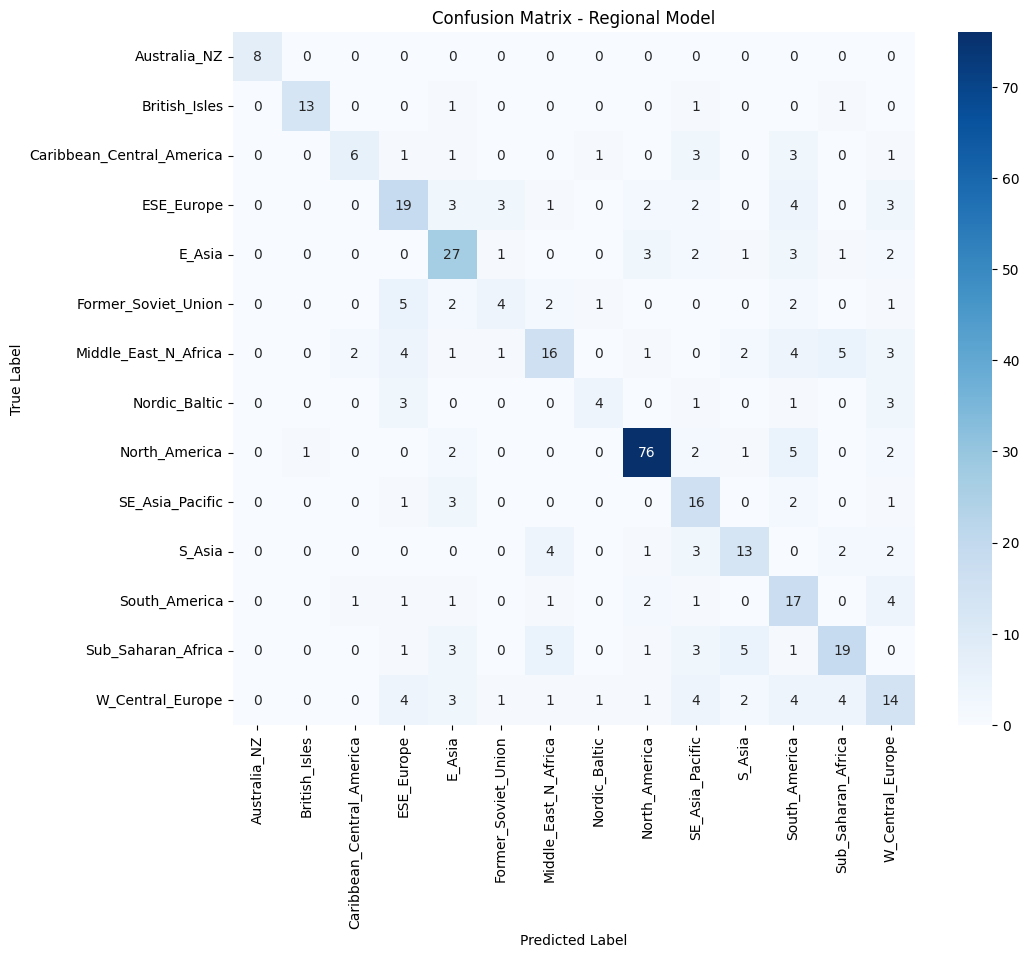

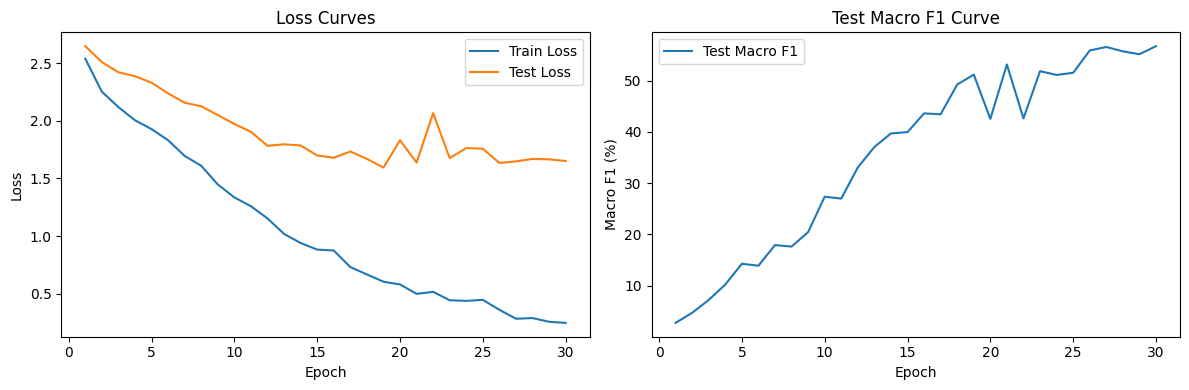

Script finished.


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchaudio
from torchaudio import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from google.colab import drive
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

# drive.mount('/content/drive', force_remount=True)
DRIVE_MULTICLASS_SAVE_DIR = '/content/drive/MyDrive/Colab_Models/SpeechAccent_Regional_v3_augmented/'
os.makedirs(DRIVE_MULTICLASS_SAVE_DIR, exist_ok=True)
print(f"Models/plots will be saved to: {DRIVE_MULTICLASS_SAVE_DIR}")

# Custom Dataset with Audio Augmentation
class RegionalSpeechAccentDataset(Dataset):
    def __init__(self, metadata_df, feature_extractor, region_label_column='speech_region_encoded',
                 target_sample_rate=16000, max_length_seconds=10, augment=False):
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.region_label_column = region_label_column
        self.target_sample_rate = target_sample_rate
        self.max_samples = target_sample_rate * max_length_seconds
        self.augment = augment
        if self.augment:
            self.augmenter = Compose([
                AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.3),
                TimeStretch(min_rate=0.9, max_rate=1.1, p=0.3, leave_length_unchanged=False),
                PitchShift(min_semitones=-2, max_semitones=2, p=0.3)
            ])

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        file_path = row['wav_path']
        label = row[self.region_label_column]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception:
            return {'input_values': torch.zeros(self.max_samples), 'label': torch.tensor(-1, dtype=torch.long)}

        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sample_rate != self.target_sample_rate:
            waveform = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)

        waveform_np = waveform.squeeze(0).numpy()

        if self.augment:
            waveform_np = self.augmenter(samples=waveform_np, sample_rate=self.target_sample_rate)

        current_length = waveform_np.shape[0]
        if current_length > self.max_samples: waveform_np = waveform_np[:self.max_samples]
        elif current_length < self.max_samples:
            waveform_np = np.pad(waveform_np, (0, self.max_samples - current_length), mode='constant')

        processed = self.feature_extractor(
            waveform_np, sampling_rate=self.target_sample_rate, return_tensors="pt",
            padding="max_length", max_length=self.max_samples, truncation=True
        )
        return {'input_values': processed.input_values.squeeze(0), 'label': torch.tensor(label, dtype=torch.long)}

# Classifier Model
class Wav2VecRegionalClassifier(nn.Module):
    def __init__(self, num_classes, model_name="facebook/wav2vec2-base", num_layers_to_unfreeze=4):
        super(Wav2VecRegionalClassifier, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(model_name)
        for param in self.wav2vec.parameters(): param.requires_grad = False
        if hasattr(self.wav2vec, 'feature_projector') and self.wav2vec.feature_projector is not None:
            for param in self.wav2vec.feature_projector.parameters(): param.requires_grad = True
            print("Unfroze Wav2Vec2 feature_projector.")
        if hasattr(self.wav2vec, 'encoder') and hasattr(self.wav2vec.encoder, 'layers') and num_layers_to_unfreeze > 0:
            num_total_layers = len(self.wav2vec.encoder.layers)
            start_layer_idx = num_total_layers - num_layers_to_unfreeze
            actual_unfrozen_count = 0
            for i in range(max(0, start_layer_idx), num_total_layers):
                for param in self.wav2vec.encoder.layers[i].parameters(): param.requires_grad = True
                actual_unfrozen_count +=1
            print(f"Unfroze the last {actual_unfrozen_count} Wav2Vec2 transformer layers.")
        self.classifier = nn.Sequential(
            nn.Linear(self.wav2vec.config.hidden_size, 256),
            nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, input_values):
        if input_values.ndim == 1: input_values = input_values.unsqueeze(0)
        outputs = self.wav2vec(input_values).last_hidden_state
        embeddings = torch.mean(outputs, dim=1)
        return self.classifier(embeddings)

# Setup DataLoaders, Model, Loss, Optimizer
if 'speech_region_encoded' not in metadata_full.columns or 'NUM_REGIONAL_CLASSES' not in globals():
    raise ValueError("Ensure 'metadata_full' has 'speech_region_encoded' and NUM_REGIONAL_CLASSES")

hf_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
train_df, test_df = train_test_split(
    metadata_full, test_size=0.20, random_state=42,
    stratify=metadata_full['speech_region_encoded'] if len(metadata_full['speech_region_encoded'].unique()) > 1 else None
)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")

# Apply augmentation only to the training dataset
train_dataset = RegionalSpeechAccentDataset(train_df, hf_feature_extractor, region_label_column='speech_region_encoded', augment=True)
test_dataset = RegionalSpeechAccentDataset(test_df, hf_feature_extractor, region_label_column='speech_region_encoded', augment=False)

sampler = None
class_weights_tensor = None
if not train_df.empty:
    train_class_counts = train_df['speech_region_encoded'].value_counts().sort_index()
    print(f"Training set regional distribution (encoded):\n{train_class_counts}")
    if len(train_class_counts) == NUM_REGIONAL_CLASSES and NUM_REGIONAL_CLASSES > 1:
        counts_for_sampler = np.zeros(NUM_REGIONAL_CLASSES)
        for i in range(NUM_REGIONAL_CLASSES): counts_for_sampler[i] = train_class_counts.get(i, 1e-6)
        weight_per_class_sampler = 1. / counts_for_sampler
        sample_weights_val = train_df['speech_region_encoded'].apply(lambda x: weight_per_class_sampler[x]).to_numpy()
        sample_weights = torch.from_numpy(sample_weights_val).double()
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler.")
        class_weights_list_mc = np.zeros(NUM_REGIONAL_CLASSES)
        for i in range(NUM_REGIONAL_CLASSES):
            count = train_class_counts.get(i, 0)
            class_weights_list_mc[i] = len(train_df) / count if count > 0 else 0
        total_weight_sum_mc = sum(class_weights_list_mc)
        if total_weight_sum_mc > 0: class_weights_list_mc = [w / total_weight_sum_mc * NUM_REGIONAL_CLASSES for w in class_weights_list_mc]
        class_weights_tensor = torch.tensor(class_weights_list_mc, dtype=torch.float32)
        print(f"Calculated multi-class weights for CrossEntropyLoss: {class_weights_tensor}")

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False if sampler else True, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = Wav2VecRegionalClassifier(num_classes=NUM_REGIONAL_CLASSES, num_layers_to_unfreeze=4).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None)
print(f"Using {'weighted' if class_weights_tensor is not None else 'unweighted'} CrossEntropyLoss.")
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, weight_decay=0.02)
print(f"Optimizer: AdamW with lr=2e-5 and weight_decay=0.02")
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3, verbose=True)

NUM_EPOCHS = 30
best_val_metric = 0.0
epochs_no_improve = 0
PATIENCE_EARLY_STOP = 10
train_losses, test_losses, test_metric_scores = [], [], []
model_save_path = os.path.join(DRIVE_MULTICLASS_SAVE_DIR, 'best_regional_model_aug_ft4.pt')
target_names_regional = [region_mapping_for_model.get(i, f"Unknown_Class_{i}") for i in range(NUM_REGIONAL_CLASSES)]


print(f"\nStarting regional model training for up to {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    model.train()
    current_train_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for batch in train_iterator:
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_values)
        loss = criterion(outputs, labels)

        if not torch.isnan(loss):
            loss.backward()
            optimizer.step()
            current_train_loss += loss.item()

        train_iterator.set_postfix({'loss': loss.item() if not torch.isnan(loss) else float('nan'),
                                    'lr': optimizer.param_groups[0]['lr']})

    avg_train_loss = current_train_loss / len(train_loader) if len(train_loader) > 0 else 0
    train_losses.append(avg_train_loss)

    model.eval()
    current_test_loss = 0.0
    all_epoch_preds, all_epoch_labels = [], []
    test_iterator = tqdm(test_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Test]')
    with torch.no_grad():
        for batch in test_iterator:
            input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
            outputs = model(input_values)
            loss = criterion(outputs, labels)

            if not torch.isnan(loss):
                current_test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            all_epoch_preds.extend(predicted.cpu().numpy()) # predictions
            all_epoch_labels.extend(labels.cpu().numpy())   # labels

    avg_test_loss = current_test_loss / len(test_loader) if len(test_loader) > 0 else 0
    valid_epoch_preds = [p for i, p in enumerate(all_epoch_preds) if all_epoch_labels[i] != -1]
    valid_epoch_labels = [l for l in all_epoch_labels if l != -1]

    current_metric_val = 0
    if valid_epoch_labels and valid_epoch_preds:
        unique_labels_in_epoch = np.unique(np.concatenate((valid_epoch_labels, valid_epoch_preds)))
        filtered_target_names = [target_names_regional[i] for i in unique_labels_in_epoch if i >= 0 and i < len(target_names_regional)]
        unique_labels_for_report = [l for l in unique_labels_in_epoch if l >= 0 and l < len(target_names_regional)]


        if filtered_target_names and unique_labels_for_report:
            try:
                report_dict = classification_report(valid_epoch_labels, valid_epoch_preds, labels=unique_labels_for_report, target_names=filtered_target_names, zero_division=0, output_dict=True)
                current_metric_val = report_dict['macro avg']['f1-score'] * 100
            except ValueError as e:
                print(f"ValueError in classification_report for epoch {epoch+1}: {e}. Labels: {unique_labels_for_report}, Target Names: {filtered_target_names}")
                current_metric_val = 0

    test_losses.append(avg_test_loss)
    test_metric_scores.append(current_metric_val)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Macro F1: {current_metric_val:.2f}%, LR: {optimizer.param_groups[0]['lr']:.1e}")
    if valid_epoch_labels and valid_epoch_preds and filtered_target_names and unique_labels_for_report:
        try:
            print(classification_report(valid_epoch_labels, valid_epoch_preds, labels=unique_labels_for_report, target_names=filtered_target_names, zero_division=0))
        except ValueError as e:
            print(f"Could not print classification_report for epoch {epoch+1}: {e}")


    scheduler.step(current_metric_val)

    if current_metric_val > best_val_metric:
        best_val_metric = current_metric_val
        torch.save(model.state_dict(), model_save_path)
        print(f"  New best model saved to {model_save_path} (Macro F1: {best_val_metric:.2f}%)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  No improvement in val Macro F1 for {epochs_no_improve} epoch(s). Best: {best_val_metric:.2f}%")

    if epochs_no_improve >= PATIENCE_EARLY_STOP:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break
print("\nTraining finished.")

# Final Evaluation & Reporting
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f"\nLoaded best model from {model_save_path} for final evaluation.")
else:
    print(f"\nWarning: Saved model {model_save_path} not found.")
model.eval()
final_all_preds_raw, final_all_labels_raw = [], []
actual_epochs_run = len(train_losses)
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Final Evaluation'):
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        outputs = model(input_values)
        _, predicted = torch.max(outputs.data, 1)
        final_all_preds_raw.extend(predicted.cpu().numpy())
        final_all_labels_raw.extend(labels.cpu().numpy())

final_all_preds = [p for i, p in enumerate(final_all_preds_raw) if final_all_labels_raw[i] != -1]
final_all_labels = [l for l in final_all_labels_raw if l != -1]

if final_all_labels and final_all_preds:
    print("\nFinal Classification Report (Test Set - Regional Model):")
    unique_eval_labels_final = np.unique(np.concatenate((final_all_labels, final_all_preds)))
    final_target_names = [target_names_regional[i] for i in unique_eval_labels_final if i >=0 and i < len(target_names_regional)]
    unique_final_labels_for_report = [l for l in unique_eval_labels_final if l >= 0 and l < len(target_names_regional)]


    if final_target_names and unique_final_labels_for_report:
        print(classification_report(final_all_labels, final_all_preds, labels=unique_final_labels_for_report, target_names=final_target_names, zero_division=0))
        final_bal_acc_multi = balanced_accuracy_score(final_all_labels, final_all_preds) * 100
        try:
            final_macro_f1_multi = classification_report(final_all_labels, final_all_preds, labels=unique_final_labels_for_report, target_names=final_target_names, zero_division=0, output_dict=True)['macro avg']['f1-score'] * 100
        except KeyError:
            final_macro_f1_multi = 0.0
        print(f"Final Balanced Accuracy: {final_bal_acc_multi:.2f}%")
        print(f"Final Macro F1-Score: {final_macro_f1_multi:.2f}%")

        cm_labels = np.unique(np.concatenate((np.arange(NUM_REGIONAL_CLASSES),unique_final_labels_for_report)))
        cm_labels = sorted([l for l in cm_labels if l < NUM_REGIONAL_CLASSES])

        cm = confusion_matrix(final_all_labels, final_all_preds, labels=cm_labels)
        cm_target_names = [target_names_regional[i] for i in cm_labels]

        plt.figure(figsize=(max(10, NUM_REGIONAL_CLASSES // 1.2), max(8, NUM_REGIONAL_CLASSES // 1.5)))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=cm_target_names, yticklabels=cm_target_names)
        plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix - Regional Model')
        plt.savefig(os.path.join(DRIVE_MULTICLASS_SAVE_DIR, 'confusion_matrix_regional_aug_ft4.png'))
        plt.show()
else:
    print("No valid data/predictions for final report and confusion matrix after filtering.")

# Plot Training Curves
if actual_epochs_run > 0 :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1); plt.plot(range(1, actual_epochs_run + 1), train_losses, label='Train Loss'); plt.plot(range(1, actual_epochs_run + 1), test_losses, label='Test Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')
    plt.subplot(1, 2, 2); plt.plot(range(1, actual_epochs_run + 1), test_metric_scores, label='Test Macro F1'); plt.xlabel('Epoch'); plt.ylabel('Macro F1 (%)'); plt.legend(); plt.title('Test Macro F1 Curve')
    plt.tight_layout(); plt.savefig(os.path.join(DRIVE_MULTICLASS_SAVE_DIR, 'training_curves_regional_aug_ft4.png')); plt.show()
print("Script finished.")

#### FUTURE WORK: Region Mapping 3, Model 2

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchaudio
from torchaudio import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from google.colab import drive
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

# drive.mount('/content/drive', force_remount=True)
DRIVE_SAVE_SUBFOLDER = 'SpeechAccent_Regional_15s_Run'
DRIVE_MULTICLASS_SAVE_DIR = os.path.join('/content/drive/MyDrive/Colab_Models/', DRIVE_SAVE_SUBFOLDER)
os.makedirs(DRIVE_MULTICLASS_SAVE_DIR, exist_ok=True)
print(f"Models/plots will be saved to: {DRIVE_MULTICLASS_SAVE_DIR}")

# =Dataset with Audio Augmentation
class RegionalSpeechAccentDataset(Dataset):
    def __init__(self, metadata_df, feature_extractor, region_label_column='speech_region_encoded',
                 target_sample_rate=16000, max_length_seconds=15, augment=False):
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.region_label_column = region_label_column
        self.target_sample_rate = target_sample_rate
        self.max_samples = target_sample_rate * max_length_seconds
        self.augment = augment
        if self.augment:
            self.augmenter = Compose([
                AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.3),
                TimeStretch(min_rate=0.9, max_rate=1.1, p=0.3, leave_length_unchanged=False),
                PitchShift(min_semitones=-2, max_semitones=2, p=0.3)
            ])

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        file_path = row['wav_path']
        label = row[self.region_label_column]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception:
            return {'input_values': torch.zeros(self.max_samples), 'label': torch.tensor(-1, dtype=torch.long)}
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sample_rate != self.target_sample_rate:
            waveform = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)
        waveform_np = waveform.squeeze(0).numpy()
        if self.augment:
            waveform_np = self.augmenter(samples=waveform_np, sample_rate=self.target_sample_rate)
        current_length = waveform_np.shape[0]
        if current_length > self.max_samples: waveform_np = waveform_np[:self.max_samples]
        elif current_length < self.max_samples:
            waveform_np = np.pad(waveform_np, (0, self.max_samples - current_length), mode='constant')
        processed = self.feature_extractor(
            waveform_np, sampling_rate=self.target_sample_rate, return_tensors="pt",
            padding="max_length", max_length=self.max_samples, truncation=True
        )
        return {'input_values': processed.input_values.squeeze(0), 'label': torch.tensor(label, dtype=torch.long)}

# Classifier Model - 4 layers unfrozen
class Wav2VecRegionalClassifier(nn.Module):
    def __init__(self, num_classes, model_name="facebook/wav2vec2-base", num_layers_to_unfreeze=4):
        super(Wav2VecRegionalClassifier, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(model_name)
        for param in self.wav2vec.parameters(): param.requires_grad = False
        if hasattr(self.wav2vec, 'feature_projector') and self.wav2vec.feature_projector is not None:
            for param in self.wav2vec.feature_projector.parameters(): param.requires_grad = True
            print("Unfroze Wav2Vec2 feature_projector.")
        if hasattr(self.wav2vec, 'encoder') and hasattr(self.wav2vec.encoder, 'layers') and num_layers_to_unfreeze > 0:
            num_total_layers = len(self.wav2vec.encoder.layers)
            start_layer_idx = num_total_layers - num_layers_to_unfreeze
            actual_unfrozen_count = 0
            for i in range(max(0, start_layer_idx), num_total_layers):
                for param in self.wav2vec.encoder.layers[i].parameters(): param.requires_grad = True
                actual_unfrozen_count +=1
            print(f"Unfroze the last {actual_unfrozen_count} Wav2Vec2 transformer layers.")
        self.classifier = nn.Sequential(
            nn.Linear(self.wav2vec.config.hidden_size, 256),
            nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, input_values):
        if input_values.ndim == 1: input_values = input_values.unsqueeze(0)
        outputs = self.wav2vec(input_values).last_hidden_state
        embeddings = torch.mean(outputs, dim=1)
        return self.classifier(embeddings)

# DataLoaders, Model, Loss, Optimizer
if 'speech_region_encoded' not in metadata_full.columns or 'NUM_REGIONAL_CLASSES' not in globals() or 'label_encoder' not in globals():
    raise ValueError("Ensure 'metadata_full' (with 'speech_region_encoded'), 'NUM_REGIONAL_CLASSES', and 'label_encoder' are globally defined from data prep.")

hf_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
train_df, test_df = train_test_split(
    metadata_full, test_size=0.20, random_state=42,
    stratify=metadata_full['speech_region_encoded'] if len(metadata_full['speech_region_encoded'].unique()) > 1 else None
)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")

train_dataset = RegionalSpeechAccentDataset(train_df, hf_feature_extractor, region_label_column='speech_region_encoded', augment=True, max_length_seconds=15)
test_dataset = RegionalSpeechAccentDataset(test_df, hf_feature_extractor, region_label_column='speech_region_encoded', augment=False, max_length_seconds=15)

sampler = None
class_weights_tensor = None
if not train_df.empty:
    train_class_counts = train_df['speech_region_encoded'].value_counts().sort_index()
    print(f"Training set regional distribution (encoded):\n{train_class_counts}")
    if len(train_class_counts) >= NUM_REGIONAL_CLASSES -1 and NUM_REGIONAL_CLASSES > 1:
        counts_for_sampler = np.full(NUM_REGIONAL_CLASSES, 1e-6)
        for i in range(NUM_REGIONAL_CLASSES): counts_for_sampler[i] = train_class_counts.get(i, 1e-6)
        weight_per_class_sampler = 1. / counts_for_sampler
        sample_weights_val = train_df['speech_region_encoded'].apply(lambda x: weight_per_class_sampler[x]).to_numpy()
        sample_weights = torch.from_numpy(sample_weights_val).double()
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler.")
        class_weights_list_mc = np.zeros(NUM_REGIONAL_CLASSES)
        for i in range(NUM_REGIONAL_CLASSES):
            count = train_class_counts.get(i, 0)
            class_weights_list_mc[i] = len(train_df) / count if count > 0 else 0
        total_weight_sum_mc = sum(class_weights_list_mc)
        if total_weight_sum_mc > 0: class_weights_list_mc = [w / total_weight_sum_mc * NUM_REGIONAL_CLASSES for w in class_weights_list_mc]
        class_weights_tensor = torch.tensor(class_weights_list_mc, dtype=torch.float32)
        print(f"Calculated multi-class weights for CrossEntropyLoss: {class_weights_tensor}")

BATCH_SIZE = 4 # REDUCED BATCH SIZE
GRADIENT_ACCUMULATION_STEPS = 2 # basically, BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS = 8
print(f"Using BATCH_SIZE={BATCH_SIZE} with GRADIENT_ACCUMULATION_STEPS={GRADIENT_ACCUMULATION_STEPS} for an effective batch size of {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False if sampler else True, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = Wav2VecRegionalClassifier(num_classes=NUM_REGIONAL_CLASSES, num_layers_to_unfreeze=4).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None, ignore_index=-1)
print(f"Using {'weighted' if class_weights_tensor is not None else 'unweighted'} CrossEntropyLoss (ignore_index=-1).")
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, weight_decay=0.02)
print(f"Optimizer: AdamW with lr=2e-5 and weight_decay=0.02")
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3, verbose=True)

# Training Loop
NUM_EPOCHS = 30
best_val_metric = 0.0
epochs_no_improve = 0
PATIENCE_EARLY_STOP = 10
train_losses, test_losses, test_metric_scores = [], [], []
model_save_path = os.path.join(DRIVE_MULTICLASS_SAVE_DIR, 'best_regional_model_aug_ft4_15s.pt')
target_names_regional = [label_encoder.classes_[i] for i in range(NUM_REGIONAL_CLASSES)]

print(f"\nStarting regional model training (15s audio) for up to {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    model.train()
    current_train_loss = 0.0
    optimizer.zero_grad()
    train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')

    for batch_idx, batch in train_iterator:
        if batch['label'][0].item() == -1 and batch['label'].numel() == 1 and BATCH_SIZE == 1 :
             pass

        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        outputs = model(input_values)
        loss = criterion(outputs, labels)

        if not torch.isnan(loss):
            loss = loss / GRADIENT_ACCUMULATION_STEPS
            loss.backward()
            current_train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS

        if (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(train_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        train_iterator.set_postfix({'loss': (loss.item() * GRADIENT_ACCUMULATION_STEPS) if not torch.isnan(loss) else float('nan'),
                                    'lr': optimizer.param_groups[0]['lr']})

    avg_train_loss = current_train_loss / len(train_loader) if len(train_loader) > 0 else 0
    train_losses.append(avg_train_loss)

    # Evaluation loop
    model.eval()
    current_test_loss = 0.0
    all_epoch_preds_raw, all_epoch_labels_raw = [], []
    test_iterator = tqdm(test_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Test]')
    with torch.no_grad():
        for batch in test_iterator:
            input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
            outputs = model(input_values)
            loss = criterion(outputs, labels)
            if not torch.isnan(loss): current_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_epoch_preds_raw.extend(predicted.cpu().numpy())
            all_epoch_labels_raw.extend(labels.cpu().numpy())

    avg_test_loss = current_test_loss / len(test_loader) if len(test_loader) > 0 else 0

    valid_epoch_preds = [p for i, p in enumerate(all_epoch_preds_raw) if all_epoch_labels_raw[i] != -1]
    valid_epoch_labels = [l for l in all_epoch_labels_raw if l != -1]

    current_metric_val = 0
    if valid_epoch_labels and valid_epoch_preds:
        unique_labels_in_epoch_val = np.unique(np.concatenate((valid_epoch_labels, valid_epoch_preds)))
        filtered_target_names_val = [target_names_regional[i] for i in unique_labels_in_epoch_val if i >= 0 and i < len(target_names_regional)]
        unique_labels_for_report_val = [l for l in unique_labels_in_epoch_val if l >= 0 and l < len(target_names_regional)]
        if filtered_target_names_val and unique_labels_for_report_val:
            try:
                report_dict = classification_report(valid_epoch_labels, valid_epoch_preds, labels=unique_labels_for_report_val, target_names=filtered_target_names_val, zero_division=0, output_dict=True)
                current_metric_val = report_dict['macro avg']['f1-score'] * 100
            except Exception as e:
                print(f"Error calculating metrics for epoch {epoch+1}: {e}")
                current_metric_val = -1

    test_losses.append(avg_test_loss)
    test_metric_scores.append(current_metric_val)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Macro F1: {current_metric_val:.2f}%, LR: {optimizer.param_groups[0]['lr']:.1e}")
    if valid_epoch_labels and valid_epoch_preds and filtered_target_names and unique_labels_for_report_val:
        try:
            print(classification_report(valid_epoch_labels, valid_epoch_preds, labels=unique_labels_for_report_val, target_names=filtered_target_names, zero_division=0))
        except Exception as e:
             print(f"Could not print classification_report for epoch {epoch+1}: {e}")


    scheduler.step(current_metric_val)
    if current_metric_val > best_val_metric:
        best_val_metric = current_metric_val
        torch.save(model.state_dict(), model_save_path)
        print(f"  New best model saved to {model_save_path} (Macro F1: {best_val_metric:.2f}%)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  No improvement in val Macro F1 for {epochs_no_improve} epoch(s). Best: {best_val_metric:.2f}%")
    if epochs_no_improve >= PATIENCE_EARLY_STOP:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break
print("\nTraining finished.")

# Final Evaluation & Reporting
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f"\nLoaded best model from {model_save_path} for final evaluation.")
else: print(f"\nWarning: Saved model {model_save_path} not found.")
model.eval()
final_all_preds_raw, final_all_labels_raw = [], []
actual_epochs_run = len(train_losses)

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Final Evaluation'):
        input_values, labels = batch['input_values'].to(device), batch['label'].to(device)
        outputs = model(input_values)
        _, predicted = torch.max(outputs.data, 1)
        final_all_preds_raw.extend(predicted.cpu().numpy())
        final_all_labels_raw.extend(labels.cpu().numpy())

final_all_preds = [p for i, p in enumerate(final_all_preds_raw) if final_all_labels_raw[i] != -1]
final_all_labels = [l for l in final_all_labels_raw if l != -1]

if final_all_labels and final_all_preds:
    print("\nFinal Classification Report (Test Set - Regional Model):")
    unique_final_numeric_labels = sorted(list(set(final_all_labels) | set(final_all_preds)))
    current_target_names = [label_encoder.classes_[i] for i in unique_final_numeric_labels if i < len(label_encoder.classes_)]

    labels_for_report = [l for l in unique_final_numeric_labels if l < len(label_encoder.classes_)]


    if not current_target_names :
         current_target_names = [f"Class_{i}" for i in labels_for_report]

    print(classification_report(final_all_labels, final_all_preds, labels=labels_for_report, target_names=current_target_names, zero_division=0))
    final_bal_acc_multi = balanced_accuracy_score(final_all_labels, final_all_preds) * 100
    try:
        final_macro_f1_multi = classification_report(final_all_labels, final_all_preds, labels=labels_for_report, target_names=current_target_names, zero_division=0, output_dict=True)['macro avg']['f1-score'] * 100
    except KeyError: final_macro_f1_multi = 0.0
    print(f"Final Balanced Accuracy: {final_bal_acc_multi:.2f}%")
    print(f"Final Macro F1-Score: {final_macro_f1_multi:.2f}%")

    cm_plot_labels = [label_encoder.classes_[i] for i in range(NUM_REGIONAL_CLASSES)]
    cm = confusion_matrix(final_all_labels, final_all_preds, labels=np.arange(NUM_REGIONAL_CLASSES))
    plt.figure(figsize=(max(10, NUM_REGIONAL_CLASSES // 1.1), max(8, NUM_REGIONAL_CLASSES // 1.3)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix - Regional Model (15s Audio)')
    plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(DRIVE_MULTICLASS_SAVE_DIR, 'confusion_matrix_regional_aug_ft4_15s.png'))
    plt.show()

# Plot Training Curves
if actual_epochs_run > 0 :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1); plt.plot(range(1, actual_epochs_run + 1), train_losses, label='Train Loss'); plt.plot(range(1, actual_epochs_run + 1), test_losses, label='Test Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')
    plt.subplot(1, 2, 2); plt.plot(range(1, actual_epochs_run + 1), test_metric_scores, label='Test Macro F1'); plt.xlabel('Epoch'); plt.ylabel('Macro F1 (%)'); plt.legend(); plt.title('Test Macro F1 Curve')
    plt.tight_layout(); plt.savefig(os.path.join(DRIVE_MULTICLASS_SAVE_DIR, 'training_curves_regional_aug_ft4_15s.png')); plt.show()
print("Script finished.")

Models/plots will be saved to: /content/drive/MyDrive/Colab_Models/SpeechAccent_Regional_15s_Run


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

Training set size: 1707, Test set size: 427
Training set regional distribution (encoded):
speech_region_encoded
0      33
1      65
2      65
3     147
4     157
5      68
6     154
7      49
8     357
9      90
10    102
11    113
12    154
13    153
Name: count, dtype: int64
Using WeightedRandomSampler.
Calculated multi-class weights for CrossEntropyLoss: tensor([2.6277, 1.3341, 1.3341, 0.5899, 0.5523, 1.2752, 0.5631, 1.7697, 0.2429,
        0.9635, 0.8502, 0.7674, 0.5631, 0.5668])
Using BATCH_SIZE=4 with GRADIENT_ACCUMULATION_STEPS=2 for an effective batch size of 8
Using device: cpu


config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Unfroze the last 4 Wav2Vec2 transformer layers.
Using weighted CrossEntropyLoss (ignore_index=-1).
Optimizer: AdamW with lr=2e-5 and weight_decay=0.02

Starting regional model training (15s audio) for up to 30 epochs...


Epoch 1/30 [Train]:   0%|          | 0/427 [00:00<?, ?it/s]